<a href="https://colab.research.google.com/github/lollcat/fab-torch/blob/dev-loll/experiments/gmm/fab_gmm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/lollcat/fab-torch/blob/master/experiments/gmm/fab_gmm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup Repo

In [ ]:
!git clone https://github.com/lollcat/fab-torch.git

In [ ]:
import os
os.listdir()
os.chdir("fab-torch")

In [ ]:
!pip install --upgrade .

# Let's go!

## Imports

In [1]:
import normflows as nf
import matplotlib.pyplot as plt
import torch
import numpy as np

from fab import FABModel, HamiltonianMonteCarlo, Metropolis
from fab.utils.logging import ListLogger
from fab.utils.plotting import plot_history, plot_contours, plot_marginal_pair
from fab.target_distributions.gmm import GMM
from fab.utils.prioritised_replay_buffer import PrioritisedReplayBuffer
from fab import Trainer, PrioritisedBufferTrainer
from fab.utils.plotting import plot_contours, plot_marginal_pair


from experiments.make_flow import make_wrapped_normflow_realnvp

/home/laurence/miniconda3/envs/fab-torch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Setup Target distribution

In [2]:
dim = 2
n_mixes = 40
loc_scaling = 40.0  # scale of the problem (changes how far apart the modes of each Guassian component will be)
log_var_scaling = 1.0 # variance of each Gaussian
seed = 0

In [3]:
torch.manual_seed(0)  # seed of 0 for GMM problem
target = GMM(dim=dim, n_mixes=n_mixes,
              loc_scaling=loc_scaling, log_var_scaling=log_var_scaling,
              use_gpu=True, true_expectation_estimation_n_samples=int(1e5))

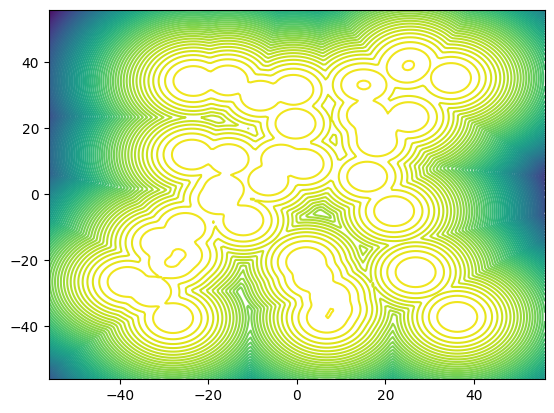

In [4]:
# plot target
target.to("cpu")
fig, ax = plt.subplots()
plotting_bounds = (-loc_scaling * 1.4, loc_scaling * 1.4)
plot_contours(target.log_prob, bounds=plotting_bounds, n_contour_levels=80, ax=ax, grid_width_n_points=200)
target.to("cuda")

## Create FAB model

In [18]:
# hyper-parameters

# Flow
n_flow_layers = 15
layer_nodes_per_dim = 40
lr = 1e-4
max_gradient_norm = 100.0
batch_size = 128
n_iterations = 4000
n_eval = 10
eval_batch_size = batch_size * 10
n_plots = 10 # number of plots shows throughout tranining
use_64_bit = True
alpha = 2.0

# AIS
# By default we use a simple metropolis mcmc transition with a fixed step size.
# Can switch this to 'hmc' to improve training efficiency. 
transition_operator_type = "metropolis" 
n_intermediate_distributions = 1
metropolis_step_size = 5.0

# buffer config
n_batches_buffer_sampling = 4
maximum_buffer_length = batch_size * n_batches_buffer_sampling * 100
min_buffer_length = batch_size * n_batches_buffer_sampling * 10

# target p^\alpha q^{a-\alpha} as target for AIS. 
min_is_target = True
p_target = not min_is_target # Whether to use p as the target. 

In [19]:
if use_64_bit:
    torch.set_default_dtype(torch.float64)
    target = target.double()
    print(f"running with 64 bit")

running with 64 bit


### Setup flow

In [20]:
flow = make_wrapped_normflow_realnvp(dim, n_flow_layers=n_flow_layers, 
                                 layer_nodes_per_dim=layer_nodes_per_dim,
                                act_norm = False)

### Setup Transition operator

In [21]:
if transition_operator_type == "hmc":
    # very lightweight HMC.
    transition_operator = HamiltonianMonteCarlo(
            n_ais_intermediate_distributions=n_intermediate_distributions,
            dim=dim,
            base_log_prob=flow.log_prob,
            target_log_prob=target.log_prob,
            alpha=alpha,
            p_target=p_target,
        n_outer=1,
        epsilon=1.0, L=5)
elif transition_operator_type == "metropolis":
    transition_operator = Metropolis(            
        n_ais_intermediate_distributions=n_intermediate_distributions,
        dim=dim,
        base_log_prob=flow.log_prob,
        target_log_prob=target.log_prob,
        p_target=p_target,
        alpha=alpha,
        n_updates=1,
        adjust_step_size=False,
        max_step_size=metropolis_step_size, # the same for all metropolis steps 
        min_step_size=metropolis_step_size,
        eval_mode=False,
                                  )
else:
    raise NotImplementedError

### Setup FAB model with prioritised replay buffer

In [22]:
# use GPU if available
if torch.cuda.is_available():
    flow.cuda()
    transition_operator.cuda()
    target.to("cuda")
    print(f"Running with GPU")

In [23]:
fab_model = FABModel(flow=flow,
                     target_distribution=target,
                     n_intermediate_distributions=n_intermediate_distributions,
                     transition_operator=transition_operator,
                     alpha=alpha)
optimizer = torch.optim.Adam(flow.parameters(), lr=lr)
logger = ListLogger(save=False) # save training history

In [24]:
# Setup buffer.
def initial_sampler():
  # fill replay buffer using initialised model and AIS.
    point, log_w = fab_model.annealed_importance_sampler.sample_and_log_weights(
            batch_size, logging=False)
    return point.x, log_w, point.log_q
buffer = PrioritisedReplayBuffer(dim=dim, max_length=maximum_buffer_length,
                      min_sample_length=min_buffer_length,
                      initial_sampler=initial_sampler)

In [25]:
def plot(fab_model, n_samples = 128):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    target.to("cpu")
    plot_contours(target.log_prob, bounds=plotting_bounds, ax=axs[0], n_contour_levels=50, grid_width_n_points=200)
    plot_contours(target.log_prob, bounds=plotting_bounds, ax=axs[1], n_contour_levels=50, grid_width_n_points=200)
    plot_contours(target.log_prob, bounds=plotting_bounds, ax=axs[2], n_contour_levels=50, grid_width_n_points=200)
    target.to("cuda")

    # plot flow samples
    samples_flow = fab_model.flow.sample((n_samples,)).detach()
    plot_marginal_pair(samples_flow, ax=axs[0], bounds=plotting_bounds)


    # plot ais samples
    samples_ais = fab_model.annealed_importance_sampler.sample_and_log_weights(n_samples,
                                                                               logging=False)[0].x
    plot_marginal_pair(samples_ais, ax=axs[1], bounds=plotting_bounds)
    
    # plot buffer samples
    samples_buffer = buffer.sample(n_samples)[0].detach()
    plot_marginal_pair(samples_buffer, ax=axs[2], bounds=plotting_bounds)
    
    axs[0].set_title("flow samples")
    axs[1].set_title("ais samples")
    axs[2].set_title("buffer samples")
    plt.show()
    return [fig]

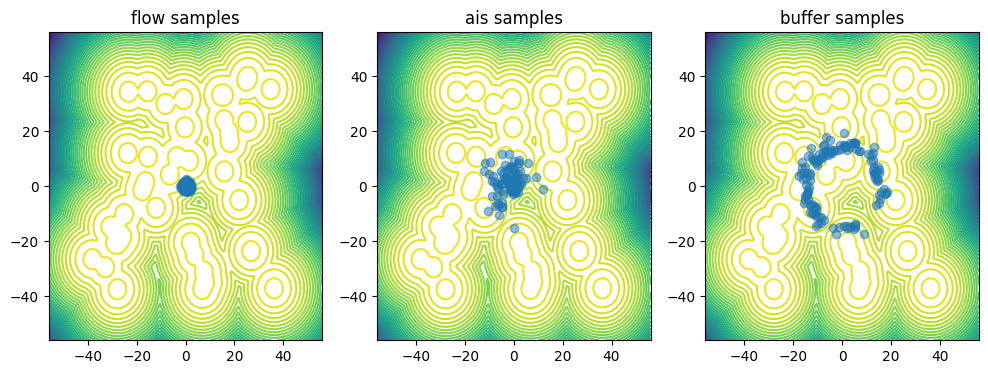

[<Figure size 1200x400 with 3 Axes>]

In [26]:
plot(fab_model) # Visualise model during initialisation.

In [27]:
# Setup trainer.
trainer = PrioritisedBufferTrainer(model=fab_model, optimizer=optimizer, 
              logger=logger, plot=plot,
              buffer=buffer, 
              n_batches_buffer_sampling=n_batches_buffer_sampling,
              max_gradient_norm=max_gradient_norm,
              alpha=alpha,
              w_adjust_max_clip=None)

## Train model

This problem is quite challenging for training, as the flow has a very poor initialisation, and therefore often places extremely small probability on samples in new modes.

This causes some **numerical instability**: There are lots of NaN errors throughout training, due to the flow placing negligible mass on points generated by AIS, as well as numerical instability in the flow.  However, these numerical instabilities do not prevent training from suceeding. 

loss: 0.10983571628744233, ess base: 0.015068910355474845,ess ais: 0.0078125:   0%|                                                                                                                   | 0/4000 [00:00<?, ?it/s]

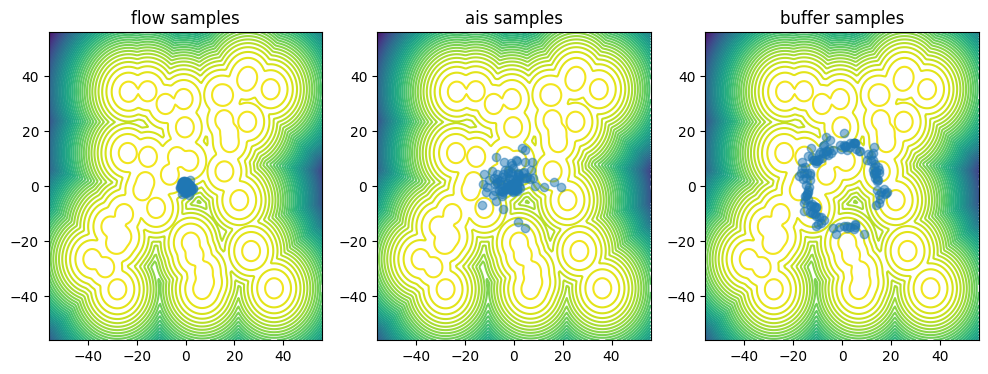

loss: 2.968745743195453, ess base: 0.027460360851529392,ess ais: 0.02027980982294066:   1%|▌                                                                                                 | 23/4000 [00:04<09:33,  6.93it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 4.260790703863693, ess base: 0.02196849524582988,ess ais: 0.009476683751960773:   1%|▌                                                                                                 | 25/4000 [00:04<10:04,  6.58it/s]

3 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 5.144643609685059, ess base: 0.05953111557796514,ess ais: 0.03841820725965833:   1%|▋                                                                                                  | 27/4000 [00:04<10:12,  6.49it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.
4 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 5.461740965392668, ess base: 0.030945029335543425,ess ais: 0.02086935025243431:   1%|▋                                                                                                 | 29/4000 [00:05<10:13,  6.47it/s]

8 nan/inf samples/log-probs/log-weights encountered at chain init.
6 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 6.044178241387547, ess base: 0.060999691518549684,ess ais: 0.01474903502523934:   1%|▊                                                                                                 | 31/4000 [00:05<09:22,  7.05it/s]

7 nan/inf samples/log-probs/log-weights encountered at chain init.
4 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 5.991414839280001, ess base: 0.01580696882447473,ess ais: 0.008321167940264726:   1%|▊                                                                                                 | 33/4000 [00:05<08:37,  7.67it/s]

5 nan/inf samples/log-probs/log-weights encountered at chain init.
6 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 6.094543476543777, ess base: 0.06263625898732238,ess ais: 0.025762342876770095:   1%|▊                                                                                                 | 35/4000 [00:05<09:02,  7.31it/s]

3 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 5.858684589843518, ess base: 0.060726509935375,ess ais: 0.028115341220284407:   1%|▉                                                                                                   | 37/4000 [00:06<09:27,  6.98it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 5.954846479568751, ess base: 0.06590345923027953,ess ais: 0.0420453157055525:   1%|▉                                                                                                   | 39/4000 [00:06<07:51,  8.40it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.
6 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 6.007119638129633, ess base: 0.06725439301175011,ess ais: 0.028546687796294778:   1%|█                                                                                                 | 41/4000 [00:06<08:09,  8.08it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.
4 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 5.941273107192534, ess base: 0.0704245524579138,ess ais: 0.023103885210453475:   1%|█                                                                                                  | 43/4000 [00:06<08:53,  7.42it/s]

3 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 5.940985611947506, ess base: 0.07013534868190316,ess ais: 0.03405234547485737:   1%|█                                                                                                  | 45/4000 [00:07<09:13,  7.14it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 6.238260434823747, ess base: 0.022146295147930865,ess ais: 0.01575417452560495:   1%|█▏                                                                                                | 47/4000 [00:07<09:23,  7.02it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 6.246089481327118, ess base: 0.13331480252759084,ess ais: 0.037976840496950826:   1%|█▏                                                                                                | 49/4000 [00:07<09:31,  6.92it/s]

5 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 6.393655780740737, ess base: 0.05202879396556295,ess ais: 0.014279237482496671:   1%|█▏                                                                                                | 51/4000 [00:07<08:43,  7.54it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 6.477429906380691, ess base: 0.015507574324431334,ess ais: 0.008348115897424473:   1%|█▎                                                                                               | 53/4000 [00:08<08:23,  7.85it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.
5 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 6.553055143374293, ess base: 0.01844019190785575,ess ais: 0.008566115504000552:   1%|█▎                                                                                                | 55/4000 [00:08<08:54,  7.38it/s]

5 nan/inf samples/log-probs/log-weights encountered at chain init.
5 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 6.524464215204177, ess base: 0.021896052579590805,ess ais: 0.009576978610606753:   1%|█▍                                                                                               | 57/4000 [00:08<09:09,  7.17it/s]

4 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 6.555399364368304, ess base: 0.07434179625138063,ess ais: 0.014584267014896318:   1%|█▍                                                                                                | 59/4000 [00:09<08:51,  7.41it/s]

5 nan/inf samples/log-probs/log-weights encountered at chain init.
4 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 6.874897218515318, ess base: 0.03742592133135118,ess ais: 0.01370402214033952:   2%|█▌                                                                                                 | 62/4000 [00:09<09:16,  7.07it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 6.745643006817278, ess base: 0.024423299718908584,ess ais: 0.00980897783607401:   2%|█▌                                                                                                | 65/4000 [00:09<09:36,  6.83it/s]

3 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.06213882191484, ess base: 0.03607484985055606,ess ais: 0.019699095528760476:   2%|█▋                                                                                                 | 67/4000 [00:10<09:23,  6.97it/s]

5 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 6.966969264420424, ess base: 0.04812472158735996,ess ais: 0.011267840343473173:   2%|█▋                                                                                                | 70/4000 [00:10<07:46,  8.43it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.1734921919476005, ess base: 0.11235819189869549,ess ais: 0.047542275834254244:   2%|█▊                                                                                               | 73/4000 [00:10<07:21,  8.89it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.133854563052233, ess base: 0.0644023119191594,ess ais: 0.012834140018845135:   2%|█▊                                                                                                 | 74/4000 [00:11<08:15,  7.92it/s]

3 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.145913090663237, ess base: 0.08218521779916733,ess ais: 0.03454913402942557:   2%|█▉                                                                                                 | 76/4000 [00:11<09:29,  6.89it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.397515091230551, ess base: 0.0338927663895905,ess ais: 0.01596833644909202:   2%|█▉                                                                                                  | 78/4000 [00:11<09:06,  7.17it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.380358602264861, ess base: 0.09169949590167129,ess ais: 0.02238583468994246:   2%|██                                                                                                 | 82/4000 [00:12<07:51,  8.30it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.565200071007132, ess base: 0.026134333090966976,ess ais: 0.011432128383560544:   2%|██                                                                                               | 83/4000 [00:12<08:16,  7.88it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.577203582606099, ess base: 0.09129250538212019,ess ais: 0.020791859546681123:   2%|██                                                                                                | 85/4000 [00:12<09:23,  6.94it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.618371726159486, ess base: 0.13386980241200344,ess ais: 0.04371927988311431:   2%|██▏                                                                                                | 87/4000 [00:12<09:44,  6.69it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.647527165579055, ess base: 0.08491798052004078,ess ais: 0.03021777738378265:   2%|██▏                                                                                                | 89/4000 [00:13<09:54,  6.57it/s]

5 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.20323676349983, ess base: 0.06936321524454474,ess ais: 0.017701386025143897:   2%|██▎                                                                                                | 93/4000 [00:13<09:14,  7.05it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.614668334685542, ess base: 0.04040576152331462,ess ais: 0.013045777587660878:   2%|██▎                                                                                               | 95/4000 [00:14<09:21,  6.95it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.646273178431832, ess base: 0.18211517894065363,ess ais: 0.053669871222137115:   2%|██▍                                                                                               | 97/4000 [00:14<09:34,  6.79it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.993472401958179, ess base: 0.13747354277751345,ess ais: 0.06090177913752756:   2%|██▍                                                                                               | 100/4000 [00:14<09:37,  6.75it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.969643768762555, ess base: 0.12421518398615337,ess ais: 0.03323025309087518:   3%|██▍                                                                                               | 102/4000 [00:15<09:59,  6.51it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.912780519829944, ess base: 0.1557689851750519,ess ais: 0.07256905830682533:   3%|██▌                                                                                                | 103/4000 [00:15<09:56,  6.54it/s]

3 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.306242292002525, ess base: 0.1625227238820757,ess ais: 0.0378505351302603:   3%|██▋                                                                                                 | 107/4000 [00:15<09:29,  6.83it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.301580797534717, ess base: 0.04446666356684589,ess ais: 0.010302749766921276:   3%|██▋                                                                                              | 110/4000 [00:16<11:29,  5.65it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.913781959383245, ess base: 0.09034478471532716,ess ais: 0.014700560435037039:   3%|██▋                                                                                              | 112/4000 [00:16<11:02,  5.87it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.926806536184302, ess base: 0.1170512549473309,ess ais: 0.03670351635996521:   3%|██▊                                                                                                | 114/4000 [00:17<09:54,  6.53it/s]

3 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.393236209040612, ess base: 0.1666011308819389,ess ais: 0.06568144733063458:   3%|██▉                                                                                                | 119/4000 [00:17<08:04,  8.01it/s]

4 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.044324819945748, ess base: 0.12881044049401322,ess ais: 0.03736429861361272:   3%|██▉                                                                                               | 120/4000 [00:17<08:26,  7.65it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.850790164264333, ess base: 0.15479442973069693,ess ais: 0.06507808584447981:   3%|██▉                                                                                               | 122/4000 [00:18<09:04,  7.12it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.291417887918609, ess base: 0.17792265106451663,ess ais: 0.08255896910025269:   3%|███                                                                                               | 124/4000 [00:18<09:44,  6.63it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.453173167790382, ess base: 0.06589786511787636,ess ais: 0.011077168687550747:   3%|███                                                                                              | 126/4000 [00:18<09:51,  6.55it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.854499848069185, ess base: 0.07339070307355232,ess ais: 0.011039912011479467:   3%|███                                                                                              | 128/4000 [00:19<09:50,  6.56it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.744291896648219, ess base: 0.12075475077453736,ess ais: 0.0324787390233647:   3%|███▏                                                                                               | 130/4000 [00:19<10:08,  6.36it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.145644452126076, ess base: 0.12861384293553138,ess ais: 0.025138732440550232:   3%|███▎                                                                                             | 135/4000 [00:20<10:18,  6.24it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.863708476823637, ess base: 0.21689800856574656,ess ais: 0.05411568644928503:   4%|███▍                                                                                              | 141/4000 [00:21<09:27,  6.81it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.669556087759396, ess base: 0.06193876400972635,ess ais: 0.01359068466426301:   4%|███▌                                                                                              | 144/4000 [00:21<09:58,  6.45it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.318939184165567, ess base: 0.09167738713851495,ess ais: 0.017372718583741727:   4%|███▌                                                                                             | 147/4000 [00:21<08:00,  8.02it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.085027912635582, ess base: 0.1318395862473408,ess ais: 0.041897364821167446:   4%|███▋                                                                                              | 149/4000 [00:22<08:11,  7.83it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.06339233359681, ess base: 0.14646220595376547,ess ais: 0.026634449689491874:   4%|███▊                                                                                              | 155/4000 [00:23<09:46,  6.55it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.262440407636436, ess base: 0.18104800897391932,ess ais: 0.047844699079903935:   4%|███▊                                                                                             | 159/4000 [00:23<09:33,  6.70it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.036793315795059, ess base: 0.15298897983768095,ess ais: 0.04591970119050342:   4%|████▏                                                                                             | 169/4000 [00:25<09:58,  6.41it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.114910873604696, ess base: 0.18868632423099124,ess ais: 0.07911341213227838:   4%|████▏                                                                                             | 171/4000 [00:25<10:00,  6.38it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.64466218664826, ess base: 0.157977081145957,ess ais: 0.049812894006302996:   4%|████▍                                                                                               | 177/4000 [00:26<10:29,  6.07it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.265047541289507, ess base: 0.20165151094698414,ess ais: 0.06309314431472982:   5%|████▋                                                                                             | 189/4000 [00:28<09:21,  6.79it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.478590144258195, ess base: 0.20431094299330485,ess ais: 0.0749211994905357:   5%|████▋                                                                                              | 191/4000 [00:28<09:35,  6.62it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.836584716181951, ess base: 0.17300226382810452,ess ais: 0.09187507649099415:   5%|████▊                                                                                             | 196/4000 [00:29<10:22,  6.11it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.028086746316667, ess base: 0.18589907565698957,ess ais: 0.06603510283487184:   5%|████▊                                                                                             | 198/4000 [00:29<10:39,  5.95it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.882554644106696, ess base: 0.19605702334271666,ess ais: 0.07607216559093993:   5%|█████                                                                                             | 206/4000 [00:31<10:26,  6.06it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 9.956445295755945, ess base: 0.2002764033595905,ess ais: 0.09422190351986645:   5%|█████▏                                                                                             | 210/4000 [00:31<09:59,  6.32it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.934085504651697, ess base: 0.23222361717540807,ess ais: 0.008457641533642915:   6%|█████▍                                                                                           | 226/4000 [00:34<10:08,  6.20it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.727827023144867, ess base: 0.10279174432425435,ess ais: 0.020727365979599448:   7%|██████▍                                                                                          | 263/4000 [00:40<10:42,  5.81it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.8565753803132665, ess base: 0.26232811108294224,ess ais: 0.07625714786330101:   7%|██████▍                                                                                          | 268/4000 [00:41<11:17,  5.51it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.806013419428365, ess base: 0.17481534497792123,ess ais: 0.07696908072207674:   7%|██████▋                                                                                           | 274/4000 [00:42<11:11,  5.54it/s]

nan grad norm in replay step


loss: 263.91003067372196, ess base: 0.19586654091253075,ess ais: 0.07578294463572126:   7%|██████▊                                                                                          | 279/4000 [00:43<12:28,  4.97it/s]

nan grad norm in replay step


loss: 8.315718891968354, ess base: 0.27146447474835544,ess ais: 0.17383011859211686:   7%|██████▉                                                                                           | 284/4000 [00:43<11:23,  5.44it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.182008926440565, ess base: 0.20983687892822914,ess ais: 0.11554369926192477:   7%|███████                                                                                           | 290/4000 [00:45<12:18,  5.02it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.401448392910844, ess base: 0.28259237479470595,ess ais: 0.1281878530917949:   8%|███████▍                                                                                           | 302/4000 [00:47<11:26,  5.39it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.860449119292356, ess base: 0.2088760776767579,ess ais: 0.0634992998962709:   8%|███████▉                                                                                            | 317/4000 [00:50<13:05,  4.69it/s]

nan loss in replay step


loss: 8.068649432457773, ess base: 0.22381450448774373,ess ais: 0.13824325608378008:   8%|███████▊                                                                                          | 320/4000 [00:51<12:14,  5.01it/s]

nan loss in replay step
nan loss in replay step


loss: 1253989.9338798982, ess base: 0.17221361994260734,ess ais: 0.06300597689669185:   8%|███████▊                                                                                         | 324/4000 [00:52<13:12,  4.64it/s]

nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 12.566297222085337, ess base: 0.19292577687617873,ess ais: 0.0078125:   8%|████████▋                                                                                                  | 327/4000 [00:52<13:08,  4.66it/s]

nan loss in replay step


loss: 8.723757754331366, ess base: 0.1924786947284742,ess ais: 0.0078125:   8%|████████▉                                                                                                    | 328/4000 [00:52<12:48,  4.78it/s]

nan loss in replay step


loss: 9.694746451805008, ess base: 0.2527895045654931,ess ais: 0.10193253687367913:   8%|████████▏                                                                                          | 330/4000 [00:53<13:14,  4.62it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.493562384313588, ess base: 0.27676695348329894,ess ais: 0.0078125:   8%|████████▉                                                                                                   | 331/4000 [00:53<12:40,  4.83it/s]

nan loss in replay step


loss: 8.433843183965864, ess base: 0.16549062417973848,ess ais: 0.0709721780337908:   8%|████████▏                                                                                          | 333/4000 [00:53<12:30,  4.88it/s]

nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 7.9280719959773025, ess base: 0.23438727740024198,ess ais: 0.12877807797182678:   8%|████████▏                                                                                        | 337/4000 [00:54<12:36,  4.84it/s]

nan loss in replay step
nan loss in replay step


loss: 7.905606039644724, ess base: 0.12663006379730282,ess ais: 0.007959177060595096:   8%|████████▏                                                                                        | 339/4000 [00:55<11:13,  5.44it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.862650837027899, ess base: 0.17298965236085737,ess ais: 0.08434097230372822:   9%|████████▎                                                                                         | 341/4000 [00:55<11:59,  5.08it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 8.728749328878642, ess base: 0.19978334752968724,ess ais: 0.11282804215916771:   9%|████████▍                                                                                         | 342/4000 [00:55<12:13,  4.99it/s]

nan loss in replay step


loss: 8.919599525629069, ess base: 0.029982595919009508,ess ais: 0.008650398923340411:   9%|████████▎                                                                                       | 346/4000 [00:56<12:55,  4.71it/s]

nan grad norm in replay step
nan loss in replay step


loss: 8.016204136819987, ess base: 0.21334255611896438,ess ais: 0.11954809482896181:   9%|████████▌                                                                                         | 348/4000 [00:57<12:29,  4.87it/s]

nan loss in replay step
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.362278900461723, ess base: 0.1803613638177954,ess ais: 0.10226763864526126:   9%|████████▋                                                                                          | 352/4000 [00:57<13:10,  4.61it/s]

nan loss in replay step


loss: 8.177723872199522, ess base: 0.23086109211067715,ess ais: 0.12492939486822408:   9%|████████▋                                                                                         | 355/4000 [00:58<13:12,  4.60it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.283218900004323, ess base: 0.0874788427446833,ess ais: 0.010100936573812001:   9%|████████▋                                                                                         | 356/4000 [00:58<11:36,  5.23it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 9.102273996285543, ess base: 0.20078781277071386,ess ais: 0.007812648964852826:   9%|████████▋                                                                                        | 357/4000 [00:58<11:55,  5.09it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.290062959584976, ess base: 0.2044343286831056,ess ais: 0.11093942305280613:   9%|████████▉                                                                                          | 360/4000 [00:59<13:03,  4.65it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.852528290419736, ess base: 0.0652774460006199,ess ais: 0.00970867403748542:   9%|████████▉                                                                                          | 361/4000 [00:59<13:14,  4.58it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.862494803485816, ess base: 0.20556891426360616,ess ais: 0.10841368290260713:   9%|████████▉                                                                                         | 364/4000 [01:00<13:25,  4.51it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.139630779021495, ess base: 0.22232255037943488,ess ais: 0.1316803839168917:   9%|█████████                                                                                          | 367/4000 [01:01<13:35,  4.45it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 20.61716913375125, ess base: 0.12308687168446002,ess ais: 0.034572196229039454:   9%|████████▉                                                                                        | 369/4000 [01:01<13:39,  4.43it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.344366519200598, ess base: 0.21285871762834005,ess ais: 0.008294155724204517:  10%|█████████▏                                                                                       | 381/4000 [01:04<13:42,  4.40it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.946411396590798, ess base: 0.12365995007261918,ess ais: 0.01489143736985502:  10%|█████████▍                                                                                        | 387/4000 [01:05<13:32,  4.45it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.788831499874108, ess base: 0.18277204321399992,ess ais: 0.0636481349949847:  10%|█████████▌                                                                                         | 388/4000 [01:05<13:27,  4.47it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.335753703803327, ess base: 0.24153602312354566,ess ais: 0.09493649236901958:  10%|█████████▌                                                                                        | 389/4000 [01:06<13:25,  4.48it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.872018655602185, ess base: 0.2743233651386237,ess ais: 0.007936507936507936:  10%|█████████▌                                                                                        | 390/4000 [01:06<13:26,  4.48it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.853560093146198, ess base: 0.21872642931884456,ess ais: 0.007874015748031496:  10%|█████████▌                                                                                       | 392/4000 [01:06<13:20,  4.51it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.652480955149262, ess base: 0.244137432354729,ess ais: 0.007874015748031496:  10%|█████████▋                                                                                         | 393/4000 [01:06<12:50,  4.68it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 8.495569682293532, ess base: 0.1484062443238901,ess ais: 0.03207539571729898:  10%|█████████▊                                                                                         | 394/4000 [01:07<13:11,  4.56it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.747266053538349, ess base: 0.21531059896669602,ess ais: 0.0078125:  10%|██████████▋                                                                                                 | 396/4000 [01:07<12:55,  4.65it/s]

nan loss in replay step
nan loss in replay step


loss: 8.476109346200237, ess base: 0.23282014395082226,ess ais: 0.008200274378699402:  10%|█████████▋                                                                                       | 397/4000 [01:08<12:35,  4.77it/s]

3 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.247879353540256, ess base: 0.12061394515358848,ess ais: 0.021202547253156758:  10%|█████████▋                                                                                       | 400/4000 [01:08<12:43,  4.71it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 8.469819151566249, ess base: 0.20152647117980474,ess ais: 0.009432250946264388:  10%|█████████▋                                                                                       | 401/4000 [01:08<12:44,  4.71it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 8.127014763526367, ess base: 0.2597706098545051,ess ais: 0.15363344050039626:  10%|██████████                                                                                         | 405/4000 [01:09<13:11,  4.54it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 9.039817445185202, ess base: 0.25015843579172437,ess ais: 0.12487111431557658:  10%|█████████▉                                                                                        | 406/4000 [01:09<12:40,  4.72it/s]

nan loss in replay step
nan loss in replay step


loss: 8.241301567443784, ess base: 0.2266326072547466,ess ais: 0.0078125:  10%|███████████▏                                                                                                 | 410/4000 [01:10<12:54,  4.64it/s]

nan loss in replay step


loss: 7.92986515895079, ess base: 0.2186415578326169,ess ais: 0.0918978610449628:  10%|██████████▍                                                                                          | 412/4000 [01:11<12:38,  4.73it/s]

nan loss in replay step
2 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 29.89673594480579, ess base: 0.22098206971346837,ess ais: 0.07391907048161597:  10%|██████████▏                                                                                       | 414/4000 [01:11<12:07,  4.93it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 9.917019831494546, ess base: 0.12219909151926929,ess ais: 0.0078125:  10%|███████████▏                                                                                                | 416/4000 [01:11<12:47,  4.67it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.313109592387146, ess base: 0.19911932820368278,ess ais: 0.09265128613276298:  10%|██████████▏                                                                                       | 417/4000 [01:12<13:07,  4.55it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.361611330312428, ess base: 0.25220838551274266,ess ais: 0.11256063067633669:  10%|██████████▎                                                                                       | 420/4000 [01:12<13:54,  4.29it/s]

3 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.730428903646738, ess base: 0.09083696964830594,ess ais: 0.012907128131259566:  11%|██████████▏                                                                                      | 421/4000 [01:13<14:07,  4.22it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.
nan grad norm in replay step


loss: 8.005512459496593, ess base: 0.19351884561027824,ess ais: 0.007874015748031496:  11%|██████████▎                                                                                      | 423/4000 [01:13<13:55,  4.28it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan grad norm in replay step


loss: 862.5141584873596, ess base: 0.06613187944699132,ess ais: 0.011237223860227928:  11%|██████████▎                                                                                      | 425/4000 [01:14<16:06,  3.70it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 8.162549886464294, ess base: 0.07112889174496531,ess ais: 0.011490821755881803:  11%|██████████▎                                                                                      | 426/4000 [01:14<15:08,  3.93it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 7.690403785497653, ess base: 0.20209695610929124,ess ais: 0.0700727279593145:  11%|██████████▌                                                                                        | 428/4000 [01:14<14:36,  4.08it/s]

nan loss in replay step


loss: 6.534670636572739e+113, ess base: 0.20103090622710665,ess ais: 0.10066775833323248:  11%|█████████▉                                                                                   | 430/4000 [01:15<12:51,  4.62it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 8.475622379886392, ess base: 0.20641577585483106,ess ais: 0.10167035458054821:  11%|██████████▌                                                                                       | 431/4000 [01:15<12:31,  4.75it/s]

nan loss in replay step


loss: 8.99062710866722, ess base: 0.13385493708407623,ess ais: 0.0078125:  11%|███████████▊                                                                                                 | 433/4000 [01:15<12:38,  4.70it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 12.045459164600812, ess base: 0.22667033202613066,ess ais: 0.08363674814632358:  11%|██████████▌                                                                                      | 435/4000 [01:16<12:37,  4.71it/s]

nan loss in replay step
nan grad norm in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.901453844761742, ess base: 0.1870839282894128,ess ais: 0.0520191157706664:  11%|██████████▉                                                                                         | 436/4000 [01:16<12:31,  4.74it/s]

nan grad norm in replay step
2 nan/inf samples/log-probs/log-weights encountered at chain init.
nan grad norm in replay step


loss: 10.226333642543072, ess base: 0.18014924808226238,ess ais: 0.007874015748031496:  11%|██████████▌                                                                                     | 439/4000 [01:17<12:30,  4.74it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 9.032581008535105, ess base: 0.10526344558616081,ess ais: 0.03210210606491712:  11%|██████████▊                                                                                       | 440/4000 [01:17<12:31,  4.74it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.564015584362036, ess base: 0.17545104283561394,ess ais: 0.0078125:  11%|███████████▉                                                                                                | 441/4000 [01:17<12:06,  4.90it/s]

nan loss in replay step


loss: 8.87896079409999, ess base: 0.2134354935126994,ess ais: 0.0078125:  11%|████████████▏                                                                                                 | 443/4000 [01:18<12:14,  4.85it/s]

nan grad norm in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 8.171252061474425, ess base: 0.12996885969572675,ess ais: 0.0078125:  11%|███████████▉                                                                                                | 444/4000 [01:18<11:47,  5.03it/s]

nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
4 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


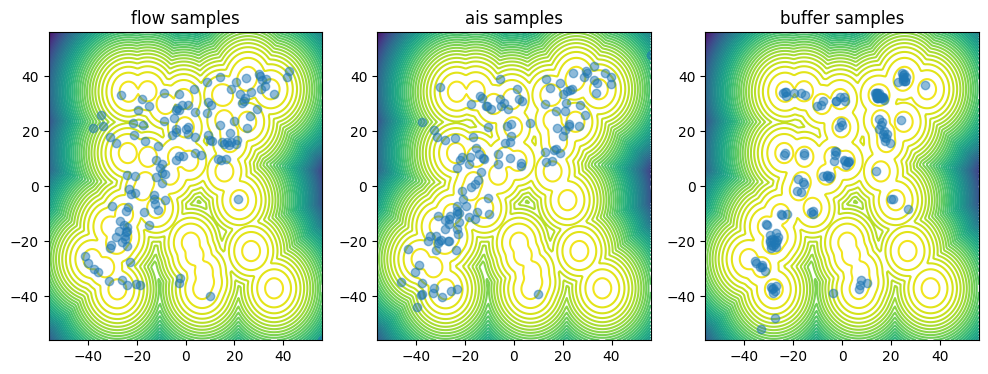

loss: 8.830095285293776, ess base: 0.2086841062660865,ess ais: 0.0683864064388746:  11%|███████████▏                                                                                        | 446/4000 [01:20<30:05,  1.97it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 105237874632.24864, ess base: 0.20685404847557057,ess ais: 0.1259706793707468:  11%|██████████▉                                                                                       | 448/4000 [01:20<20:16,  2.92it/s]

nan loss in replay step
4 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 9.161647055751137, ess base: 0.21118858822460196,ess ais: 0.1271059788521136:  11%|███████████▏                                                                                       | 451/4000 [01:21<14:30,  4.08it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
3 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.616994449067516, ess base: 0.2014986837861816,ess ais: 0.008:  11%|████████████▊                                                                                                    | 452/4000 [01:21<12:53,  4.58it/s]

nan loss in replay step
nan loss in replay step
2 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 8.523473545782167, ess base: 0.27650502594764037,ess ais: 0.007874015748031496:  11%|███████████                                                                                      | 454/4000 [01:21<12:27,  4.74it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.054889551336816, ess base: 0.2021759521029847,ess ais: 0.08566286962073756:  11%|███████████▎                                                                                       | 455/4000 [01:21<12:29,  4.73it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.183581862330318, ess base: 0.2697229637171965,ess ais: 0.1005735667696539:  11%|███████████▍                                                                                        | 456/4000 [01:21<12:03,  4.90it/s]

nan loss in replay step
nan loss in replay step


loss: 7.905179763111993, ess base: 0.17647902506992047,ess ais: 0.007812500000130552:  11%|███████████                                                                                      | 458/4000 [01:22<11:33,  5.11it/s]

nan loss in replay step
2 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 7.69817061974062, ess base: 0.18067038717967157,ess ais: 0.03999345935793058:  12%|███████████▍                                                                                       | 460/4000 [01:22<10:49,  5.45it/s]

nan loss in replay step
nan loss in replay step


loss: 8.56328547047302, ess base: 0.17256388187901578,ess ais: 0.03747674497261152:  12%|███████████▍                                                                                       | 462/4000 [01:23<11:54,  4.95it/s]

3 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.769137755065587, ess base: 0.25179746061307606,ess ais: 0.1557422724159523:  12%|███████████▍                                                                                       | 463/4000 [01:23<11:33,  5.10it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 8.186238664255857, ess base: 0.2035615936713631,ess ais: 0.08152140743755135:  12%|███████████▍                                                                                       | 464/4000 [01:23<11:23,  5.17it/s]

nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 7.831986115707218, ess base: 0.19367118253668172,ess ais: 0.051155676579993314:  12%|███████████▎                                                                                     | 466/4000 [01:23<11:38,  5.06it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.295226337138928, ess base: 0.22405384040943402,ess ais: 0.0078125:  12%|████████████▌                                                                                               | 467/4000 [01:24<11:25,  5.15it/s]

nan loss in replay step
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.204810932960426, ess base: 0.16243971867484228,ess ais: 0.05641196267752931:  12%|███████████▍                                                                                      | 469/4000 [01:24<11:42,  5.03it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.
nan grad norm in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.803342106997071, ess base: 0.010563126230881091,ess ais: 0.007890892432461384:  12%|███████████▎                                                                                    | 471/4000 [01:24<12:15,  4.80it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.996240336897164, ess base: 0.2200473964821935,ess ais: 0.07668607580803603:  12%|███████████▋                                                                                       | 472/4000 [01:25<11:52,  4.95it/s]

nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan grad norm in replay step


loss: 8.246639088874073, ess base: 0.21408797818462105,ess ais: 0.10355778628035985:  12%|███████████▌                                                                                      | 473/4000 [01:25<11:50,  4.97it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.
nan grad norm in replay step


loss: 9.93069225146408, ess base: 0.18968619502895967,ess ais: 0.0768003453622095:  12%|███████████▉                                                                                        | 476/4000 [01:26<14:07,  4.16it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 30.886995611849247, ess base: 0.2804558617701207,ess ais: 0.16904035399661482:  12%|███████████▋                                                                                      | 477/4000 [01:26<13:20,  4.40it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
7 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 24.9622385927354, ess base: 0.2059927243569099,ess ais: 0.10226771132026208:  12%|███████████▉                                                                                        | 478/4000 [01:26<12:42,  4.62it/s]

nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 26.37267872377347, ess base: 0.2000778903123047,ess ais: 0.007874015748031496:  12%|███████████▊                                                                                      | 480/4000 [01:26<12:36,  4.65it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 8.721735570957314, ess base: 0.1894431878759252,ess ais: 0.11574623991591342:  12%|███████████▉                                                                                       | 481/4000 [01:27<12:48,  4.58it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan grad norm in replay step


loss: 8.31935875619068, ess base: 0.1426879307093953,ess ais: 0.048613175890710125:  12%|███████████▉                                                                                       | 482/4000 [01:27<13:06,  4.47it/s]

3 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 8.76117305538395, ess base: 0.20348255947523447,ess ais: 0.0646364499911528:  12%|████████████                                                                                        | 483/4000 [01:27<13:42,  4.27it/s]

3 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.709585995800474, ess base: 0.16700533201350265,ess ais: 0.0644651195869907:  12%|████████████                                                                                       | 485/4000 [01:28<13:37,  4.30it/s]

nan grad norm in replay step
4 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.953603299614491, ess base: 0.19657258413605136,ess ais: 0.008064516129032258:  12%|███████████▊                                                                                     | 486/4000 [01:28<13:11,  4.44it/s]

nan grad norm in replay step
4 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 8.536966275262188, ess base: 0.24000644524437134,ess ais: 0.008064517916888664:  12%|███████████▊                                                                                     | 488/4000 [01:28<12:24,  4.72it/s]

4 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.787380252168395, ess base: 0.20106761019448743,ess ais: 0.07524568343123275:  12%|███████████▉                                                                                      | 489/4000 [01:28<11:53,  4.92it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.249017304234805, ess base: 0.21204390812257087,ess ais: 0.05491639554753466:  12%|████████████                                                                                      | 490/4000 [01:29<11:33,  5.06it/s]

nan loss in replay step
nan loss in replay step


loss: 7.845060005902787, ess base: 0.2250060558066287,ess ais: 0.03719311811076145:  12%|████████████▏                                                                                      | 492/4000 [01:29<11:41,  5.00it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.3873133215953, ess base: 0.15990981138671162,ess ais: 0.08910815808533129:  12%|████████████▎                                                                                       | 494/4000 [01:30<13:25,  4.35it/s]

nan loss in replay step


loss: 7.7150823167655425, ess base: 0.22604383573411554,ess ais: 0.11004027459894163:  12%|████████████                                                                                     | 495/4000 [01:30<12:54,  4.53it/s]

nan loss in replay step
nan loss in replay step


loss: 8.732395105880347, ess base: 0.20029520168143375,ess ais: 0.010349298813153376:  12%|████████████                                                                                     | 497/4000 [01:30<12:57,  4.51it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 9.436755612423155e+52, ess base: 0.21482768083232529,ess ais: 0.0078125:  12%|████████████▉                                                                                           | 498/4000 [01:30<12:49,  4.55it/s]

nan loss in replay step
nan loss in replay step


loss: 8.262670908174439, ess base: 0.22403274687617952,ess ais: 0.09327446613517176:  13%|████████████▎                                                                                     | 502/4000 [01:31<11:08,  5.23it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step


loss: 8.289737516450119, ess base: 0.20393411592789257,ess ais: 0.008064516129032258:  13%|████████████▏                                                                                    | 504/4000 [01:31<10:14,  5.69it/s]

4 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.867356007316833e+109, ess base: 0.2709074524732837,ess ais: 0.0078125:  13%|█████████████▏                                                                                          | 506/4000 [01:32<11:08,  5.22it/s]

nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 15.123423623372357, ess base: 0.20026004884646975,ess ais: 0.007874015748031496:  13%|████████████▏                                                                                   | 508/4000 [01:32<11:03,  5.26it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.045796320051064, ess base: 0.2790249949906219,ess ais: 0.1469397510421301:  13%|████████████▋                                                                                       | 509/4000 [01:32<11:05,  5.25it/s]

nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 7.790203139921495, ess base: 0.2608168157294189,ess ais: 0.007874015748031496:  13%|████████████▍                                                                                     | 510/4000 [01:33<11:43,  4.96it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.987102677603062, ess base: 0.31567082325955387,ess ais: 0.21381252591023658:  13%|████████████▌                                                                                     | 511/4000 [01:33<13:17,  4.38it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.956457012265917, ess base: 0.24786996298084665,ess ais: 0.08272210283999226:  13%|████████████▌                                                                                     | 513/4000 [01:34<14:46,  3.93it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 8.1433588579849, ess base: 0.19783956382119505,ess ais: 0.07690356780777641:  13%|████████████▊                                                                                       | 514/4000 [01:34<13:49,  4.20it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.159150538098952, ess base: 0.2514480007404564,ess ais: 0.007874015748031496:  13%|████████████▌                                                                                     | 515/4000 [01:34<14:06,  4.12it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.911153674973415, ess base: 0.24570825988282766,ess ais: 0.13653186069908202:  13%|████████████▋                                                                                     | 517/4000 [01:34<13:05,  4.44it/s]

nan loss in replay step
2 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 8.157922332748306, ess base: 0.20096795836355805,ess ais: 0.007936507936507936:  13%|████████████▌                                                                                    | 520/4000 [01:35<12:13,  4.74it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.
nan grad norm in replay step
nan loss in replay step


loss: 7.888368902332717, ess base: 0.1884985573142749,ess ais: 0.06413630922288074:  13%|████████████▉                                                                                      | 521/4000 [01:35<12:16,  4.73it/s]

nan loss in replay step


loss: 4140.549681626991, ess base: 0.05584277792829071,ess ais: 0.00870322768389002:  13%|████████████▊                                                                                     | 522/4000 [01:35<12:08,  4.77it/s]

nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 8.445652923049717, ess base: 0.22887146114308396,ess ais: 0.11430269793007859:  13%|████████████▊                                                                                     | 523/4000 [01:36<11:57,  4.84it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 5.706578430169352e+79, ess base: 0.18895224945562844,ess ais: 0.06789742874088399:  13%|████████████▎                                                                                 | 526/4000 [01:36<12:09,  4.76it/s]

4 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.56074218837163, ess base: 0.23163846412704972,ess ais: 0.007874015748031496:  13%|████████████▉                                                                                     | 527/4000 [01:37<12:19,  4.70it/s]

nan grad norm in replay step


loss: 8.103853448382285, ess base: 0.19229656486164912,ess ais: 0.07240013077504391:  13%|████████████▉                                                                                     | 529/4000 [01:37<12:32,  4.61it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan grad norm in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.47737665845429, ess base: 0.2063167552999991,ess ais: 0.11310088727940022:  13%|█████████████▎                                                                                      | 531/4000 [01:37<12:50,  4.50it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 9.21314120735207, ess base: 0.2230597347819079,ess ais: 0.09219934915186621:  13%|█████████████▎                                                                                      | 532/4000 [01:38<12:40,  4.56it/s]

3 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 9.250084743247776, ess base: 0.23653094022703436,ess ais: 0.0078125:  13%|██████████████▍                                                                                             | 533/4000 [01:38<12:39,  4.57it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.997988296623263, ess base: 0.18372223162477447,ess ais: 0.06841038342700435:  13%|█████████████                                                                                     | 535/4000 [01:38<12:27,  4.64it/s]

nan loss in replay step


loss: 8.022571229981335, ess base: 0.1829412423830142,ess ais: 0.0078125:  13%|██████████████▌                                                                                              | 536/4000 [01:39<12:19,  4.68it/s]

nan loss in replay step


loss: 7.967241586663519, ess base: 0.18290248672918266,ess ais: 0.0454354428829169:  13%|█████████████▎                                                                                     | 537/4000 [01:39<12:20,  4.67it/s]

nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.687444326766284, ess base: 0.20955051539517003,ess ais: 0.07718973933982443:  13%|█████████████▏                                                                                    | 538/4000 [01:39<12:09,  4.75it/s]

nan loss in replay step


loss: 8.812608272723487, ess base: 0.23849104032729596,ess ais: 0.0078125:  14%|██████████████▌                                                                                             | 540/4000 [01:39<12:03,  4.78it/s]

nan loss in replay step
nan loss in replay step


loss: 2.9031079972732077e+23, ess base: 0.11245783283695605,ess ais: 0.027968328976675293:  14%|████████████▍                                                                               | 542/4000 [01:40<11:31,  5.00it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.43331746944753, ess base: 0.20507039884778108,ess ais: 0.10091287373355709:  14%|█████████████▍                                                                                     | 544/4000 [01:40<12:49,  4.49it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.323248056231291, ess base: 0.09913269416594493,ess ais: 0.023562284487943293:  14%|█████████████▏                                                                                   | 546/4000 [01:41<12:53,  4.47it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 8.143972885148699, ess base: 0.20533630646978654,ess ais: 0.007936507936507936:  14%|█████████████▎                                                                                   | 547/4000 [01:41<12:14,  4.70it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.919788263887074, ess base: 0.2319626266148795,ess ais: 0.07962046292580578:  14%|█████████████▌                                                                                     | 548/4000 [01:41<11:10,  5.15it/s]

nan loss in replay step
4 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 7.851819903730547, ess base: 0.250213236596068,ess ais: 0.0078125:  14%|███████████████▏                                                                                              | 550/4000 [01:41<09:54,  5.81it/s]

nan loss in replay step
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.04207112713065, ess base: 0.23396706112266313,ess ais: 0.09728199739334421:  14%|█████████████▋                                                                                     | 552/4000 [01:42<08:31,  6.74it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 180.30693922256026, ess base: 0.22896791096547267,ess ais: 0.0078125:  14%|██████████████▊                                                                                            | 555/4000 [01:42<07:29,  7.66it/s]

nan loss in replay step
nan loss in replay step


loss: 12.0880874762585, ess base: 0.22055281029823004,ess ais: 0.08643277990490453:  14%|█████████████▊                                                                                     | 556/4000 [01:42<07:52,  7.28it/s]

nan loss in replay step
nan loss in replay step


loss: 8.206134086644699, ess base: 0.18211128918654437,ess ais: 0.08278052421329685:  14%|█████████████▋                                                                                    | 558/4000 [01:42<07:22,  7.78it/s]

nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.169456524283913, ess base: 0.24188082693445762,ess ais: 0.11670267019598105:  14%|█████████████▋                                                                                    | 560/4000 [01:43<09:16,  6.18it/s]

nan loss in replay step
4 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 7.755859356755256, ess base: 0.2357339507405519,ess ais: 0.10689652202103866:  14%|█████████████▉                                                                                     | 562/4000 [01:43<10:14,  5.60it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.816559306567765, ess base: 0.2814191022564879,ess ais: 0.008:  14%|███████████████▉                                                                                                 | 563/4000 [01:43<09:59,  5.73it/s]

nan loss in replay step
nan loss in replay step
nan loss in replay step


loss: 8.32792711371999, ess base: 0.20655945817310833,ess ais: 0.10912321441577051:  14%|█████████████▉                                                                                     | 565/4000 [01:44<09:46,  5.85it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
4 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.229422256832196, ess base: 0.208323043913534,ess ais: 0.06042305430519837:  14%|██████████████▏                                                                                     | 567/4000 [01:44<10:24,  5.50it/s]

nan loss in replay step
3 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 8.205548394905026, ess base: 0.27201943038844273,ess ais: 0.1446216437865399:  14%|██████████████                                                                                     | 569/4000 [01:44<10:38,  5.37it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.648343633031253, ess base: 0.22757391661360007,ess ais: 0.09844966197707583:  14%|█████████████▉                                                                                    | 570/4000 [01:45<10:33,  5.42it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.108163944819534, ess base: 0.2425939284882681,ess ais: 0.007874015748031496:  14%|█████████████▉                                                                                    | 571/4000 [01:45<10:20,  5.53it/s]

nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 7.5300861828238395, ess base: 0.22369695257155356,ess ais: 0.007874015748031496:  14%|█████████████▊                                                                                  | 574/4000 [01:45<09:58,  5.73it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
2 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 8.345306329991276, ess base: 0.1760903499151521,ess ais: 0.0078125:  14%|███████████████▋                                                                                             | 576/4000 [01:46<10:07,  5.64it/s]

nan loss in replay step


loss: 8.354286904982835, ess base: 0.20336561696949276,ess ais: 0.054533150431191973:  14%|█████████████▉                                                                                   | 577/4000 [01:46<11:11,  5.10it/s]

nan loss in replay step
nan loss in replay step


loss: 8.285037378170024, ess base: 0.2781832491724418,ess ais: 0.17581524950651753:  14%|██████████████▎                                                                                    | 579/4000 [01:46<09:33,  5.97it/s]

nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.908857901506542, ess base: 0.21586460138251254,ess ais: 0.007874015748031496:  15%|██████████████                                                                                   | 581/4000 [01:46<09:23,  6.07it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.135907909516252, ess base: 0.19853497591705738,ess ais: 0.0778770909619587:  15%|██████████████▍                                                                                    | 582/4000 [01:47<09:31,  5.98it/s]

nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 8.797582365160414, ess base: 0.19403368617906505,ess ais: 0.007874015748031496:  15%|██████████████▏                                                                                  | 584/4000 [01:47<09:06,  6.26it/s]

nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.021854914472726, ess base: 0.24779457485553352,ess ais: 0.007874015748191708:  15%|██████████████▏                                                                                  | 585/4000 [01:47<09:02,  6.30it/s]

nan loss in replay step
2 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 7.773373368227919, ess base: 0.2206457370286485,ess ais: 0.0078125:  15%|███████████████▉                                                                                             | 587/4000 [01:47<09:02,  6.30it/s]

nan loss in replay step


loss: 8.246106401688138, ess base: 0.23412317359247317,ess ais: 0.11952224545703011:  15%|██████████████▍                                                                                   | 589/4000 [01:48<09:26,  6.02it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 10.154848241473541, ess base: 0.2472594693549847,ess ais: 0.008:  15%|████████████████▌                                                                                               | 592/4000 [01:48<10:36,  5.35it/s]

3 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 1.8692293983836861e+174, ess base: 0.21843277808712244,ess ais: 0.09396368658525393:  15%|█████████████▋                                                                              | 594/4000 [01:49<08:44,  6.49it/s]

nan loss in replay step
2 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step
nan grad norm in replay step


loss: 7.940062209517413, ess base: 0.22943738026958713,ess ais: 0.11456293981967886:  15%|██████████████▌                                                                                   | 595/4000 [01:49<09:23,  6.05it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.272972224091655, ess base: 0.18517740504451818,ess ais: 0.09423371002411585:  15%|██████████████▋                                                                                   | 597/4000 [01:49<08:16,  6.85it/s]

nan loss in replay step
nan loss in replay step


loss: 7.547824002020638, ess base: 0.20902796405615248,ess ais: 0.10566355236389004:  15%|██████████████▋                                                                                   | 599/4000 [01:49<08:33,  6.62it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 9.118074139425389e+193, ess base: 0.13180704680677977,ess ais: 0.016972979565694032:  15%|█████████████▊                                                                              | 602/4000 [01:50<07:00,  8.08it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan grad norm in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 6127216838777.835, ess base: 0.2145148434287147,ess ais: 0.007874015748031496:  15%|██████████████▊                                                                                   | 603/4000 [01:50<07:11,  7.88it/s]

nan loss in replay step


loss: 8.94716228846551, ess base: 0.27236991463499177,ess ais: 0.007874015748031496:  15%|██████████████▊                                                                                   | 605/4000 [01:50<08:48,  6.43it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
2 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 9.336129172825512, ess base: 0.24274743477299285,ess ais: 0.12569373679781504:  15%|██████████████▉                                                                                   | 608/4000 [01:51<08:04,  7.00it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 9.511360467646242, ess base: 0.1711600848344995,ess ais: 0.04943223589551023:  15%|███████████████                                                                                    | 610/4000 [01:51<06:49,  8.28it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 7.677459761674603, ess base: 0.2354776379466069,ess ais: 0.0078125:  15%|████████████████▋                                                                                            | 612/4000 [01:51<07:28,  7.55it/s]

nan loss in replay step
nan loss in replay step


loss: 8.460610753702179, ess base: 0.21550556356058823,ess ais: 0.08535176901747003:  15%|███████████████                                                                                   | 614/4000 [01:51<08:39,  6.51it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 8.033294275495201, ess base: 0.22115179679125718,ess ais: 0.11036052573578323:  15%|███████████████                                                                                   | 616/4000 [01:52<08:35,  6.56it/s]

nan loss in replay step
nan loss in replay step


loss: 10.677998200137264, ess base: 0.17523438539983288,ess ais: 0.007874015748248064:  15%|██████████████▊                                                                                 | 619/4000 [01:52<09:00,  6.25it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 1.0787861391614062e+28, ess base: 0.24722072154173194,ess ais: 0.0078125:  16%|███████████████▉                                                                                       | 621/4000 [01:53<08:40,  6.49it/s]

nan loss in replay step


loss: 8.251514608902543, ess base: 0.23539716991869594,ess ais: 0.00787401574803151:  16%|███████████████▎                                                                                  | 623/4000 [01:53<08:33,  6.58it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 7.712299895700518, ess base: 0.2702091386652213,ess ais: 0.007874015748031496:  16%|███████████████▎                                                                                  | 625/4000 [01:53<08:44,  6.44it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 8.290243303147147, ess base: 0.2224188810209514,ess ais: 0.04422553552691147:  16%|███████████████▌                                                                                   | 627/4000 [01:53<08:26,  6.66it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step


loss: 7.727547134156206, ess base: 0.19111873808250476,ess ais: 0.07192447192027353:  16%|███████████████▍                                                                                  | 629/4000 [01:54<07:51,  7.14it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 10.066030563660847, ess base: 0.01320788430230807,ess ais: 0.0078125:  16%|████████████████▉                                                                                          | 631/4000 [01:54<08:25,  6.66it/s]

nan loss in replay step
2 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 7.9020679999697645, ess base: 0.2042983790696225,ess ais: 0.11594136977749576:  16%|███████████████▌                                                                                  | 633/4000 [01:54<08:36,  6.51it/s]

3 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 7.903381002147489, ess base: 0.2525958246165829,ess ais: 0.007874015883152688:  16%|███████████████▌                                                                                  | 636/4000 [01:55<07:43,  7.26it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.899066723378672, ess base: 0.18795862811059946,ess ais: 0.0897085438331082:  16%|███████████████▊                                                                                   | 638/4000 [01:55<07:56,  7.06it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 9.382510886539595, ess base: 0.24330090129102663,ess ais: 0.007874015748031496:  16%|███████████████▌                                                                                 | 640/4000 [01:55<08:35,  6.52it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.776007107345111, ess base: 0.3032243178250425,ess ais: 0.007936507936507936:  16%|███████████████▋                                                                                  | 641/4000 [01:56<07:51,  7.12it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
3 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.212087505664812, ess base: 0.22517057772295662,ess ais: 0.09317440189331143:  16%|███████████████▊                                                                                  | 645/4000 [01:56<08:28,  6.60it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.018210762910874, ess base: 0.24735313617746718,ess ais: 0.0078125:  16%|█████████████████▍                                                                                          | 647/4000 [01:56<08:39,  6.46it/s]

nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: nan, ess base: 0.19702878667866666,ess ais: 0.10845261652737812:  16%|██████████████████▏                                                                                             | 649/4000 [01:57<07:59,  6.98it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step
nan loss in replay step


loss: 7.9965033831408405, ess base: 0.2606168145938815,ess ais: 0.0078125:  16%|█████████████████▌                                                                                          | 651/4000 [01:57<08:07,  6.87it/s]

nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan grad norm in replay step


loss: 11.987232337025976, ess base: 0.2765070677549184,ess ais: 0.00781252697326604:  16%|███████████████▉                                                                                  | 653/4000 [01:57<08:24,  6.64it/s]

nan loss in replay step


loss: 8.658036523303394, ess base: 0.23404687433872418,ess ais: 0.1383700663912398:  16%|████████████████▏                                                                                  | 655/4000 [01:58<07:51,  7.10it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 1006.701223763183, ess base: 0.17517907067094032,ess ais: 0.056055006522072355:  16%|███████████████▉                                                                                 | 657/4000 [01:58<06:46,  8.23it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.52986195585686, ess base: 0.2839777073381221,ess ais: 0.0078125:  16%|██████████████████▏                                                                                           | 660/4000 [01:58<06:06,  9.11it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.472739090092047, ess base: 0.19723666343255536,ess ais: 0.008118366721773225:  17%|████████████████▏                                                                                | 665/4000 [01:59<08:16,  6.72it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 9.034198528867048, ess base: 0.23226030077474002,ess ais: 0.007874015748031496:  17%|████████████████▏                                                                                | 667/4000 [01:59<08:34,  6.47it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 8.469827427515135, ess base: 0.02444962851005703,ess ais: 0.008389977036962488:  17%|████████████████▏                                                                                | 669/4000 [01:59<08:29,  6.53it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step


loss: 9.78452010514598, ess base: 0.260069781763299,ess ais: 0.1892128268191335:  17%|█████████████████▏                                                                                    | 672/4000 [02:00<08:50,  6.27it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 9.45859601440343, ess base: 0.26130570077253124,ess ais: 0.011232955842438297:  17%|████████████████▌                                                                                 | 674/4000 [02:00<08:04,  6.87it/s]

nan loss in replay step


loss: 8.306846605162146, ess base: 0.2381432604565059,ess ais: 0.08372695151899859:  17%|████████████████▋                                                                                  | 676/4000 [02:00<08:12,  6.75it/s]

nan loss in replay step
nan loss in replay step


loss: 8.531136002997098, ess base: 0.2634953905072939,ess ais: 0.007874015748031496:  17%|████████████████▌                                                                                 | 678/4000 [02:01<08:09,  6.78it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 8.495566580285573, ess base: 0.2924180715942417,ess ais: 0.007936507936507936:  17%|████████████████▋                                                                                 | 680/4000 [02:01<08:06,  6.83it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.7349098469611555, ess base: 0.10070018874995561,ess ais: 0.0135218372030024:  17%|████████████████▋                                                                                 | 682/4000 [02:01<08:44,  6.32it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.6928049657905495, ess base: 0.24567761832517532,ess ais: 0.1403366878518328:  17%|████████████████▊                                                                                 | 685/4000 [02:02<07:46,  7.11it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan grad norm in replay step


loss: 10.915391589824965, ess base: 0.24092429762856848,ess ais: 0.019225790528135014:  17%|████████████████▍                                                                               | 687/4000 [02:02<08:04,  6.84it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step


loss: 8.489466758492, ess base: 0.21869953868060163,ess ais: 0.0078125:  17%|███████████████████                                                                                            | 689/4000 [02:02<07:26,  7.42it/s]

nan loss in replay step


loss: 8.523625517408139, ess base: 0.2349801630875036,ess ais: 0.008370150598491694:  17%|████████████████▉                                                                                 | 691/4000 [02:03<07:31,  7.34it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.15958098807726, ess base: 0.20874467398249386,ess ais: 0.007874015748031496:  17%|████████████████▉                                                                                 | 693/4000 [02:03<06:48,  8.10it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 8.291907250285755, ess base: 0.18288526531254334,ess ais: 0.007936507936507936:  17%|████████████████▊                                                                                | 695/4000 [02:03<07:41,  7.16it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 615652.1606826946, ess base: 0.2339512494036837,ess ais: 0.13470246876662698:  17%|█████████████████▎                                                                                 | 697/4000 [02:03<07:19,  7.51it/s]

nan loss in replay step
nan loss in replay step


loss: 9.848567429465454, ess base: 0.2554817741705702,ess ais: 0.007874015748031496:  18%|█████████████████▏                                                                                | 701/4000 [02:04<07:18,  7.53it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 8.438993875761186, ess base: 0.22890015808472497,ess ais: 0.10711599047444835:  18%|█████████████████▎                                                                                | 705/4000 [02:05<09:16,  5.92it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.900444947332641, ess base: 0.23537765107483172,ess ais: 0.0078125:  18%|███████████████████                                                                                         | 707/4000 [02:05<09:14,  5.93it/s]

nan loss in replay step


loss: 8.664252011821867, ess base: 0.2561367226465652,ess ais: 0.10198161582103443:  18%|█████████████████▌                                                                                 | 710/4000 [02:05<07:25,  7.38it/s]

nan loss in replay step
nan loss in replay step


loss: 9.27821495717599, ess base: 0.28808364565366085,ess ais: 0.11567228721032728:  18%|█████████████████▌                                                                                 | 712/4000 [02:06<07:42,  7.10it/s]

nan loss in replay step
nan loss in replay step


loss: 10.4630665393741, ess base: 0.20002033504922687,ess ais: 0.007874015748031496:  18%|█████████████████▍                                                                                | 714/4000 [02:06<08:42,  6.29it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.500776421849576, ess base: 0.2176365547394275,ess ais: 0.11198829074805589:  18%|█████████████████▋                                                                                 | 715/4000 [02:06<08:48,  6.22it/s]

nan loss in replay step
nan loss in replay step


loss: 8.019249969700638, ess base: 0.025173230391916594,ess ais: 0.024252065529244395:  18%|█████████████████▏                                                                              | 717/4000 [02:06<08:25,  6.49it/s]

nan loss in replay step


loss: 8.149577952832558, ess base: 0.2947454776177084,ess ais: 0.1531910400326879:  18%|█████████████████▉                                                                                  | 719/4000 [02:07<08:56,  6.11it/s]

nan loss in replay step
nan loss in replay step


loss: 8.068152564022352, ess base: 0.2527934874072282,ess ais: 0.13617670318891875:  18%|█████████████████▊                                                                                 | 722/4000 [02:07<09:15,  5.91it/s]

nan loss in replay step
nan loss in replay step


loss: 7.867219964375428, ess base: 0.2427818088685488,ess ais: 0.007874015748031496:  18%|█████████████████▋                                                                                | 724/4000 [02:08<09:05,  6.00it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step


loss: 8.511349121093062, ess base: 0.2705649187441298,ess ais: 0.0078125:  18%|███████████████████▊                                                                                         | 726/4000 [02:08<07:57,  6.86it/s]

nan loss in replay step
nan loss in replay step


loss: 8.095775739205756, ess base: 0.24066819275979492,ess ais: 0.008824830084083414:  18%|█████████████████▋                                                                               | 729/4000 [02:08<08:34,  6.36it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step


loss: 8.47794731125721, ess base: 0.2375593162264609,ess ais: 0.07067734099120876:  18%|██████████████████▎                                                                                 | 731/4000 [02:09<08:17,  6.57it/s]

nan loss in replay step
nan loss in replay step


loss: 8.461991595550323, ess base: 0.2537627338120419,ess ais: 0.09814686031760438:  18%|██████████████████▏                                                                                | 733/4000 [02:09<08:49,  6.17it/s]

nan loss in replay step


loss: 8.321409087815052, ess base: 0.18424770355815204,ess ais: 0.0078125:  18%|███████████████████▊                                                                                        | 735/4000 [02:09<08:37,  6.31it/s]

nan loss in replay step


loss: 8.093055528009646, ess base: 0.21964709260999588,ess ais: 0.0078125:  18%|███████████████████▊                                                                                        | 736/4000 [02:10<08:57,  6.08it/s]

nan grad norm in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 9.133834274306057, ess base: 0.23999200170029494,ess ais: 0.08738628242108953:  18%|██████████████████                                                                                | 739/4000 [02:10<09:21,  5.81it/s]

nan loss in replay step


loss: 8.163361828580653, ess base: 0.276371146516005,ess ais: 0.15415595754097766:  19%|██████████████████▌                                                                                 | 742/4000 [02:11<09:46,  5.55it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 7.754409288430514, ess base: 0.25118986782610503,ess ais: 0.09679586364646875:  19%|██████████████████▏                                                                               | 743/4000 [02:11<09:47,  5.55it/s]

nan grad norm in replay step


loss: 9.59265397975256, ess base: 0.2391209199280442,ess ais: 0.12960177762006583:  19%|██████████████████▋                                                                                 | 746/4000 [02:11<09:44,  5.56it/s]

nan loss in replay step


loss: 9.071599231443887, ess base: 0.2701784021392876,ess ais: 0.12554422039729604:  19%|██████████████████▌                                                                                | 749/4000 [02:12<09:28,  5.72it/s]

nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 8.739245883264761, ess base: 0.23948927916995938,ess ais: 0.008868248075288849:  19%|██████████████████▏                                                                              | 751/4000 [02:12<08:59,  6.02it/s]

nan loss in replay step


loss: 7.933440035193622, ess base: 0.22621137663769753,ess ais: 0.0078125:  19%|████████████████████▎                                                                                       | 753/4000 [02:13<09:24,  5.75it/s]

nan loss in replay step


loss: 8.17894827438832, ess base: 0.2306189776105639,ess ais: 0.1294618561966466:  19%|███████████████████                                                                                  | 756/4000 [02:13<10:29,  5.16it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 8.166237956611191, ess base: 0.2069366257015154,ess ais: 0.01386188449598867:  19%|██████████████████▋                                                                                | 757/4000 [02:13<10:34,  5.11it/s]

nan grad norm in replay step
nan loss in replay step


loss: 1.9439570330820348e+104, ess base: 0.30056366351363434,ess ais: 0.14822066958970395:  19%|█████████████████▍                                                                          | 759/4000 [02:14<10:03,  5.37it/s]

nan loss in replay step
2 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 8.079328860612506, ess base: 0.2375175708133585,ess ais: 0.007874015748031496:  19%|██████████████████▋                                                                               | 762/4000 [02:14<10:31,  5.13it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.57504940064287, ess base: 0.2334038656330959,ess ais: 0.11513542852277257:  19%|███████████████████                                                                                 | 763/4000 [02:14<09:32,  5.66it/s]

nan loss in replay step


loss: 7.931244070245247, ess base: 0.2935108214603819,ess ais: 0.1805289455669759:  19%|███████████████████▏                                                                                | 766/4000 [02:15<09:17,  5.80it/s]

nan grad norm in replay step


loss: 8.076915803509806, ess base: 0.20665860197544386,ess ais: 0.08016673542316068:  19%|██████████████████▉                                                                               | 773/4000 [02:16<10:14,  5.25it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.349274115113676, ess base: 0.028894880363172306,ess ais: 0.007888002383938943:  19%|██████████████████▌                                                                             | 775/4000 [02:17<11:17,  4.76it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.455371934240146, ess base: 0.23555612464092093,ess ais: 0.0927186816070209:  19%|███████████████████▏                                                                               | 777/4000 [02:17<10:22,  5.18it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.958919054313142, ess base: 0.24539551418674066,ess ais: 0.007874015776697905:  20%|██████████████████▉                                                                              | 780/4000 [02:18<10:00,  5.37it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 10.089544312328222, ess base: 0.20110082708064558,ess ais: 0.00781250000009584:  20%|███████████████████                                                                              | 788/4000 [02:19<10:39,  5.03it/s]

nan loss in replay step


loss: 7.887575167422419, ess base: 0.24490692269652256,ess ais: 0.007874015748031496:  20%|███████████████████▏                                                                             | 790/4000 [02:19<09:17,  5.76it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.858272723754265, ess base: 0.27454403689851636,ess ais: 0.0078125:  20%|█████████████████████▍                                                                                      | 794/4000 [02:20<10:19,  5.18it/s]

nan loss in replay step


loss: 7.9672256046718095, ess base: 0.2571378400033054,ess ais: 0.0078125:  20%|█████████████████████▍                                                                                      | 795/4000 [02:21<10:38,  5.02it/s]

nan loss in replay step
nan loss in replay step


loss: 7.433395357972162, ess base: 0.20894339723316,ess ais: 0.07239758654054432:  20%|████████████████████                                                                                 | 797/4000 [02:21<10:59,  4.86it/s]

nan loss in replay step


loss: 8.176237513684487, ess base: 0.1654879516041329,ess ais: 0.030049739701048517:  20%|███████████████████▌                                                                              | 798/4000 [02:21<11:38,  4.59it/s]

nan loss in replay step


loss: 8.432455524210337, ess base: 0.22787991235375277,ess ais: 0.10511368775772816:  20%|███████████████████▌                                                                              | 799/4000 [02:21<11:33,  4.62it/s]

nan loss in replay step


loss: 7.8779501303046855, ess base: 0.2120957368025917,ess ais: 0.00843448718951502:  20%|███████████████████▌                                                                              | 800/4000 [02:22<11:21,  4.70it/s]

nan loss in replay step


loss: 7.67169619113254, ess base: 0.24424554791693753,ess ais: 0.0078125:  20%|█████████████████████▊                                                                                       | 801/4000 [02:22<13:22,  3.99it/s]

nan loss in replay step
nan loss in replay step


loss: 8.466055721958796, ess base: 0.26146524259817816,ess ais: 0.007874015748031496:  20%|███████████████████▍                                                                             | 803/4000 [02:23<14:39,  3.63it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 8.03997107523324, ess base: 0.23151622320407433,ess ais: 0.0078125:  20%|█████████████████████▉                                                                                       | 804/4000 [02:23<13:25,  3.97it/s]

nan loss in replay step
nan loss in replay step


loss: 7.655683876734984, ess base: 0.17353513007862612,ess ais: 0.0078125:  20%|█████████████████████▊                                                                                      | 806/4000 [02:23<11:52,  4.48it/s]

nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 7.777967674400163, ess base: 0.24713863865883193,ess ais: 0.0078125:  20%|█████████████████████▊                                                                                      | 808/4000 [02:24<10:36,  5.01it/s]

nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 7.7578449607282, ess base: 0.26146619474572486,ess ais: 0.0078125:  20%|██████████████████████▎                                                                                       | 810/4000 [02:24<10:45,  4.94it/s]

nan loss in replay step


loss: 7.6320575804530435, ess base: 0.2403560371241899,ess ais: 0.0078125:  20%|█████████████████████▉                                                                                      | 812/4000 [02:24<10:46,  4.93it/s]

nan loss in replay step
nan loss in replay step


loss: 7.869880386080556, ess base: 0.25918103834070405,ess ais: 0.1595948667610706:  20%|████████████████████▏                                                                              | 814/4000 [02:25<10:23,  5.11it/s]

nan loss in replay step
nan loss in replay step


loss: 7.611805418047119, ess base: 0.2858419055402358,ess ais: 0.0078125:  20%|██████████████████████▏                                                                                      | 816/4000 [02:25<10:08,  5.23it/s]

nan loss in replay step
nan loss in replay step


loss: 8.122441501308945, ess base: 0.1897163182842054,ess ais: 0.0078125:  20%|██████████████████████▎                                                                                      | 818/4000 [02:25<10:13,  5.19it/s]

nan loss in replay step
nan loss in replay step


loss: 55266581.43307893, ess base: 0.25168456492061736,ess ais: 0.12688171645370844:  21%|████████████████████                                                                              | 821/4000 [02:26<10:40,  4.96it/s]

nan grad norm in replay step
nan loss in replay step


loss: 81.23980559530831, ess base: 0.04611121131374116,ess ais: 0.009182159744756765:  21%|███████████████████▉                                                                             | 823/4000 [02:26<10:16,  5.16it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 8.549420147659935, ess base: 0.23141843181364818,ess ais: 0.0888471984405051:  21%|████████████████████▍                                                                              | 824/4000 [02:27<10:13,  5.17it/s]

nan loss in replay step
nan loss in replay step


loss: 8.146252049998175, ess base: 0.2902059004346229,ess ais: 0.14889747313362134:  21%|████████████████████▍                                                                              | 826/4000 [02:27<10:27,  5.05it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 11.243220100754485, ess base: 0.13854581943798522,ess ais: 0.017238760241272084:  21%|███████████████████▉                                                                            | 829/4000 [02:28<10:04,  5.25it/s]

nan loss in replay step
nan loss in replay step


loss: 8.378175012878039, ess base: 0.1085579592382724,ess ais: 0.011088629508844964:  21%|████████████████████▎                                                                             | 831/4000 [02:28<10:00,  5.28it/s]

nan loss in replay step


loss: 8.08428257352938, ess base: 0.2944009760673391,ess ais: 0.007874015748031496:  21%|████████████████████▌                                                                              | 833/4000 [02:28<10:34,  4.99it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 8.274563506690239, ess base: 0.23266593719451667,ess ais: 0.007812531540784607:  21%|████████████████████▏                                                                            | 835/4000 [02:29<10:32,  5.01it/s]

nan loss in replay step
nan loss in replay step


loss: 7.68468370313607, ess base: 0.3234909251676247,ess ais: 0.17679496168777373:  21%|████████████████████▉                                                                               | 837/4000 [02:29<10:13,  5.15it/s]

nan loss in replay step
nan loss in replay step


loss: 9.188062891912224, ess base: 0.2589372733133814,ess ais: 0.0078125:  21%|██████████████████████▉                                                                                      | 841/4000 [02:30<12:58,  4.06it/s]

nan loss in replay step


loss: 27283523.327834267, ess base: 0.20103867807309234,ess ais: 0.08178121900808408:  21%|████████████████████▍                                                                            | 843/4000 [02:31<14:21,  3.66it/s]

nan loss in replay step
nan loss in replay step


loss: 8.575383276718537, ess base: 0.22969271450131398,ess ais: 0.0078125:  21%|██████████████████████▊                                                                                     | 845/4000 [02:31<12:24,  4.24it/s]

nan loss in replay step


loss: 8.037698629955228, ess base: 0.234328830276151,ess ais: 0.08123892342695206:  21%|█████████████████████▏                                                                              | 846/4000 [02:31<13:02,  4.03it/s]

nan loss in replay step


loss: 23.314117586781162, ess base: 0.2763998009200919,ess ais: 0.1455973644440827:  21%|████████████████████▉                                                                              | 848/4000 [02:32<12:50,  4.09it/s]

nan loss in replay step


loss: 8.53127252267252, ess base: 0.26886278398187313,ess ais: 0.08493302134359121:  21%|█████████████████████                                                                              | 851/4000 [02:33<15:08,  3.47it/s]

nan loss in replay step


loss: 2269.8849952679916, ess base: 0.2240177362999269,ess ais: 0.11012305809068489:  21%|████████████████████▊                                                                             | 852/4000 [02:33<13:46,  3.81it/s]

nan loss in replay step
nan loss in replay step


loss: 8.878389173772774, ess base: 0.25977869643779355,ess ais: 0.13152211607650174:  21%|████████████████████▉                                                                             | 854/4000 [02:34<12:07,  4.33it/s]

nan loss in replay step
nan loss in replay step


loss: 8.762629356241735, ess base: 0.26302669598488104,ess ais: 0.0078125:  21%|███████████████████████                                                                                     | 855/4000 [02:34<10:59,  4.77it/s]

nan loss in replay step
nan loss in replay step


loss: 8.988529458907847, ess base: 0.23920371928758233,ess ais: 0.007874015748031496:  21%|████████████████████▊                                                                            | 857/4000 [02:34<10:37,  4.93it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 8.165173222647864, ess base: 0.13929921379515184,ess ais: 0.10788190277395672:  22%|█████████████████████                                                                             | 860/4000 [02:35<11:13,  4.66it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 7.5756439644349545, ess base: 0.2514144992706333,ess ais: 0.0078125:  22%|███████████████████████▏                                                                                    | 861/4000 [02:35<10:55,  4.79it/s]

nan loss in replay step
nan loss in replay step


loss: 7.286959444962887, ess base: 0.26979372008622005,ess ais: 0.0911327437679831:  22%|█████████████████████▎                                                                             | 863/4000 [02:35<10:40,  4.90it/s]

nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.340566474835917, ess base: 0.2611193399142771,ess ais: 0.10755076709060382:  22%|█████████████████████▍                                                                             | 864/4000 [02:36<10:31,  4.96it/s]

nan loss in replay step


loss: 8.503247734876535, ess base: 0.21628987498191413,ess ais: 0.07168610958895431:  22%|█████████████████████▏                                                                            | 865/4000 [02:36<10:46,  4.85it/s]

nan grad norm in replay step


loss: 15.49087577431236, ess base: 0.23968534997708196,ess ais: 0.12525741640081095:  22%|█████████████████████▏                                                                            | 866/4000 [02:36<10:44,  4.86it/s]

nan loss in replay step


loss: 7.856130784746077, ess base: 0.23660018169172153,ess ais: 0.0078125:  22%|███████████████████████▍                                                                                    | 867/4000 [02:36<10:33,  4.94it/s]

nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.307034889962031, ess base: 0.21344817046006503,ess ais: 0.007874015748031496:  22%|█████████████████████                                                                            | 869/4000 [02:37<10:52,  4.80it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 8.413457238940264, ess base: 0.30545303250506944,ess ais: 0.20628802328195736:  22%|█████████████████████▎                                                                            | 870/4000 [02:37<11:11,  4.66it/s]

nan loss in replay step


loss: 8.31769774084387, ess base: 0.22175373470769696,ess ais: 0.11742989612019372:  22%|█████████████████████▌                                                                             | 873/4000 [02:38<10:59,  4.74it/s]

nan loss in replay step
nan loss in replay step


loss: 9.106406276032445, ess base: 0.11340620899507708,ess ais: 0.03434022239430493:  22%|█████████████████████▍                                                                            | 875/4000 [02:38<13:26,  3.88it/s]

nan loss in replay step


loss: 7.958684241358144, ess base: 0.27906284649788027,ess ais: 0.0078125:  22%|███████████████████████▋                                                                                    | 876/4000 [02:38<12:35,  4.13it/s]

nan loss in replay step


loss: 8.081099198740077, ess base: 0.23686961470132134,ess ais: 0.0078125:  22%|███████████████████████▋                                                                                    | 877/4000 [02:39<11:57,  4.35it/s]

nan loss in replay step
nan loss in replay step


loss: 7.872740213923102, ess base: 0.2168937287910315,ess ais: 0.0846662558042188:  22%|█████████████████████▉                                                                              | 879/4000 [02:39<11:00,  4.72it/s]

nan loss in replay step


loss: 8.882884375689144, ess base: 0.22555071291718265,ess ais: 0.15442880980033286:  22%|█████████████████████▋                                                                            | 886/4000 [02:41<12:16,  4.23it/s]

nan loss in replay step


loss: 9.200958868814022, ess base: 0.27191160593232566,ess ais: 0.0078125:  22%|███████████████████████▉                                                                                    | 888/4000 [02:41<11:51,  4.38it/s]

nan loss in replay step


loss: 7.841653659408776, ess base: 0.26176331316901125,ess ais: 0.13178197647220227:  22%|█████████████████████▊                                                                            | 888/4000 [02:42<11:51,  4.38it/s]

nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.


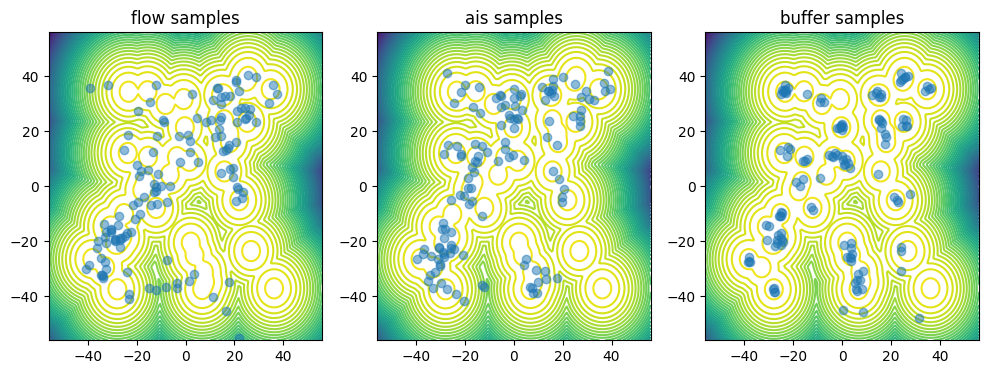

loss: 8.33435298526232, ess base: 0.2325631151973308,ess ais: 0.09199504958118554:  22%|██████████████████████▎                                                                             | 892/4000 [02:44<22:04,  2.35it/s]

nan loss in replay step


loss: 9.475865384484429, ess base: 0.31436490945990386,ess ais: 0.0078125:  22%|████████████████████████▏                                                                                   | 894/4000 [02:44<15:12,  3.40it/s]

nan loss in replay step
nan loss in replay step


loss: 8.381798287357299, ess base: 0.191278625858714,ess ais: 0.05204451370977615:  22%|██████████████████████▍                                                                             | 896/4000 [02:45<16:25,  3.15it/s]

nan grad norm in replay step


loss: 7.878175607559602, ess base: 0.2735558604926221,ess ais: 0.10344372853670897:  22%|██████████████████████▏                                                                            | 898/4000 [02:46<13:49,  3.74it/s]

nan loss in replay step


loss: 7.745704659410686, ess base: 0.28840450361109243,ess ais: 0.18053778952136368:  22%|██████████████████████                                                                            | 899/4000 [02:46<13:02,  3.96it/s]

nan loss in replay step


loss: 7.846239153370519, ess base: 0.31272245953218347,ess ais: 0.1677649849735456:  23%|██████████████████████▎                                                                            | 901/4000 [02:46<12:05,  4.27it/s]

nan loss in replay step
nan loss in replay step


loss: 8.390225616365539, ess base: 0.23568765284948717,ess ais: 0.11940628455611632:  23%|██████████████████████                                                                            | 903/4000 [02:47<10:52,  4.75it/s]

nan loss in replay step
nan loss in replay step


loss: inf, ess base: 0.3061637446517093,ess ais: 0.04196940049561732:  23%|█████████████████████████▌                                                                                       | 905/4000 [02:47<10:18,  5.00it/s]

nan loss in replay step
nan loss in replay step


loss: 8.229927273114457, ess base: 0.25436666171282096,ess ais: 0.0756834404788313:  23%|██████████████████████▍                                                                            | 907/4000 [02:47<09:08,  5.64it/s]

nan loss in replay step


loss: 8.518060662787342, ess base: 0.2631701040135428,ess ais: 0.1265702609317434:  23%|██████████████████████▋                                                                             | 909/4000 [02:48<09:53,  5.21it/s]

nan loss in replay step
nan loss in replay step


loss: 8.902790796841186, ess base: 0.22539216577595872,ess ais: 0.05095626442522125:  23%|██████████████████████▎                                                                           | 911/4000 [02:48<09:45,  5.27it/s]

nan loss in replay step


loss: 8.558288619725513, ess base: 0.24890928181382574,ess ais: 0.08124351529218508:  23%|██████████████████████▎                                                                           | 913/4000 [02:49<10:10,  5.06it/s]

nan loss in replay step
nan loss in replay step


loss: 8.436120640089376, ess base: 0.3007964135848736,ess ais: 0.14844678550520637:  23%|██████████████████████▋                                                                            | 918/4000 [02:49<08:32,  6.01it/s]

nan loss in replay step
nan loss in replay step


loss: 8.40722315070237, ess base: 0.23742083500635255,ess ais: 0.09926449262421755:  23%|██████████████████████▊                                                                            | 920/4000 [02:50<09:12,  5.58it/s]

nan loss in replay step
nan loss in replay step


loss: 8.395086462765814, ess base: 0.2734753509857457,ess ais: 0.14579255585161702:  23%|██████████████████████▊                                                                            | 922/4000 [02:50<08:31,  6.02it/s]

nan loss in replay step
nan loss in replay step
nan loss in replay step


loss: 8.0847277054207, ess base: 0.26865213212737,ess ais: 0.1641083081854184:  23%|████████████████████████                                                                                | 924/4000 [02:50<09:05,  5.64it/s]

nan loss in replay step


loss: 7.927149327820179, ess base: 0.2478665261969658,ess ais: 0.14302145817972228:  23%|██████████████████████▉                                                                            | 926/4000 [02:51<09:39,  5.31it/s]

nan loss in replay step
nan loss in replay step


loss: 8.364197029257404, ess base: 0.0962931724922837,ess ais: 0.012561779578755318:  23%|██████████████████████▋                                                                           | 928/4000 [02:51<09:34,  5.35it/s]

nan loss in replay step
nan loss in replay step


loss: 7.566018032535731, ess base: 0.26926568933138434,ess ais: 0.0078125:  23%|█████████████████████████                                                                                   | 930/4000 [02:52<10:06,  5.06it/s]

nan loss in replay step


loss: 7.61204502399644, ess base: 0.2737058564999212,ess ais: 0.1044328536668007:  23%|███████████████████████▌                                                                             | 932/4000 [02:52<10:50,  4.72it/s]

nan loss in replay step
nan loss in replay step


loss: 8.471507245931623, ess base: 0.22395569513076896,ess ais: 0.007812500000344152:  23%|██████████████████████▋                                                                          | 933/4000 [02:52<10:05,  5.07it/s]

nan loss in replay step


loss: 9.137561189697625, ess base: 0.23135681459838808,ess ais: 0.1217452539429478:  23%|███████████████████████▏                                                                           | 935/4000 [02:53<10:16,  4.97it/s]

nan loss in replay step
nan loss in replay step


loss: 7.898491293993181, ess base: 0.3144419140282323,ess ais: 0.0078125:  23%|█████████████████████████▌                                                                                   | 937/4000 [02:53<09:53,  5.16it/s]

nan loss in replay step


loss: 7.808698728641294, ess base: 0.24559821633521886,ess ais: 0.007812500390460431:  23%|██████████████████████▊                                                                          | 939/4000 [02:54<10:03,  5.07it/s]

nan loss in replay step
nan loss in replay step


loss: 7.536034855130761, ess base: 0.2968365845899716,ess ais: 0.16356276024736188:  24%|███████████████████████▎                                                                           | 941/4000 [02:54<09:50,  5.18it/s]

nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 8.521810940959599, ess base: 0.21950305080878074,ess ais: 0.11306387442499578:  24%|███████████████████████                                                                           | 943/4000 [02:54<09:47,  5.20it/s]

nan loss in replay step


loss: 9.844039762435786, ess base: 0.08380693501023975,ess ais: 0.015650405012137315:  24%|██████████████████████▉                                                                          | 944/4000 [02:54<09:58,  5.10it/s]

nan grad norm in replay step
nan loss in replay step


loss: 11.84506645628217, ess base: 0.23039022883745744,ess ais: 0.08200005695623651:  24%|███████████████████████▏                                                                          | 946/4000 [02:55<09:43,  5.23it/s]

nan loss in replay step
nan loss in replay step


loss: 8.492986900496362, ess base: 0.2597573277109509,ess ais: 0.06849061295129587:  24%|███████████████████████▍                                                                           | 948/4000 [02:55<09:44,  5.22it/s]

nan loss in replay step
nan loss in replay step


loss: 9.71964434602982, ess base: 0.29251944376965733,ess ais: 0.16883129688659057:  24%|███████████████████████▌                                                                           | 950/4000 [02:56<09:34,  5.31it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 9.192222499358596, ess base: 0.18988627381113213,ess ais: 0.047927779189924885:  24%|███████████████████████                                                                          | 952/4000 [02:56<09:50,  5.16it/s]

nan loss in replay step
nan loss in replay step


loss: 7.788663079764198, ess base: 0.09112590776250991,ess ais: 0.013498186436459631:  24%|███████████████████████▏                                                                         | 956/4000 [02:57<11:23,  4.45it/s]

nan loss in replay step


loss: 8.71388208044998, ess base: 0.23567658655253879,ess ais: 0.0729277736724175:  24%|███████████████████████▉                                                                            | 958/4000 [02:58<14:03,  3.61it/s]

nan loss in replay step


loss: 12415.281357397755, ess base: 0.2245008796178808,ess ais: 0.07304407418445749:  24%|███████████████████████▍                                                                          | 959/4000 [02:58<12:55,  3.92it/s]

nan loss in replay step
nan loss in replay step


loss: 12.625757150655847, ess base: 0.23349848178685134,ess ais: 0.07229317928402194:  24%|███████████████████████▎                                                                         | 960/4000 [02:58<13:08,  3.85it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 12.03041400412384, ess base: 0.20323440007642768,ess ais: 0.008727791392746756:  24%|███████████████████████▎                                                                         | 962/4000 [02:59<15:40,  3.23it/s]

nan loss in replay step
nan loss in replay step


loss: 7.974748565750108, ess base: 0.1841781025466743,ess ais: 0.0511879048574554:  24%|████████████████████████                                                                            | 964/4000 [02:59<11:44,  4.31it/s]

nan loss in replay step


loss: 8.109329015271317, ess base: 0.23152175705647352,ess ais: 0.042013230197862204:  24%|███████████████████████▍                                                                         | 966/4000 [03:00<10:58,  4.61it/s]

nan loss in replay step


loss: 8.098274778427813, ess base: 0.2962675780142748,ess ais: 0.17094732844894364:  24%|███████████████████████▉                                                                           | 968/4000 [03:00<10:42,  4.72it/s]

nan grad norm in replay step
nan loss in replay step


loss: 8.422504133433122, ess base: 0.06493787016788569,ess ais: 0.010423090329161942:  24%|███████████████████████▌                                                                         | 970/4000 [03:00<10:00,  5.05it/s]

nan loss in replay step
nan loss in replay step


loss: 8.019131777669397, ess base: 0.21608342888558113,ess ais: 0.10389371868219804:  24%|███████████████████████▊                                                                          | 972/4000 [03:01<08:32,  5.91it/s]

nan loss in replay step
nan loss in replay step


loss: 8.26983460485623, ess base: 0.21670093988221378,ess ais: 0.049444048380205566:  24%|███████████████████████▊                                                                          | 974/4000 [03:01<08:03,  6.26it/s]

nan loss in replay step
nan loss in replay step


loss: 7.79783726367495, ess base: 0.2598544470553901,ess ais: 0.007815661544410811:  24%|████████████████████████▏                                                                          | 976/4000 [03:01<07:38,  6.59it/s]

nan loss in replay step
nan loss in replay step


loss: 7.680479952024417, ess base: 0.11495911880863056,ess ais: 0.0078125:  24%|██████████████████████████▍                                                                                 | 978/4000 [03:02<08:45,  5.75it/s]

nan loss in replay step
nan loss in replay step


loss: 7.932207519637053, ess base: 0.2694358897200759,ess ais: 0.14933305559829468:  25%|████████████████████████▎                                                                          | 982/4000 [03:02<09:45,  5.16it/s]

nan loss in replay step
nan loss in replay step


loss: 8.127609125626131, ess base: 0.32362292261012704,ess ais: 0.17994918926410497:  25%|████████████████████████                                                                          | 984/4000 [03:03<09:39,  5.21it/s]

nan loss in replay step
nan loss in replay step


loss: 30.609910484419327, ess base: 0.2571683831098692,ess ais: 0.167078755050847:  25%|████████████████████████▋                                                                           | 987/4000 [03:03<09:45,  5.15it/s]

nan loss in replay step
nan loss in replay step


loss: 8.722628708789797, ess base: 0.2699579424324778,ess ais: 0.14193386236026234:  25%|████████████████████████▍                                                                          | 989/4000 [03:04<09:32,  5.26it/s]

nan loss in replay step
nan loss in replay step


loss: 8.398803549054074, ess base: 0.30509576380948533,ess ais: 0.0078125:  25%|██████████████████████████▊                                                                                 | 991/4000 [03:04<09:24,  5.33it/s]

nan loss in replay step
nan loss in replay step


loss: 8.806334384376884, ess base: 0.1960178691016053,ess ais: 0.028562305864177275:  25%|████████████████████████▎                                                                         | 993/4000 [03:04<09:21,  5.36it/s]

nan loss in replay step


loss: 2466.7426977817568, ess base: 0.28544328449430384,ess ais: 0.12939985507106613:  25%|████████████████████████▏                                                                        | 995/4000 [03:05<09:56,  5.04it/s]

nan loss in replay step
nan loss in replay step


loss: 9.439151843909798, ess base: 0.29368824880316485,ess ais: 0.15266979858956647:  25%|████████████████████████▍                                                                         | 998/4000 [03:06<09:51,  5.08it/s]

nan loss in replay step
nan loss in replay step


loss: 17.26959182752535, ess base: 0.21669359409182679,ess ais: 0.0775690214144373:  25%|████████████████████████▌                                                                         | 1001/4000 [03:06<10:45,  4.65it/s]

nan grad norm in replay step
nan loss in replay step


loss: 12.231045967954106, ess base: 0.18846068568918403,ess ais: 0.06254404187334194:  25%|████████████████████████                                                                        | 1003/4000 [03:07<09:41,  5.15it/s]

nan loss in replay step
nan loss in replay step


loss: 8.059693105710247, ess base: 0.18531966663405533,ess ais: 0.06661476369918666:  25%|████████████████████████▎                                                                        | 1004/4000 [03:07<09:45,  5.12it/s]

nan loss in replay step
nan loss in replay step


loss: 9.55808933390458, ess base: 0.24071628894380462,ess ais: 0.11135918905689494:  25%|████████████████████████▋                                                                         | 1006/4000 [03:07<09:38,  5.18it/s]

nan loss in replay step


loss: 7.367499609620153, ess base: 0.2905513895092202,ess ais: 0.1906974061362569:  25%|████████████████████████▉                                                                          | 1008/4000 [03:07<09:32,  5.22it/s]

nan loss in replay step
nan loss in replay step


loss: 7.915210768343063, ess base: 0.2126323700840429,ess ais: 0.04781578009731467:  25%|████████████████████████▊                                                                         | 1012/4000 [03:08<09:35,  5.19it/s]

nan loss in replay step
nan loss in replay step


loss: 8.58394782183946, ess base: 0.24610339708360027,ess ais: 0.0078125:  25%|███████████████████████████▍                                                                                | 1017/4000 [03:09<09:34,  5.19it/s]

nan loss in replay step
nan loss in replay step


loss: 8.304043338408569, ess base: 0.2366119877254238,ess ais: 0.10678938635616998:  25%|████████████████████████▉                                                                         | 1019/4000 [03:10<09:04,  5.47it/s]

nan loss in replay step
nan loss in replay step


loss: 9.247805111153271, ess base: 0.29149162477529666,ess ais: 0.14755972033795864:  26%|████████████████████████▊                                                                        | 1022/4000 [03:10<09:20,  5.31it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.432004784615849, ess base: 0.2939603803374374,ess ais: 0.007812500008280016:  26%|████████████████████████▊                                                                        | 1023/4000 [03:10<09:04,  5.47it/s]

nan loss in replay step


loss: 7.527900992862382, ess base: 0.2364152442135053,ess ais: 0.12293012452646956:  26%|█████████████████████████                                                                         | 1025/4000 [03:11<09:08,  5.42it/s]

nan loss in replay step
nan loss in replay step


loss: 8.097193943431346, ess base: 0.27864515805317935,ess ais: 0.15312677607014122:  26%|████████████████████████▉                                                                        | 1027/4000 [03:11<08:00,  6.19it/s]

nan loss in replay step


loss: 8.086523399256716, ess base: 0.21035311032358212,ess ais: 0.038231311800395976:  26%|████████████████████████▋                                                                       | 1030/4000 [03:11<07:49,  6.33it/s]

nan loss in replay step
nan loss in replay step


loss: 7.771517266442675, ess base: 0.2512817812155103,ess ais: 0.11885976945111516:  26%|█████████████████████████▎                                                                        | 1032/4000 [03:12<07:52,  6.28it/s]

nan loss in replay step
nan loss in replay step


loss: 8.037643724242548, ess base: 0.2628233771744921,ess ais: 0.024790543735436755:  26%|█████████████████████████                                                                        | 1034/4000 [03:12<08:06,  6.10it/s]

nan loss in replay step


loss: 7.729996647772021, ess base: 0.22923381316798858,ess ais: 0.0385561755982283:  26%|█████████████████████████▍                                                                        | 1036/4000 [03:12<08:21,  5.91it/s]

nan loss in replay step
nan loss in replay step


loss: 7.685258139997958, ess base: 0.26249996953096627,ess ais: 0.12178330032365858:  26%|█████████████████████████▏                                                                       | 1040/4000 [03:13<08:04,  6.10it/s]

nan loss in replay step


loss: 8.55510428201156, ess base: 0.19223176924171265,ess ais: 0.05282386653946636:  26%|█████████████████████████▌                                                                        | 1043/4000 [03:14<08:18,  5.93it/s]

nan loss in replay step


loss: 7.787541092813349, ess base: 0.2101385001491515,ess ais: 0.09739977419443095:  26%|█████████████████████████▌                                                                        | 1045/4000 [03:14<08:12,  6.00it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step


loss: 8.011190055306278, ess base: 0.28279866504262047,ess ais: 0.11792576253622142:  26%|█████████████████████████▍                                                                       | 1047/4000 [03:14<08:00,  6.14it/s]

nan loss in replay step
nan loss in replay step


loss: 8.801033792695947, ess base: 0.1294585617299163,ess ais: 0.08441412641054079:  26%|█████████████████████████▋                                                                        | 1049/4000 [03:15<07:52,  6.24it/s]

nan loss in replay step
nan loss in replay step


loss: 8.225821360197944, ess base: 0.3212746871643429,ess ais: 0.00782301296719661:  26%|█████████████████████████▋                                                                        | 1051/4000 [03:15<07:34,  6.49it/s]

nan loss in replay step
nan loss in replay step


loss: 8.86717809470829, ess base: 0.2679218949586204,ess ais: 0.15068271425766067:  26%|██████████████████████████                                                                         | 1052/4000 [03:15<07:37,  6.44it/s]

nan loss in replay step
nan loss in replay step


loss: 7.915782116361442, ess base: 0.2998447284007681,ess ais: 0.18403339393062754:  26%|█████████████████████████▊                                                                        | 1054/4000 [03:15<07:39,  6.41it/s]

nan loss in replay step
nan loss in replay step


loss: 7.725836465957648, ess base: 0.3382715934668767,ess ais: 0.2218113719129986:  26%|██████████████████████████▏                                                                        | 1056/4000 [03:16<06:09,  7.97it/s]

nan loss in replay step
nan loss in replay step
nan loss in replay step


loss: 7.890558577175246, ess base: 0.29496314547738023,ess ais: 0.15452365941483667:  26%|█████████████████████████▋                                                                       | 1059/4000 [03:16<06:34,  7.45it/s]

nan loss in replay step
nan loss in replay step


loss: 18.310825539192734, ess base: 0.2690712274166867,ess ais: 0.17657979190267004:  27%|█████████████████████████▊                                                                       | 1063/4000 [03:17<06:38,  7.38it/s]

nan loss in replay step


loss: 8.03290748214462, ess base: 0.2517026743359877,ess ais: 0.017544150337778282:  27%|██████████████████████████                                                                        | 1066/4000 [03:17<06:18,  7.74it/s]

nan loss in replay step


loss: 8.131718377464043, ess base: 0.25045457266353516,ess ais: 0.1384440452117687:  27%|██████████████████████████▏                                                                       | 1068/4000 [03:17<06:56,  7.04it/s]

nan loss in replay step
nan loss in replay step
nan loss in replay step


loss: 8.667563516620007, ess base: 0.3007952386347139,ess ais: 0.15133589939725964:  27%|██████████████████████████▏                                                                       | 1071/4000 [03:18<07:27,  6.55it/s]

nan loss in replay step


loss: 8.667936255218894, ess base: 0.29818517991758475,ess ais: 0.18220094334187031:  27%|██████████████████████████                                                                       | 1074/4000 [03:18<06:38,  7.34it/s]

nan loss in replay step
nan grad norm in replay step


loss: 8.083677296146874, ess base: 0.2264536173933091,ess ais: 0.06739753985884274:  27%|██████████████████████████▎                                                                       | 1076/4000 [03:18<07:10,  6.79it/s]

nan loss in replay step
nan loss in replay step


loss: 8.395700211180094, ess base: 0.27855123508126806,ess ais: 0.008138399348068294:  27%|█████████████████████████▊                                                                      | 1078/4000 [03:19<07:55,  6.14it/s]

nan loss in replay step


loss: 7.949064511516218, ess base: 0.23749199995775977,ess ais: 0.07022110991230425:  27%|██████████████████████████▏                                                                      | 1080/4000 [03:19<07:57,  6.11it/s]

nan loss in replay step
nan grad norm in replay step


loss: 8.032931429681096, ess base: 0.25443666453836417,ess ais: 0.126428016456075:  27%|██████████████████████████▊                                                                        | 1082/4000 [03:19<08:18,  5.85it/s]

nan loss in replay step
nan loss in replay step


loss: 7.9160881574255395, ess base: 0.23881231344966403,ess ais: 0.12107607649922322:  27%|█████████████████████████▉                                                                      | 1083/4000 [03:20<08:19,  5.84it/s]

nan loss in replay step


loss: 8.478942871337551, ess base: 0.24022689365698544,ess ais: 0.07611041973156084:  27%|██████████████████████████▎                                                                      | 1086/4000 [03:20<06:44,  7.20it/s]

nan loss in replay step
nan loss in replay step


loss: 8.672593575252861, ess base: 0.2230747266312975,ess ais: 0.0909377414598898:  27%|██████████████████████████▉                                                                        | 1087/4000 [03:20<07:03,  6.87it/s]

nan loss in replay step


loss: 7.823178546297342, ess base: 0.2561852998094727,ess ais: 0.0852906152404632:  27%|██████████████████████████▉                                                                        | 1089/4000 [03:21<11:34,  4.19it/s]

nan loss in replay step


loss: 7.996101893851909, ess base: 0.1824877796045102,ess ais: 0.008022901953684481:  27%|██████████████████████████▍                                                                      | 1090/4000 [03:21<10:02,  4.83it/s]

nan loss in replay step
nan loss in replay step


loss: 8.051791405657593, ess base: 0.28501607519611394,ess ais: 0.08347864105269169:  28%|███████████████████████████                                                                      | 1114/4000 [03:26<08:59,  5.35it/s]

nan loss in replay step
nan loss in replay step


loss: 8.283983149575223, ess base: 0.2594582260490215,ess ais: 0.09526227772099156:  28%|███████████████████████████▎                                                                      | 1116/4000 [03:26<09:38,  4.99it/s]

nan grad norm in replay step
nan loss in replay step


loss: 16.25647928686262, ess base: 0.31854894123452865,ess ais: 0.1809732121193979:  28%|███████████████████████████▍                                                                      | 1119/4000 [03:27<11:29,  4.18it/s]

nan loss in replay step


loss: 10.69976014861836, ess base: 0.232468978127397,ess ais: 0.08434211779491001:  28%|███████████████████████████▉                                                                       | 1128/4000 [03:29<10:40,  4.49it/s]

nan loss in replay step


loss: 7.862756053298163, ess base: 0.2988934988899131,ess ais: 0.11778448394115286:  28%|███████████████████████████▋                                                                      | 1129/4000 [03:30<13:17,  3.60it/s]

nan loss in replay step


loss: 9.19719299414917, ess base: 0.24685940535293574,ess ais: 0.03695669425161812:  28%|███████████████████████████▋                                                                      | 1131/4000 [03:30<11:12,  4.27it/s]

nan loss in replay step
nan loss in replay step


loss: 8.41943171240722, ess base: 0.25731872167265146,ess ais: 0.12325956560160871:  28%|███████████████████████████▊                                                                      | 1134/4000 [03:30<09:18,  5.13it/s]

nan loss in replay step


loss: 7.454797535170192, ess base: 0.33179979288299044,ess ais: 0.17608995692679225:  28%|███████████████████████████▌                                                                     | 1136/4000 [03:31<09:33,  4.99it/s]

nan loss in replay step


loss: 7.835166852757732, ess base: 0.3064728565424887,ess ais: 0.1740050607475913:  28%|████████████████████████████▏                                                                      | 1137/4000 [03:31<10:01,  4.76it/s]

nan grad norm in replay step


loss: 7.562284143244608, ess base: 0.24930882910798308,ess ais: 0.1220517243997745:  28%|███████████████████████████▉                                                                      | 1138/4000 [03:31<10:33,  4.52it/s]

nan grad norm in replay step


loss: 9.897020681427147, ess base: 0.19561421470341034,ess ais: 0.10915379653149032:  28%|███████████████████████████▌                                                                     | 1139/4000 [03:31<10:01,  4.76it/s]

nan loss in replay step
nan loss in replay step


loss: 8.671969935313369, ess base: 0.2891919516867557,ess ais: 0.1234420457280866:  29%|████████████████████████████▎                                                                      | 1145/4000 [03:33<09:08,  5.21it/s]

nan loss in replay step
nan loss in replay step


loss: 8.070822031472401, ess base: 0.27225034029728795,ess ais: 0.15227799613286475:  29%|███████████████████████████▊                                                                     | 1147/4000 [03:33<09:04,  5.24it/s]

nan loss in replay step
nan loss in replay step


loss: 9.364838994401332, ess base: 0.2752643777938125,ess ais: 0.0078125:  29%|███████████████████████████████                                                                             | 1149/4000 [03:33<08:37,  5.51it/s]

nan loss in replay step


loss: 7.975443809772684, ess base: 0.26599593495228563,ess ais: 0.13765667683573904:  29%|███████████████████████████▉                                                                     | 1151/4000 [03:34<09:21,  5.07it/s]

nan loss in replay step
nan loss in replay step


loss: 8.053802366405392, ess base: 0.2727962604606842,ess ais: 0.15769809758947:  29%|█████████████████████████████                                                                        | 1153/4000 [03:35<13:45,  3.45it/s]

nan loss in replay step
nan loss in replay step


loss: 8.188074774044502, ess base: 0.23662083324131514,ess ais: 0.09788678065534244:  29%|████████████████████████████                                                                     | 1155/4000 [03:35<16:32,  2.87it/s]

nan loss in replay step


loss: 7.803974156591565, ess base: 0.2636865578378202,ess ais: 0.1391934767955973:  29%|████████████████████████████▋                                                                      | 1157/4000 [03:36<13:31,  3.51it/s]

nan loss in replay step
nan loss in replay step


loss: 8.717732282014662, ess base: 0.2693856315930779,ess ais: 0.10517187974887342:  29%|████████████████████████████▍                                                                     | 1162/4000 [03:37<10:06,  4.68it/s]

nan loss in replay step
nan loss in replay step


loss: 9.760545445436279, ess base: 0.2819455862198105,ess ais: 0.0078128437974169:  29%|████████████████████████████▊                                                                      | 1164/4000 [03:37<09:19,  5.07it/s]

nan loss in replay step


loss: 8.39250088457655, ess base: 0.2057327317500927,ess ais: 0.08305597565210716:  29%|████████████████████████████▊                                                                      | 1166/4000 [03:38<08:58,  5.26it/s]

nan loss in replay step
nan loss in replay step


loss: 8.190470241586423, ess base: 0.31131710475762403,ess ais: 0.1580535405111432:  29%|████████████████████████████▋                                                                     | 1173/4000 [03:39<06:58,  6.75it/s]

nan loss in replay step


loss: 8.338500516313161, ess base: 0.3435592478261646,ess ais: 0.19627396223181123:  29%|████████████████████████████▊                                                                     | 1175/4000 [03:39<07:47,  6.05it/s]

nan loss in replay step


loss: 7.502024285234714, ess base: 0.323491851025735,ess ais: 0.19345474258009396:  29%|█████████████████████████████▏                                                                     | 1177/4000 [03:39<08:07,  5.79it/s]

nan loss in replay step
nan loss in replay step


loss: 7.899902911717766, ess base: 0.32065043481403566,ess ais: 0.18148106739909098:  30%|████████████████████████████▋                                                                    | 1183/4000 [03:41<08:39,  5.42it/s]

nan loss in replay step
nan loss in replay step


loss: 7.776461619830296, ess base: 0.3049226614506069,ess ais: 0.17357039266482838:  30%|█████████████████████████████                                                                     | 1185/4000 [03:41<08:22,  5.60it/s]

nan loss in replay step
nan loss in replay step


loss: 7.856558991339451, ess base: 0.3042702766702508,ess ais: 0.14066143774284706:  30%|█████████████████████████████                                                                     | 1187/4000 [03:41<08:09,  5.74it/s]

nan loss in replay step
nan loss in replay step


loss: 7.875450626413106, ess base: 0.28747156200645085,ess ais: 0.0078125:  30%|███████████████████████████████▊                                                                           | 1189/4000 [03:42<08:03,  5.81it/s]

nan loss in replay step
nan loss in replay step


loss: 7.662202998590672, ess base: 0.2163173455729966,ess ais: 0.0078125:  30%|████████████████████████████████▏                                                                           | 1191/4000 [03:42<08:01,  5.84it/s]

nan loss in replay step
nan loss in replay step


loss: 8.32052990891832, ess base: 0.2512927245374245,ess ais: 0.1201103692999911:  30%|█████████████████████████████▊                                                                      | 1193/4000 [03:42<07:58,  5.86it/s]

nan loss in replay step
nan loss in replay step


loss: 7.979951418903607, ess base: 0.2175876365051827,ess ais: 0.09334672853462701:  30%|█████████████████████████████▎                                                                    | 1195/4000 [03:43<08:01,  5.82it/s]

nan loss in replay step
nan loss in replay step


loss: 8.538203153750963, ess base: 0.2745528554505171,ess ais: 0.14117825187372496:  30%|█████████████████████████████▎                                                                    | 1197/4000 [03:43<07:58,  5.85it/s]

nan loss in replay step


loss: 9.867566630701736, ess base: 0.2570495298488944,ess ais: 0.06981372004803289:  30%|█████████████████████████████▍                                                                    | 1199/4000 [03:43<08:41,  5.37it/s]

nan loss in replay step
nan loss in replay step


loss: 7.84669675346664, ess base: 0.25015762333052505,ess ais: 0.0078125:  30%|████████████████████████████████▍                                                                           | 1201/4000 [03:44<08:26,  5.53it/s]

nan loss in replay step
nan loss in replay step


loss: 7.790164609242801, ess base: 0.28933887326701746,ess ais: 0.08805842966414416:  30%|█████████████████████████████▏                                                                   | 1203/4000 [03:44<08:18,  5.61it/s]

nan loss in replay step


loss: 7.750691746365733, ess base: 0.23756730981150723,ess ais: 0.11072793354913188:  30%|█████████████████████████████▏                                                                   | 1206/4000 [03:45<09:29,  4.90it/s]

nan loss in replay step


loss: 8.641038663584004, ess base: 0.2412690558353158,ess ais: 0.10483429577362625:  30%|█████████████████████████████▌                                                                    | 1207/4000 [03:45<09:24,  4.95it/s]

nan loss in replay step
nan loss in replay step


loss: 14.017416417950946, ess base: 0.26016019690286685,ess ais: 0.10132804649407844:  30%|█████████████████████████████                                                                   | 1209/4000 [03:45<08:51,  5.25it/s]

nan loss in replay step


loss: 12.383191167793504, ess base: 0.24257817112971894,ess ais: 0.1205667057194341:  30%|█████████████████████████████▎                                                                   | 1210/4000 [03:45<08:53,  5.23it/s]

nan loss in replay step
nan loss in replay step


loss: 8.077644089741794, ess base: 0.2895619716530593,ess ais: 0.1708201579991694:  30%|██████████████████████████████                                                                     | 1215/4000 [03:47<14:34,  3.18it/s]

nan loss in replay step


loss: 7.540797053906403, ess base: 0.29950158228663626,ess ais: 0.13985789155613784:  30%|█████████████████████████████▍                                                                   | 1216/4000 [03:48<13:21,  3.47it/s]

nan loss in replay step


loss: 8.105492257847395, ess base: 0.28758649437934436,ess ais: 0.0937476382454452:  30%|█████████████████████████████▉                                                                    | 1220/4000 [03:49<11:46,  3.94it/s]

nan loss in replay step


loss: 7.9134221033395304, ess base: 0.28573930379576523,ess ais: 0.1588969959429398:  31%|█████████████████████████████▌                                                                   | 1221/4000 [03:49<12:06,  3.83it/s]

nan loss in replay step


loss: 8.775787812359695, ess base: 0.27462442881994903,ess ais: 0.1468030218445474:  31%|██████████████████████████████                                                                    | 1226/4000 [03:50<09:59,  4.63it/s]

nan loss in replay step
nan loss in replay step


loss: 8.178440567377026, ess base: 0.27654805986347325,ess ais: 0.00793479127106386:  31%|█████████████████████████████▊                                                                   | 1229/4000 [03:51<10:36,  4.36it/s]

nan loss in replay step
nan loss in replay step


loss: 8.175098863927115, ess base: 0.24003745893870623,ess ais: 0.017080013503705412:  31%|█████████████████████████████▌                                                                  | 1232/4000 [03:52<14:59,  3.08it/s]

nan loss in replay step


loss: 11.891353665253153, ess base: 0.2815948999757354,ess ais: 0.09617253824226851:  31%|█████████████████████████████▉                                                                   | 1234/4000 [03:52<12:53,  3.57it/s]

nan loss in replay step


loss: 9.807891497481519, ess base: 0.3043927192629019,ess ais: 0.13743801675585765:  31%|██████████████████████████████▎                                                                   | 1235/4000 [03:52<11:53,  3.88it/s]

nan loss in replay step


loss: 10.273666741089789, ess base: 0.2586010985164284,ess ais: 0.00785983937661024:  31%|█████████████████████████████▉                                                                   | 1236/4000 [03:52<11:07,  4.14it/s]

nan loss in replay step
nan loss in replay step


loss: 10.171561045524374, ess base: 0.3001063433441818,ess ais: 0.1644083519362288:  31%|██████████████████████████████▎                                                                   | 1238/4000 [03:53<09:46,  4.71it/s]

nan loss in replay step
nan loss in replay step


loss: 7.66730970772519, ess base: 0.278017836209868,ess ais: 0.0078125:  31%|██████████████████████████████████▏                                                                           | 1245/4000 [03:54<09:29,  4.83it/s]

nan loss in replay step


loss: 9.41889590624871, ess base: 0.3121109644955406,ess ais: 0.19910539435519445:  31%|██████████████████████████████▊                                                                    | 1247/4000 [03:55<10:08,  4.53it/s]

nan loss in replay step


loss: 1800906840126.787, ess base: 0.266609526683371,ess ais: 0.0078125:  31%|██████████████████████████████████                                                                           | 1248/4000 [03:55<10:07,  4.53it/s]

nan loss in replay step


loss: 5099057539589.936, ess base: 0.281009677405033,ess ais: 0.08977571320111587:  31%|██████████████████████████████▉                                                                    | 1249/4000 [03:55<10:37,  4.32it/s]

nan loss in replay step


loss: 7.960466914859618, ess base: 0.2941549713508749,ess ais: 0.010913640824492489:  31%|██████████████████████████████▍                                                                  | 1253/4000 [03:56<11:01,  4.15it/s]

nan loss in replay step


loss: 8.310568276294969, ess base: 0.3123858039462989,ess ais: 0.007818743253879053:  32%|██████████████████████████████▋                                                                  | 1263/4000 [03:58<10:03,  4.53it/s]

nan loss in replay step
nan loss in replay step


loss: 12.394422235322752, ess base: 0.2615644886566365,ess ais: 0.12979054995817113:  32%|██████████████████████████████▋                                                                  | 1265/4000 [03:59<09:28,  4.81it/s]

nan loss in replay step
nan loss in replay step


loss: 8.180959881190596, ess base: 0.2807885831761837,ess ais: 0.1082579350290866:  32%|███████████████████████████████▍                                                                   | 1269/4000 [04:00<09:27,  4.82it/s]

nan loss in replay step
nan loss in replay step


loss: 8.037192976288761, ess base: 0.2544810271983568,ess ais: 0.007850350073874444:  32%|██████████████████████████████▊                                                                  | 1271/4000 [04:00<08:56,  5.08it/s]

nan loss in replay step
nan loss in replay step


loss: 8.100431444496625, ess base: 0.2723523106612992,ess ais: 0.13548655352017333:  32%|███████████████████████████████▎                                                                  | 1279/4000 [04:02<09:15,  4.90it/s]

nan loss in replay step


loss: 10.258192513291986, ess base: 0.26287320990742996,ess ais: 0.13562477647644514:  33%|███████████████████████████████▌                                                                | 1317/4000 [04:10<10:59,  4.07it/s]

nan loss in replay step


loss: 8.239607996456005, ess base: 0.3051796723712655,ess ais: 0.15598147012803898:  33%|████████████████████████████████▎                                                                 | 1318/4000 [04:11<10:31,  4.25it/s]

nan loss in replay step
nan loss in replay step


loss: 8.14389477512783, ess base: 0.26598828649710554,ess ais: 0.06334678035296232:  33%|████████████████████████████████▎                                                                 | 1319/4000 [04:11<11:45,  3.80it/s]

nan loss in replay step


loss: 7.790986222875366, ess base: 0.32513362516526967,ess ais: 0.007812500088166354:  33%|███████████████████████████████▋                                                                | 1321/4000 [04:12<15:22,  2.90it/s]

nan loss in replay step
nan loss in replay step


loss: 7.5883870524787636, ess base: 0.33452827786713824,ess ais: 0.22192264303334036:  33%|███████████████████████████████▊                                                                | 1323/4000 [04:13<17:29,  2.55it/s]

nan loss in replay step


loss: 7.8337707952406355, ess base: 0.3182364430770113,ess ais: 0.19283488492734144:  33%|████████████████████████████████                                                                 | 1324/4000 [04:13<15:14,  2.93it/s]

nan loss in replay step


loss: 7.928738891691977, ess base: 0.29937552673433787,ess ais: 0.14413676023952296:  33%|████████████████████████████████▏                                                                | 1325/4000 [04:13<13:21,  3.34it/s]

nan loss in replay step


loss: 7.684078366133461, ess base: 0.27965587481551535,ess ais: 0.09359800392618836:  33%|████████████████████████████████▏                                                                | 1326/4000 [04:13<12:36,  3.54it/s]

nan loss in replay step


loss: 8.090505683441366, ess base: 0.20989944737879598,ess ais: 0.10174367212698192:  33%|████████████████████████████████▏                                                                | 1327/4000 [04:14<11:42,  3.81it/s]

nan loss in replay step


loss: 7.252666023172199, ess base: 0.2590173032603527,ess ais: 0.12395032166777048:  33%|████████████████████████████████▋                                                                 | 1333/4000 [04:16<14:12,  3.13it/s]

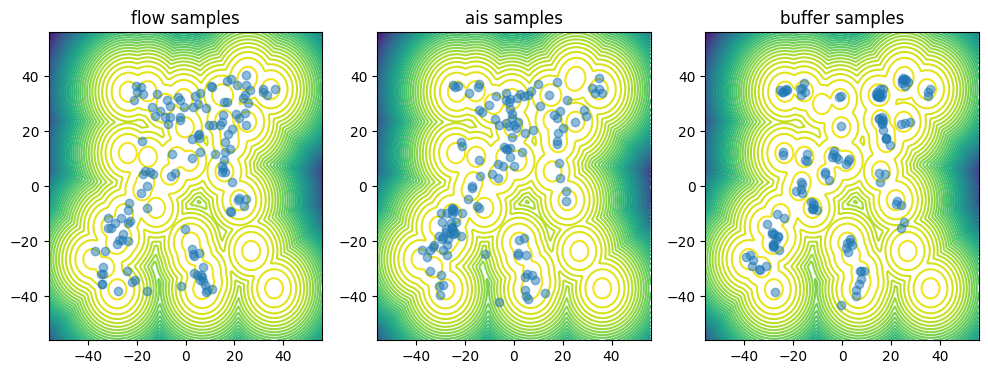

loss: 9.196917190841376, ess base: 0.3479673732218683,ess ais: 0.21843848122282133:  37%|████████████████████████████████████▌                                                             | 1494/4000 [04:50<07:01,  5.95it/s]

nan loss in replay step


loss: 10.131693947632128, ess base: 0.30388220516091863,ess ais: 0.16789790076246827:  40%|██████████████████████████████████████▏                                                         | 1592/4000 [05:11<07:56,  5.05it/s]

nan loss in replay step


loss: 8.766951256420235, ess base: 0.24314026716893986,ess ais: 0.007898729317548165:  40%|██████████████████████████████████████▎                                                         | 1594/4000 [05:11<06:55,  5.79it/s]

nan loss in replay step
nan loss in replay step


loss: 9.249390310324582, ess base: 0.29391496478175905,ess ais: 0.17109114293700475:  40%|██████████████████████████████████████▋                                                          | 1596/4000 [05:12<07:26,  5.38it/s]

nan loss in replay step


loss: 7.72822614073386, ess base: 0.30302297041577525,ess ais: 0.17092739110252347:  40%|███████████████████████████████████████▏                                                          | 1597/4000 [05:12<06:50,  5.86it/s]

nan loss in replay step
nan loss in replay step


loss: 7.304353024445948, ess base: 0.32334894112363816,ess ais: 0.19224233724480191:  40%|██████████████████████████████████████▊                                                          | 1601/4000 [05:13<08:34,  4.67it/s]

nan loss in replay step


loss: 9.418174533529232, ess base: 0.38586341684833025,ess ais: 0.22283391741634662:  40%|██████████████████████████████████████▊                                                          | 1602/4000 [05:13<08:31,  4.69it/s]

nan loss in replay step


loss: 9.572424791924348, ess base: 0.3848307613631146,ess ais: 0.202256589212045:  44%|████████████████████████████████████████████▍                                                       | 1775/4000 [05:53<09:55,  3.74it/s]

nan loss in replay step


loss: 8.092368394318145, ess base: 0.32444571899500513,ess ais: 0.18042107018741085:  44%|███████████████████████████████████████████                                                      | 1777/4000 [05:53<08:40,  4.27it/s]

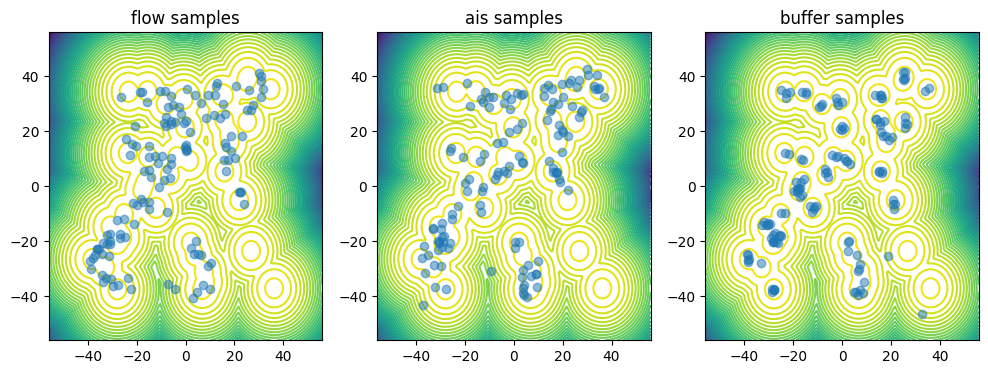

loss: 8.148057836509881, ess base: 0.3400246523429891,ess ais: 0.19137337909834473:  45%|███████████████████████████████████████████▋                                                      | 1781/4000 [05:55<12:43,  2.91it/s]

nan loss in replay step


loss: 8.30131719253542, ess base: 0.3118207811573685,ess ais: 0.050597687648767355:  45%|███████████████████████████████████████████▋                                                      | 1783/4000 [05:56<09:30,  3.89it/s]

nan loss in replay step


loss: 7.456662650151333, ess base: 0.34886273767413173,ess ais: 0.19668506783539563:  53%|██████████████████████████████████████████████████▉                                              | 2103/4000 [07:00<06:24,  4.94it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.787687455832707, ess base: 0.41878772302133294,ess ais: 0.007812500194153716:  56%|█████████████████████████████████████████████████████▎                                          | 2221/4000 [07:26<06:23,  4.63it/s]

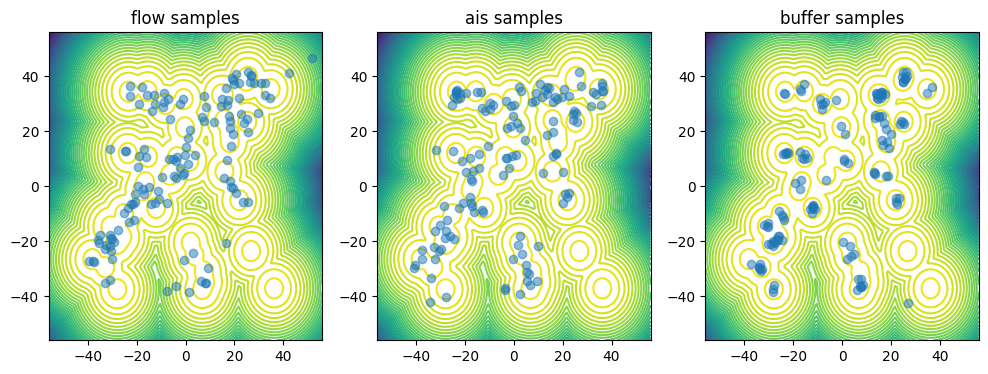

loss: 7.828494708055181, ess base: 0.3992362014929422,ess ais: 0.20760821788138573:  56%|██████████████████████████████████████████████████████▊                                           | 2235/4000 [07:31<06:31,  4.51it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 11.389519536828434, ess base: 0.3912296925168838,ess ais: 0.14093264833879268:  57%|██████████████████████████████████████████████████████▉                                          | 2267/4000 [07:36<04:43,  6.11it/s]

nan loss in replay step


loss: 10.237396116390812, ess base: 0.12482549825375953,ess ais: 0.01865707462840703:  57%|██████████████████████████████████████████████████████▍                                         | 2270/4000 [07:37<03:52,  7.44it/s]

nan loss in replay step


loss: 7.336047152475703, ess base: 0.36395449696496135,ess ais: 0.1824990902505059:  57%|███████████████████████████████████████████████████████▉                                          | 2281/4000 [07:38<03:48,  7.53it/s]

nan grad norm in replay step


loss: 9.438916948469021, ess base: 0.38823955211935546,ess ais: 0.23865352769651182:  58%|███████████████████████████████████████████████████████▉                                         | 2306/4000 [07:42<03:27,  8.15it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.549313452823174, ess base: 0.39837101644359785,ess ais: 0.2440371746406638:  58%|████████████████████████████████████████████████████████▉                                         | 2323/4000 [07:44<02:56,  9.51it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 19.294441656517215, ess base: 0.34353316434414055,ess ais: 0.1850393563654601:  59%|████████████████████████████████████████████████████████▊                                        | 2341/4000 [07:46<03:31,  7.86it/s]

nan grad norm in replay step


loss: 8.102865038628934, ess base: 0.41761168076477173,ess ais: 0.21370561690099993:  59%|████████████████████████████████████████████████████████▉                                        | 2350/4000 [07:48<03:16,  8.40it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.118652296964875, ess base: 0.3884188016043689,ess ais: 0.2298382091261691:  59%|██████████████████████████████████████████████████████████▍                                        | 2361/4000 [07:49<03:33,  7.67it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.216297169898402, ess base: 0.3972914593547365,ess ais: 0.24241184218207742:  59%|██████████████████████████████████████████████████████████                                        | 2371/4000 [07:51<04:04,  6.65it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.620162601689247, ess base: 0.3645183325739753,ess ais: 0.23011124816693654:  59%|██████████████████████████████████████████████████████████▎                                       | 2379/4000 [07:52<03:36,  7.48it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.8970888381535, ess base: 0.39791595613915365,ess ais: 0.17700388821352092:  60%|██████████████████████████████████████████████████████████▉                                        | 2381/4000 [07:52<04:00,  6.72it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.765254352552017, ess base: 0.3981736137859215,ess ais: 0.194049942346037:  60%|███████████████████████████████████████████████████████████▋                                        | 2388/4000 [07:53<04:12,  6.39it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 9.593882220289498, ess base: 0.3909021959129002,ess ais: 0.2378011407188316:  60%|███████████████████████████████████████████████████████████▎                                       | 2395/4000 [07:54<03:48,  7.01it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.873478711905107, ess base: 0.42538388393255916,ess ais: 0.22489248056239278:  60%|██████████████████████████████████████████████████████████▎                                      | 2404/4000 [07:55<03:47,  7.00it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.745346057721626, ess base: 0.33636519397196274,ess ais: 0.22809274254606435:  60%|██████████████████████████████████████████████████████████▋                                      | 2418/4000 [07:57<03:06,  8.47it/s]

3 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.570246437965654, ess base: 0.4701549574609493,ess ais: 0.3067733525214582:  61%|███████████████████████████████████████████████████████████▉                                       | 2423/4000 [07:58<04:28,  5.88it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.800901908041343, ess base: 0.31740398995291075,ess ais: 0.03452295245078731:  61%|██████████████████████████████████████████████████████████▊                                      | 2425/4000 [07:58<04:29,  5.84it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.667384136433505, ess base: 0.3878434996153601,ess ais: 0.21502876892429706:  61%|███████████████████████████████████████████████████████████▍                                      | 2428/4000 [07:59<03:52,  6.78it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.5650899438242165, ess base: 0.3647253002491618,ess ais: 0.22408884044751282:  61%|██████████████████████████████████████████████████████████▉                                      | 2430/4000 [07:59<03:46,  6.94it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.385156830453734, ess base: 0.34945252495126733,ess ais: 0.16413387482039202:  61%|███████████████████████████████████████████████████████████▎                                     | 2446/4000 [08:01<04:20,  5.96it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.743365115140847, ess base: 0.4007773121927828,ess ais: 0.24797366085063446:  61%|████████████████████████████████████████████████████████████▏                                     | 2455/4000 [08:03<04:17,  6.01it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.777824637944082, ess base: 0.2602182911135431,ess ais: 0.007874015748031496:  62%|███████████████████████████████████████████████████████████▊                                     | 2467/4000 [08:05<04:05,  6.23it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 7.631164545476536, ess base: 0.3793976096675995,ess ais: 0.21771776558155553:  62%|████████████████████████████████████████████████████████████▌                                     | 2470/4000 [08:06<04:05,  6.23it/s]

nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.554652133087977, ess base: 0.38034818890900646,ess ais: 0.1697025293362252:  62%|████████████████████████████████████████████████████████████▌                                     | 2473/4000 [08:06<04:13,  6.02it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step


loss: 8.677810933658428, ess base: 0.320801280640722,ess ais: 0.14717899192763567:  62%|█████████████████████████████████████████████████████████████▎                                     | 2477/4000 [08:07<04:04,  6.22it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step


loss: 7.668395881832838, ess base: 0.3880027573628248,ess ais: 0.22197799943978852:  62%|████████████████████████████████████████████████████████████▊                                     | 2480/4000 [08:07<04:12,  6.03it/s]

nan loss in replay step


loss: 489484187891114.8, ess base: 0.4154794038800439,ess ais: 0.2925626657254716:  62%|█████████████████████████████████████████████████████████████▍                                     | 2481/4000 [08:07<04:20,  5.83it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.529195008401599, ess base: 0.29130590547942975,ess ais: 0.12506839643594037:  62%|████████████████████████████████████████████████████████████▏                                    | 2484/4000 [08:08<03:58,  6.37it/s]

nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.332147756303, ess base: 0.30669114234084804,ess ais: 0.09713053711739164:  62%|██████████████████████████████████████████████████████████████▏                                     | 2485/4000 [08:08<04:10,  6.05it/s]

nan loss in replay step
nan loss in replay step


loss: 8.064760144767515, ess base: 0.3583211356325681,ess ais: 0.1400472778882648:  62%|█████████████████████████████████████████████████████████████▌                                     | 2489/4000 [08:09<03:58,  6.33it/s]

nan loss in replay step


loss: 13.086092494065388, ess base: 0.34246915598011546,ess ais: 0.1574032985056795:  62%|████████████████████████████████████████████████████████████▍                                    | 2492/4000 [08:09<04:14,  5.92it/s]

nan loss in replay step
nan loss in replay step


loss: 8.218115773010291, ess base: 0.4316741033490638,ess ais: 0.26546272744777805:  63%|█████████████████████████████████████████████████████████████▎                                    | 2502/4000 [08:11<03:23,  7.37it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.596508504449389, ess base: 0.3543875666883296,ess ais: 0.1689293607852371:  63%|██████████████████████████████████████████████████████████████▏                                    | 2512/4000 [08:12<03:40,  6.73it/s]

nan loss in replay step
nan loss in replay step


loss: 8.02100836582014, ess base: 0.3944605813201163,ess ais: 0.2122787574338167:  63%|██████████████████████████████████████████████████████████████▉                                     | 2516/4000 [08:13<03:37,  6.83it/s]

nan loss in replay step


loss: 606256.0674502647, ess base: 0.3882001774070132,ess ais: 0.21517549429925573:  63%|█████████████████████████████████████████████████████████████▋                                    | 2518/4000 [08:13<03:49,  6.46it/s]

nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.136449429840267, ess base: 0.13113627193915803,ess ais: 0.017738865960889975:  63%|████████████████████████████████████████████████████████████▌                                   | 2524/4000 [08:14<04:02,  6.09it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.15645609535888, ess base: 0.4483293905169493,ess ais: 0.13777686237421902:  64%|██████████████████████████████████████████████████████████████▉                                    | 2543/4000 [08:16<03:21,  7.24it/s]

nan loss in replay step


loss: 7.646153362898627, ess base: 0.44899729490758505,ess ais: 0.30115766853889425:  64%|█████████████████████████████████████████████████████████████▊                                   | 2548/4000 [08:17<03:52,  6.23it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.63468759016314, ess base: 0.3121312942833204,ess ais: 0.10465710187596894:  64%|███████████████████████████████████████████████████████████████                                    | 2550/4000 [08:18<03:24,  7.10it/s]

nan loss in replay step
nan loss in replay step
nan loss in replay step


loss: 7.249728743241145, ess base: 0.35214103256118034,ess ais: 0.19701908317233643:  64%|█████████████████████████████████████████████████████████████▉                                   | 2552/4000 [08:18<03:06,  7.76it/s]

nan loss in replay step


loss: 8.061157209161113, ess base: 0.3260088831133935,ess ais: 0.09011264307792526:  64%|██████████████████████████████████████████████████████████████▋                                   | 2560/4000 [08:19<03:29,  6.88it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.830290851665883, ess base: 0.47658775725133545,ess ais: 0.331070570573118:  64%|███████████████████████████████████████████████████████████████▌                                   | 2566/4000 [08:20<02:59,  7.98it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.724328078826561, ess base: 0.3876645542537532,ess ais: 0.26214348791531666:  64%|██████████████████████████████████████████████████████████████▉                                   | 2571/4000 [08:20<03:33,  6.69it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.968486974606392, ess base: 0.3636908722293362,ess ais: 0.19038812970658614:  64%|███████████████████████████████████████████████████████████████                                   | 2573/4000 [08:21<03:34,  6.65it/s]

nan loss in replay step
2 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 19.046841281836638, ess base: 0.338794020895147,ess ais: 0.15227088765511404:  64%|███████████████████████████████████████████████████████████████                                   | 2575/4000 [08:21<03:25,  6.93it/s]

nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.68848430821689, ess base: 0.3929576919426951,ess ais: 0.21458833928710866:  64%|███████████████████████████████████████████████████████████████▊                                   | 2577/4000 [08:21<03:30,  6.77it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.218960190561994, ess base: 0.393272205491616,ess ais: 0.2402733490120099:  65%|████████████████████████████████████████████████████████████████▋                                   | 2589/4000 [08:23<02:55,  8.06it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 10.201640886083624, ess base: 0.43934484392797646,ess ais: 0.18682350704877607:  65%|██████████████████████████████████████████████████████████████▎                                 | 2594/4000 [08:23<03:12,  7.31it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 39.37128979386443, ess base: 0.3122839057093801,ess ais: 0.007919932077446517:  65%|██████████████████████████████████████████████████████████████▉                                  | 2597/4000 [08:24<02:52,  8.13it/s]

nan loss in replay step


loss: 58.75022137931012, ess base: 0.3149730262011191,ess ais: 0.18436392839473079:  65%|███████████████████████████████████████████████████████████████▋                                  | 2599/4000 [08:24<03:18,  7.05it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 12.605038969587799, ess base: 0.37001892042016626,ess ais: 0.19666967861082094:  65%|██████████████████████████████████████████████████████████████▍                                 | 2602/4000 [08:24<03:08,  7.42it/s]

nan loss in replay step
2 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 8.924698165964042, ess base: 0.2981617342866972,ess ais: 0.10334095950653395:  65%|███████████████████████████████████████████████████████████████▊                                  | 2607/4000 [08:25<02:50,  8.19it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.494940793616286, ess base: 0.3457133718426827,ess ais: 0.15241410870995084:  65%|███████████████████████████████████████████████████████████████▉                                  | 2612/4000 [08:26<02:37,  8.79it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.441178042549241, ess base: 0.4197703320216926,ess ais: 0.2455951209571531:  65%|████████████████████████████████████████████████████████████████▋                                  | 2614/4000 [08:26<02:39,  8.69it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 7.384053528682692, ess base: 0.3526877512654541,ess ais: 0.20424049388584126:  65%|████████████████████████████████████████████████████████████████                                  | 2617/4000 [08:26<02:54,  7.92it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 7.583513525555155, ess base: 0.41479041114546794,ess ais: 0.24139447102789208:  66%|███████████████████████████████████████████████████████████████▌                                 | 2621/4000 [08:27<03:25,  6.70it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.858992889673809, ess base: 0.36634300606455533,ess ais: 0.16974253150338728:  66%|███████████████████████████████████████████████████████████████▋                                 | 2624/4000 [08:27<02:37,  8.75it/s]

nan loss in replay step


loss: 7.5649251276304295, ess base: 0.3602926243639415,ess ais: 0.19473063898910356:  66%|███████████████████████████████████████████████████████████████▋                                 | 2627/4000 [08:28<02:44,  8.35it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 9.253270751441917, ess base: 0.3666932397833931,ess ais: 0.20075118518400228:  66%|████████████████████████████████████████████████████████████████▍                                 | 2631/4000 [08:28<02:55,  7.82it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.3923426392109395, ess base: 0.4496113539695933,ess ais: 0.2089767070224171:  66%|████████████████████████████████████████████████████████████████▌                                 | 2636/4000 [08:29<03:21,  6.75it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 8.383931167264022, ess base: 0.30970967873510497,ess ais: 0.08763666586366525:  66%|████████████████████████████████████████████████████████████████                                 | 2640/4000 [08:29<02:56,  7.71it/s]

nan loss in replay step


loss: 8.917926542258199, ess base: 0.2836663524879553,ess ais: 0.13050204067950064:  66%|████████████████████████████████████████████████████████████████▋                                 | 2642/4000 [08:30<02:56,  7.69it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 7.768577233172209, ess base: 0.36956697213560025,ess ais: 0.0078125:  66%|██████████████████████████████████████████████████████████████████████▊                                    | 2645/4000 [08:30<02:29,  9.07it/s]

nan loss in replay step


loss: 7.154370176862727, ess base: 0.4012756309649624,ess ais: 0.21440938451084227:  66%|████████████████████████████████████████████████████████████████▉                                 | 2648/4000 [08:30<02:25,  9.26it/s]

nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 9.577140219123145, ess base: 0.42150007693734964,ess ais: 0.21692930727176477:  66%|████████████████████████████████████████████████████████████████▎                                | 2650/4000 [08:31<02:20,  9.63it/s]

nan grad norm in replay step
nan loss in replay step


loss: 7.689817816872098, ess base: 0.3016775256149183,ess ais: 0.04878116014061319:  66%|█████████████████████████████████████████████████████████████████▏                                | 2659/4000 [08:32<03:08,  7.12it/s]

nan grad norm in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 8.342366948010616, ess base: 0.3916291487543895,ess ais: 0.2332889635279372:  67%|█████████████████████████████████████████████████████████████████▉                                 | 2664/4000 [08:32<02:29,  8.93it/s]

nan grad norm in replay step
nan grad norm in replay step


loss: 9.775359795676438, ess base: 0.36246684693257575,ess ais: 0.19401445064519524:  67%|████████████████████████████████████████████████████████████████▋                                | 2666/4000 [08:33<02:54,  7.63it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


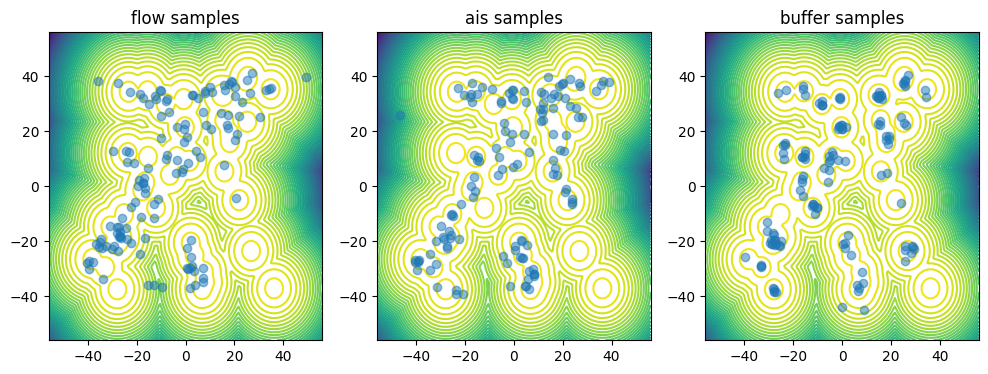

loss: 8.219478274987123, ess base: 0.4078213210754415,ess ais: 0.264550759801103:  67%|██████████████████████████████████████████████████████████████████▋                                 | 2669/4000 [08:34<06:39,  3.33it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 11.739609807829174, ess base: 0.4090801840949765,ess ais: 0.24926513563388808:  67%|████████████████████████████████████████████████████████████████▊                                | 2673/4000 [08:35<04:02,  5.46it/s]

nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.178961539786627, ess base: 0.2991816417665788,ess ais: 0.13443080550804695:  67%|█████████████████████████████████████████████████████████████████▌                                | 2675/4000 [08:35<03:04,  7.17it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 8.76086538813614, ess base: 0.40531323600268687,ess ais: 0.2517720696950828:  67%|██████████████████████████████████████████████████████████████████▎                                | 2677/4000 [08:35<03:15,  6.75it/s]

nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.254515003343297, ess base: 0.37125720312084487,ess ais: 0.18590706948917227:  67%|████████████████████████████████████████████████████████████████▉                                | 2679/4000 [08:36<03:22,  6.52it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.5801556314290774, ess base: 0.385549906418018,ess ais: 0.19676574096008617:  67%|█████████████████████████████████████████████████████████████████▋                                | 2682/4000 [08:36<03:29,  6.29it/s]

nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.977105429880487, ess base: 0.3598439447214664,ess ais: 0.15022204339030767:  67%|█████████████████████████████████████████████████████████████████▊                                | 2686/4000 [08:37<03:31,  6.22it/s]

nan loss in replay step
nan loss in replay step


loss: 12.631884775699113, ess base: 0.3802114482448899,ess ais: 0.18836896364366906:  67%|█████████████████████████████████████████████████████████████████▏                               | 2688/4000 [08:37<03:42,  5.91it/s]

nan grad norm in replay step


loss: 8.164926021766036, ess base: 0.3244093148856853,ess ais: 0.09092529437662712:  67%|█████████████████████████████████████████████████████████████████▉                                | 2690/4000 [08:37<03:03,  7.12it/s]

nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.251088941496485, ess base: 0.39094001056275335,ess ais: 0.22100137781866555:  67%|█████████████████████████████████████████████████████████████████▎                               | 2693/4000 [08:38<03:24,  6.38it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.632536206872014, ess base: 0.46448525885647757,ess ais: 0.31583832354071223:  67%|█████████████████████████████████████████████████████████████████▍                               | 2699/4000 [08:39<03:20,  6.50it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 14.356044785564912, ess base: 0.39303809896106046,ess ais: 0.28645522005361995:  68%|████████████████████████████████████████████████████████████████▉                               | 2704/4000 [08:39<02:22,  9.12it/s]

nan loss in replay step
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 10.693321915779267, ess base: 0.3890172957949465,ess ais: 0.18110315429346724:  68%|█████████████████████████████████████████████████████████████████▋                               | 2707/4000 [08:40<02:56,  7.33it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.700404316840632, ess base: 0.36930313809997,ess ais: 0.21497675235971558:  68%|███████████████████████████████████████████████████████████████████▋                                | 2708/4000 [08:40<02:50,  7.57it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.391281135192315, ess base: 0.3690972978232774,ess ais: 0.2144404170461733:  68%|███████████████████████████████████████████████████████████████████                                | 2712/4000 [08:40<02:34,  8.34it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 13.695135839937478, ess base: 0.3825317396243989,ess ais: 0.23306989648930287:  68%|█████████████████████████████████████████████████████████████████▉                               | 2721/4000 [08:41<02:33,  8.33it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan grad norm in replay step


loss: 7.827997956718011, ess base: 0.3722593130343936,ess ais: 0.21119086605929907:  68%|██████████████████████████████████████████████████████████████████▋                               | 2722/4000 [08:41<02:40,  7.96it/s]

nan loss in replay step
nan loss in replay step


loss: 140.88687927417087, ess base: 0.4216013906699091,ess ais: 0.1386336613570702:  68%|██████████████████████████████████████████████████████████████████▊                               | 2725/4000 [08:42<02:37,  8.08it/s]

nan loss in replay step
nan loss in replay step


loss: 7.397617604152604, ess base: 0.35309767672613995,ess ais: 0.007874015758346469:  68%|█████████████████████████████████████████████████████████████████▌                              | 2730/4000 [08:42<02:34,  8.23it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 8.492282776779494, ess base: 0.4003206732886524,ess ais: 0.27691972279549476:  68%|██████████████████████████████████████████████████████████████████▉                               | 2733/4000 [08:43<02:56,  7.16it/s]

nan loss in replay step


loss: 7.872614368328406, ess base: 0.391345460319679,ess ais: 0.2608301612174385:  68%|████████████████████████████████████████████████████████████████████▍                               | 2737/4000 [08:44<03:13,  6.51it/s]

nan loss in replay step


loss: 9.505581650785821, ess base: 0.25789348260484674,ess ais: 0.11732573595684279:  68%|██████████████████████████████████████████████████████████████████▍                              | 2740/4000 [08:44<03:20,  6.29it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 12.101986454102498, ess base: 0.36900937428885455,ess ais: 0.08101199276785433:  69%|█████████████████████████████████████████████████████████████████▊                              | 2742/4000 [08:44<03:11,  6.57it/s]

nan loss in replay step


loss: 551883887710.2909, ess base: 0.3506386821025564,ess ais: 0.1714708964277838:  69%|███████████████████████████████████████████████████████████████████▉                               | 2743/4000 [08:45<03:15,  6.44it/s]

nan loss in replay step


loss: 12.615590197438106, ess base: 0.33828774515968857,ess ais: 0.15336097728424697:  69%|█████████████████████████████████████████████████████████████████▉                              | 2746/4000 [08:45<03:05,  6.75it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.842413737764687, ess base: 0.37095324431964727,ess ais: 0.19559692112784646:  69%|██████████████████████████████████████████████████████████████████▋                              | 2748/4000 [08:45<03:11,  6.54it/s]

nan grad norm in replay step
nan loss in replay step


loss: 8.344979585802209, ess base: 0.35917461474692525,ess ais: 0.1841120049671867:  69%|███████████████████████████████████████████████████████████████████▍                              | 2750/4000 [08:46<03:12,  6.48it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.455876302844825, ess base: 0.3550672084909462,ess ais: 0.17226614999307385:  69%|███████████████████████████████████████████████████████████████████▍                              | 2751/4000 [08:46<03:12,  6.48it/s]

nan grad norm in replay step


loss: 7.429657011235186, ess base: 0.3456175550472797,ess ais: 0.14190870899072502:  69%|███████████████████████████████████████████████████████████████████▍                              | 2753/4000 [08:46<02:53,  7.18it/s]

nan loss in replay step


loss: 7.795406493874193, ess base: 0.3742216581492388,ess ais: 0.19342032762207415:  69%|███████████████████████████████████████████████████████████████████▌                              | 2757/4000 [08:47<03:08,  6.60it/s]

nan loss in replay step


loss: 9.25389732587473, ess base: 0.40611062415996024,ess ais: 0.2253776039919:  69%|██████████████████████████████████████████████████████████████████████▎                               | 2759/4000 [08:47<02:57,  7.01it/s]

nan loss in replay step
nan loss in replay step
nan loss in replay step


loss: 7.4262010565258585, ess base: 0.3747643232519529,ess ais: 0.0078125:  69%|█████████████████████████████████████████████████████████████████████████▊                                 | 2761/4000 [08:47<02:58,  6.94it/s]

nan loss in replay step
nan loss in replay step


loss: 8.079235382712831, ess base: 0.38235172896989733,ess ais: 0.16711893011837567:  69%|███████████████████████████████████████████████████████████████████                              | 2765/4000 [08:48<03:06,  6.63it/s]

nan loss in replay step
nan loss in replay step


loss: 8.198316420950599, ess base: 0.3891161472959903,ess ais: 0.17086135644613087:  69%|███████████████████████████████████████████████████████████████████▊                              | 2770/4000 [08:48<02:15,  9.07it/s]

nan loss in replay step
nan loss in replay step


loss: 7.948126230718622, ess base: 0.38051686965894016,ess ais: 0.1925658403621926:  69%|███████████████████████████████████████████████████████████████████▉                              | 2772/4000 [08:49<02:34,  7.93it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 7.480701525606671, ess base: 0.31984600398561863,ess ais: 0.14629963082995925:  69%|███████████████████████████████████████████████████████████████████▎                             | 2774/4000 [08:49<02:49,  7.23it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step


loss: 7.323295370673511, ess base: 0.32122965740528914,ess ais: 0.14573923021674903:  69%|███████████████████████████████████████████████████████████████████▎                             | 2776/4000 [08:49<02:46,  7.37it/s]

nan loss in replay step
nan loss in replay step


loss: 8.955751329932204, ess base: 0.3703187599308058,ess ais: 0.20069822217069383:  69%|████████████████████████████████████████████████████████████████████                              | 2779/4000 [08:50<02:19,  8.76it/s]

nan loss in replay step
nan loss in replay step
nan loss in replay step


loss: 7.493634651137477, ess base: 0.3913235098199235,ess ais: 0.27354735978124944:  70%|████████████████████████████████████████████████████████████████████▏                             | 2781/4000 [08:50<02:27,  8.27it/s]

nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.7361819646815295, ess base: 0.3932028965165583,ess ais: 0.16463715161542267:  70%|███████████████████████████████████████████████████████████████████▌                             | 2784/4000 [08:50<02:08,  9.45it/s]

nan loss in replay step
nan loss in replay step
nan loss in replay step


loss: 7.956772101732833, ess base: 0.42994477722619573,ess ais: 0.2563914028288019:  70%|████████████████████████████████████████████████████████████████████▎                             | 2788/4000 [08:50<01:54, 10.55it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 7.792246593110397, ess base: 0.3744255175819347,ess ais: 0.21477585699296223:  70%|████████████████████████████████████████████████████████████████████▍                             | 2791/4000 [08:51<02:05,  9.64it/s]

nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 7.759838657657593, ess base: 0.3518116864414799,ess ais: 0.18123927001608425:  70%|████████████████████████████████████████████████████████████████████▍                             | 2794/4000 [08:51<02:34,  7.78it/s]

nan loss in replay step


loss: 12.773932620182446, ess base: 0.43198143279447193,ess ais: 0.29322127467314885:  70%|███████████████████████████████████████████████████████████████████▏                            | 2800/4000 [08:52<02:14,  8.90it/s]

nan loss in replay step
nan loss in replay step
nan loss in replay step


loss: 10.947500154848008, ess base: 0.3981267751398006,ess ais: 0.26823565826191526:  70%|███████████████████████████████████████████████████████████████████▉                             | 2802/4000 [08:52<02:17,  8.68it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.
nan grad norm in replay step
nan loss in replay step


loss: 8.779661252153465, ess base: 0.39818145597323684,ess ais: 0.0078125:  70%|███████████████████████████████████████████████████████████████████████████                                | 2804/4000 [08:52<02:08,  9.30it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 8.0700979284836, ess base: 0.2768682931483152,ess ais: 0.05582287307796564:  70%|██████████████████████████████████████████████████████████████████████▏                             | 2806/4000 [08:53<02:12,  9.01it/s]

nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 9.232225454461862, ess base: 0.36622919109511515,ess ais: 0.20427866930011013:  70%|████████████████████████████████████████████████████████████████████                             | 2809/4000 [08:53<02:05,  9.46it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step


loss: 7.482145112828061, ess base: 0.3931448387401664,ess ais: 0.18086017108168623:  70%|████████████████████████████████████████████████████████████████████▉                             | 2812/4000 [08:53<02:12,  8.99it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step


loss: 7.582426236674471, ess base: 0.37396435432725245,ess ais: 0.19753305848520164:  70%|████████████████████████████████████████████████████████████████████▏                            | 2814/4000 [08:54<02:33,  7.71it/s]

nan loss in replay step
nan grad norm in replay step


loss: 8.989245845391524, ess base: 0.3072616374078668,ess ais: 0.06539207803819738:  70%|█████████████████████████████████████████████████████████████████████                             | 2818/4000 [08:54<02:21,  8.33it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step


loss: 7.5619583360313625, ess base: 0.38526888360152745,ess ais: 0.13393013372554713:  71%|███████████████████████████████████████████████████████████████████▋                            | 2821/4000 [08:54<02:24,  8.17it/s]

nan loss in replay step
nan loss in replay step


loss: 27.054205854248607, ess base: 0.40734100512459304,ess ais: 0.19721812587649626:  71%|███████████████████████████████████████████████████████████████████▊                            | 2825/4000 [08:55<02:19,  8.42it/s]

nan loss in replay step
nan loss in replay step


loss: 8.053557732410443, ess base: 0.3753263656419928,ess ais: 0.20062669756510068:  71%|█████████████████████████████████████████████████████████████████████▎                            | 2827/4000 [08:55<02:25,  8.07it/s]

nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.570636943196824, ess base: 0.39150002089805136,ess ais: 0.18229442101627785:  71%|████████████████████████████████████████████████████████████████████▌                            | 2829/4000 [08:55<02:42,  7.23it/s]

nan loss in replay step


loss: 9.067623202666901, ess base: 0.4081197052639249,ess ais: 0.19462947489482052:  71%|█████████████████████████████████████████████████████████████████████▎                            | 2831/4000 [08:56<02:38,  7.36it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 9.513422530657657, ess base: 0.42639236291853555,ess ais: 0.27741784236304906:  71%|████████████████████████████████████████████████████████████████████▋                            | 2834/4000 [08:56<02:43,  7.13it/s]

nan loss in replay step


loss: 7.3572746371250854, ess base: 0.36668355525052904,ess ais: 0.15703413771253757:  71%|████████████████████████████████████████████████████████████████████                            | 2837/4000 [08:57<02:14,  8.63it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan grad norm in replay step
nan loss in replay step


loss: 7.360299645465442, ess base: 0.4007698976074282,ess ais: 0.00902377997278278:  71%|█████████████████████████████████████████████████████████████████████▌                            | 2841/4000 [08:57<02:14,  8.60it/s]

nan loss in replay step
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 7.926660840194538, ess base: 0.4503970224399492,ess ais: 0.2757702355956527:  71%|██████████████████████████████████████████████████████████████████████▍                            | 2846/4000 [08:58<02:12,  8.70it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 9.159142149750096, ess base: 0.4249646814425482,ess ais: 0.2799321428675089:  71%|██████████████████████████████████████████████████████████████████████▍                            | 2848/4000 [08:58<02:30,  7.64it/s]

nan loss in replay step


loss: 8.368644010086502, ess base: 0.32924142872095835,ess ais: 0.1811343111313718:  71%|█████████████████████████████████████████████████████████████████████▊                            | 2849/4000 [08:58<02:36,  7.36it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step


loss: 7.279142129679087, ess base: 0.28027017690585554,ess ais: 0.03593299883376344:  71%|█████████████████████████████████████████████████████████████████████▏                           | 2852/4000 [08:58<02:32,  7.55it/s]

nan loss in replay step


loss: 8.694993688002851, ess base: 0.35673554581141725,ess ais: 0.14507867224599874:  71%|█████████████████████████████████████████████████████████████████████▏                           | 2854/4000 [08:59<02:45,  6.94it/s]

nan loss in replay step
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 1.2065296660562216e+92, ess base: 0.3832920652754479,ess ais: 0.19297875794097397:  71%|██████████████████████████████████████████████████████████████████▍                          | 2857/4000 [08:59<02:36,  7.29it/s]

nan loss in replay step
nan loss in replay step


loss: 10.31421653388118, ess base: 0.35996627615460625,ess ais: 0.15332452904902114:  71%|█████████████████████████████████████████████████████████████████████▎                           | 2859/4000 [08:59<02:50,  6.71it/s]

nan loss in replay step


loss: 7.548781472141672, ess base: 0.39053187570876313,ess ais: 0.23947318303767326:  72%|█████████████████████████████████████████████████████████████████████▍                           | 2862/4000 [09:00<02:53,  6.54it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 8.92556803494451, ess base: 0.3654932552471338,ess ais: 0.1647515259329766:  72%|███████████████████████████████████████████████████████████████████████▌                            | 2864/4000 [09:00<02:52,  6.58it/s]

nan loss in replay step
nan loss in replay step


loss: 7.244534259591582, ess base: 0.37666069104001526,ess ais: 0.18980749199505473:  72%|█████████████████████████████████████████████████████████████████████▍                           | 2865/4000 [09:00<02:50,  6.67it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 7.638751535559997, ess base: 0.43014713217531453,ess ais: 0.21169668610383582:  72%|█████████████████████████████████████████████████████████████████████▌                           | 2867/4000 [09:01<03:47,  4.98it/s]

nan loss in replay step
nan loss in replay step


loss: 7.8719373140351525, ess base: 0.2991211777846985,ess ais: 0.22373746829414629:  72%|█████████████████████████████████████████████████████████████████████▌                           | 2871/4000 [09:02<03:08,  5.99it/s]

nan loss in replay step
nan loss in replay step


loss: 8.3012912908904, ess base: 0.44150895115389865,ess ais: 0.27313485821646105:  72%|███████████████████████████████████████████████████████████████████████▏                           | 2874/4000 [09:02<02:17,  8.20it/s]

nan loss in replay step
nan loss in replay step


loss: 12.544300576708663, ess base: 0.3670482312771325,ess ais: 0.15549506839270905:  72%|█████████████████████████████████████████████████████████████████████▊                           | 2877/4000 [09:02<02:32,  7.37it/s]

nan loss in replay step


loss: 8.932079478816759, ess base: 0.4107776794816163,ess ais: 0.1952509474164772:  72%|███████████████████████████████████████████████████████████████████████▎                           | 2879/4000 [09:02<02:08,  8.71it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 27.528972489546824, ess base: 0.38638758970535647,ess ais: 0.17014345394891175:  72%|█████████████████████████████████████████████████████████████████████▏                          | 2882/4000 [09:03<02:16,  8.21it/s]

nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.82063738822527, ess base: 0.2873795809430376,ess ais: 0.05957795189813295:  72%|███████████████████████████████████████████████████████████████████████▍                           | 2887/4000 [09:04<02:52,  6.43it/s]

nan loss in replay step
nan loss in replay step


loss: 7.6735033647282425, ess base: 0.3944523144746618,ess ais: 0.21205036752510903:  72%|██████████████████████████████████████████████████████████████████████▏                          | 2893/4000 [09:04<02:46,  6.66it/s]

nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 8.369175140793233, ess base: 0.3742367331600706,ess ais: 0.18973597211190898:  72%|██████████████████████████████████████████████████████████████████████▉                           | 2895/4000 [09:05<02:40,  6.89it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step


loss: 7.661217198799666, ess base: 0.36819392243728305,ess ais: 0.1657706672738192:  72%|██████████████████████████████████████████████████████████████████████▉                           | 2897/4000 [09:05<02:38,  6.95it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step


loss: 9.171329572387199, ess base: 0.40974806927640467,ess ais: 0.24479790935367848:  72%|██████████████████████████████████████████████████████████████████████▎                          | 2899/4000 [09:05<02:39,  6.92it/s]

nan loss in replay step
nan loss in replay step


loss: 7.792087912284664, ess base: 0.3525579004731822,ess ais: 0.12657406859122558:  73%|███████████████████████████████████████████████████████████████████████                           | 2901/4000 [09:05<02:05,  8.75it/s]

nan loss in replay step


loss: 8.03424316619966, ess base: 0.41145758106092506,ess ais: 0.182733161646511:  73%|████████████████████████████████████████████████████████████████████████▌                           | 2903/4000 [09:06<02:27,  7.43it/s]

nan loss in replay step


loss: 7.816795152291577, ess base: 0.3858643693973201,ess ais: 0.19345382308162468:  73%|███████████████████████████████████████████████████████████████████████▏                          | 2906/4000 [09:06<02:40,  6.82it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 7.573126451637098, ess base: 0.337919414123402,ess ais: 0.09668225738307144:  73%|███████████████████████████████████████████████████████████████████████▉                           | 2909/4000 [09:07<02:44,  6.64it/s]

nan loss in replay step
nan grad norm in replay step


loss: 8.335896417006461, ess base: 0.37382492327465433,ess ais: 0.18021308599683056:  73%|██████████████████████████████████████████████████████████████████████▋                          | 2913/4000 [09:07<02:47,  6.50it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step


loss: 8.752584951713184, ess base: 0.37363574046490655,ess ais: 0.18977070517727687:  73%|██████████████████████████████████████████████████████████████████████▋                          | 2917/4000 [09:08<02:12,  8.17it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan grad norm in replay step
nan loss in replay step


loss: 8.723838577031714, ess base: 0.39648617953130705,ess ais: 0.10058114562333369:  73%|██████████████████████████████████████████████████████████████████████▊                          | 2919/4000 [09:08<02:20,  7.67it/s]

nan loss in replay step
2 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 7.718821901461235, ess base: 0.34829185737800206,ess ais: 0.07628901624310015:  73%|██████████████████████████████████████████████████████████████████████▊                          | 2921/4000 [09:08<02:27,  7.34it/s]

nan loss in replay step
nan loss in replay step


loss: 10.148575366738228, ess base: 0.33718488434758714,ess ais: 0.05840936310015527:  73%|██████████████████████████████████████████████████████████████████████▏                         | 2924/4000 [09:09<02:40,  6.68it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 135887653.229639, ess base: 0.3782785022368784,ess ais: 0.008153340991456993:  73%|███████████████████████████████████████████████████████████████████████▋                          | 2926/4000 [09:09<02:55,  6.13it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.12309640725407, ess base: 0.372970736547744,ess ais: 0.14771671768134315:  73%|█████████████████████████████████████████████████████████████████████████▏                          | 2927/4000 [09:09<02:50,  6.29it/s]

nan loss in replay step


loss: 8.784853146121838, ess base: 0.3546887291027356,ess ais: 0.1455789050078046:  73%|████████████████████████████████████████████████████████████████████████▌                          | 2930/4000 [09:10<03:28,  5.14it/s]

nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 8.539921745919747, ess base: 0.3942943483913488,ess ais: 0.19367262965518062:  73%|███████████████████████████████████████████████████████████████████████▉                          | 2934/4000 [09:11<02:28,  7.19it/s]

nan loss in replay step
nan loss in replay step


loss: 8.498553976004004, ess base: 0.35386481142567794,ess ais: 0.2184042772070187:  74%|████████████████████████████████████████████████████████████████████████                          | 2941/4000 [09:12<03:09,  5.59it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.539620359433211, ess base: 0.36296358118655264,ess ais: 0.1817692332169575:  74%|████████████████████████████████████████████████████████████████████████▏                         | 2945/4000 [09:12<03:03,  5.75it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 8.810911639697476, ess base: 0.3977326833334829,ess ais: 0.18005685605339564:  74%|████████████████████████████████████████████████████████████████████████▎                         | 2951/4000 [09:13<02:34,  6.79it/s]

nan loss in replay step
nan loss in replay step


loss: 8.041804909402538, ess base: 0.3453318595360975,ess ais: 0.19347846280254877:  74%|████████████████████████████████████████████████████████████████████████▍                         | 2955/4000 [09:14<02:29,  7.01it/s]

nan loss in replay step
nan loss in replay step


loss: 7.392506531698148, ess base: 0.39580460419232755,ess ais: 0.25974534637874674:  74%|███████████████████████████████████████████████████████████████████████▋                         | 2957/4000 [09:14<02:36,  6.66it/s]

nan loss in replay step


loss: 7.987860687187772, ess base: 0.4149965391294158,ess ais: 0.19443029119211402:  74%|████████████████████████████████████████████████████████████████████████▍                         | 2959/4000 [09:15<02:50,  6.11it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 1.6528837359112548e+24, ess base: 0.4133019993665932,ess ais: 0.2539228515542858:  74%|█████████████████████████████████████████████████████████████████████▋                        | 2963/4000 [09:15<02:56,  5.89it/s]

nan loss in replay step


loss: 11.254950225485285, ess base: 0.3876727417276093,ess ais: 0.18143731003146363:  74%|███████████████████████████████████████████████████████████████████████▉                         | 2965/4000 [09:16<02:45,  6.26it/s]

nan loss in replay step


loss: 7.228503217815023, ess base: 0.3909312353738545,ess ais: 0.24494524813081162:  74%|████████████████████████████████████████████████████████████████████████▋                         | 2966/4000 [09:16<02:49,  6.11it/s]

nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 9.597548626840366, ess base: 0.4325423386022313,ess ais: 0.26530626172156485:  74%|████████████████████████████████████████████████████████████████████████▊                         | 2970/4000 [09:16<02:36,  6.59it/s]

nan loss in replay step


loss: 8.591275849707488, ess base: 0.3382243285714122,ess ais: 0.1809762275965842:  74%|█████████████████████████████████████████████████████████████████████████▌                         | 2972/4000 [09:17<02:25,  7.06it/s]

nan loss in replay step


loss: 7.642877046057361, ess base: 0.3718042252957824,ess ais: 0.15468575211688865:  74%|████████████████████████████████████████████████████████████████████████▉                         | 2975/4000 [09:17<02:12,  7.73it/s]

nan loss in replay step
nan loss in replay step


loss: 12.840920749051682, ess base: 0.36600336389190324,ess ais: 0.181488547654687:  74%|████████████████████████████████████████████████████████████████████████▉                         | 2977/4000 [09:17<02:23,  7.14it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.304797614557508, ess base: 0.31575194812372825,ess ais: 0.11545916440665623:  74%|████████████████████████████████████████████████████████████████████████▏                        | 2979/4000 [09:18<02:23,  7.13it/s]

nan loss in replay step


loss: 7.594258750449706, ess base: 0.33248756608708674,ess ais: 0.15570273982916968:  75%|████████████████████████████████████████████████████████████████████████▎                        | 2981/4000 [09:18<02:34,  6.58it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.595101652680809, ess base: 0.3915256155607439,ess ais: 0.2167326627598672:  75%|█████████████████████████████████████████████████████████████████████████▊                         | 2983/4000 [09:18<02:35,  6.53it/s]

nan grad norm in replay step
nan loss in replay step


loss: 8.346228749730658, ess base: 0.37510405603595837,ess ais: 0.24482230658117593:  75%|████████████████████████████████████████████████████████████████████████▍                        | 2986/4000 [09:19<02:41,  6.29it/s]

nan loss in replay step
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.090779043644986, ess base: 0.47538605193565575,ess ais: 0.2955653170548:  75%|███████████████████████████████████████████████████████████████████████████▍                         | 2990/4000 [09:19<02:15,  7.46it/s]

nan loss in replay step
nan loss in replay step


loss: 8.391305753398578, ess base: 0.37563791950260106,ess ais: 0.14010247989010738:  75%|████████████████████████████████████████████████████████████████████████▌                        | 2992/4000 [09:20<02:24,  6.98it/s]

nan loss in replay step
nan loss in replay step


loss: 8.013131644821353, ess base: 0.4263681056641707,ess ais: 0.2281815656914298:  75%|██████████████████████████████████████████████████████████████████████████▏                        | 2995/4000 [09:20<02:18,  7.24it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 7.888353548081183, ess base: 0.3811173598671393,ess ais: 0.21113859508785926:  75%|█████████████████████████████████████████████████████████████████████████▍                        | 2997/4000 [09:20<02:24,  6.96it/s]

nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step


loss: 7.7424020125934385, ess base: 0.42795620987536154,ess ais: 0.2711451400751296:  75%|████████████████████████████████████████████████████████████████████████▋                        | 2999/4000 [09:20<02:20,  7.10it/s]

nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 9.282367510099075, ess base: 0.3904934447514613,ess ais: 0.2292336921308106:  75%|██████████████████████████████████████████████████████████████████████████▎                        | 3001/4000 [09:21<02:31,  6.58it/s]

nan loss in replay step
nan loss in replay step


loss: 8.789154891187918, ess base: 0.28457429121861416,ess ais: 0.1337695624206409:  75%|█████████████████████████████████████████████████████████████████████████▌                        | 3004/4000 [09:21<02:25,  6.87it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 7.491680816417629, ess base: 0.48111313129761735,ess ais: 0.27916885967997357:  75%|████████████████████████████████████████████████████████████████████████▉                        | 3006/4000 [09:21<02:33,  6.46it/s]

nan loss in replay step
nan loss in replay step


loss: 7.514394789747568, ess base: 0.46798010696694997,ess ais: 0.08574280581022517:  75%|████████████████████████████████████████████████████████████████████████▉                        | 3009/4000 [09:22<02:19,  7.10it/s]

nan loss in replay step


loss: 7.831068917519474, ess base: 0.41831316677815583,ess ais: 0.1928440763739457:  75%|█████████████████████████████████████████████████████████████████████████▊                        | 3013/4000 [09:22<02:10,  7.55it/s]

nan loss in replay step
nan loss in replay step


loss: 7.708563176523715, ess base: 0.37980319431520865,ess ais: 0.18124061015363158:  75%|█████████████████████████████████████████████████████████████████████████                        | 3014/4000 [09:23<02:06,  7.80it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 7.789104558278146, ess base: 0.3642893815388075,ess ais: 0.13784459345071617:  75%|█████████████████████████████████████████████████████████████████████████▉                        | 3019/4000 [09:23<02:29,  6.54it/s]

nan loss in replay step
nan loss in replay step


loss: 8.143342025019624, ess base: 0.42693254429475813,ess ais: 0.22941354059197003:  76%|█████████████████████████████████████████████████████████████████████████▎                       | 3021/4000 [09:24<02:02,  7.97it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.5973727108849864, ess base: 0.4102337023232875,ess ais: 0.26688187515737727:  76%|█████████████████████████████████████████████████████████████████████████▎                       | 3023/4000 [09:24<02:07,  7.64it/s]

nan loss in replay step
nan loss in replay step


loss: 8.029397248169388, ess base: 0.37611708011847356,ess ais: 0.18296799280441445:  76%|█████████████████████████████████████████████████████████████████████████▎                       | 3025/4000 [09:24<02:19,  7.00it/s]

nan grad norm in replay step


loss: 9.28446395392472, ess base: 0.3406901438174214,ess ais: 0.17082024973502188:  76%|██████████████████████████████████████████████████████████████████████████▉                        | 3027/4000 [09:25<02:37,  6.17it/s]

nan loss in replay step


loss: 8.2327178255834, ess base: 0.4014254282310347,ess ais: 0.23314979544047662:  76%|███████████████████████████████████████████████████████████████████████████▋                        | 3029/4000 [09:25<02:39,  6.07it/s]

nan loss in replay step
nan loss in replay step


loss: 8.882530870199862, ess base: 0.4253798270213842,ess ais: 0.205832444022749:  76%|███████████████████████████████████████████████████████████████████████████▊                        | 3032/4000 [09:25<02:40,  6.04it/s]

nan loss in replay step
nan loss in replay step


loss: 8.298644662587163, ess base: 0.40002537894428986,ess ais: 0.20217962008007026:  76%|█████████████████████████████████████████████████████████████████████████▌                       | 3034/4000 [09:26<02:38,  6.09it/s]

nan loss in replay step
nan loss in replay step


loss: 7.368570442779968, ess base: 0.4375945365151021,ess ais: 0.23201668713829499:  76%|██████████████████████████████████████████████████████████████████████████▍                       | 3036/4000 [09:26<02:40,  5.99it/s]

nan loss in replay step
nan grad norm in replay step


loss: 7.9400649174209725, ess base: 0.36552392674560824,ess ais: 0.18686209584317978:  76%|████████████████████████████████████████████████████████████████████████▉                       | 3038/4000 [09:26<02:34,  6.21it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step


loss: 7.682399597363492, ess base: 0.414962767182476,ess ais: 0.22480640928247453:  76%|███████████████████████████████████████████████████████████████████████████▏                       | 3040/4000 [09:27<02:31,  6.34it/s]

nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 20.01477514177264, ess base: 0.4449406243684698,ess ais: 0.24468140204644417:  76%|██████████████████████████████████████████████████████████████████████████▌                       | 3042/4000 [09:27<02:25,  6.58it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step


loss: 1316.3643123019742, ess base: 0.4154093620280095,ess ais: 0.1938890335780284:  76%|██████████████████████████████████████████████████████████████████████████▌                       | 3045/4000 [09:27<01:57,  8.14it/s]

nan loss in replay step
nan loss in replay step


loss: 8.643439956815516, ess base: 0.3918585511774561,ess ais: 0.18459637401942797:  76%|██████████████████████████████████████████████████████████████████████████▋                       | 3047/4000 [09:27<01:52,  8.48it/s]

nan loss in replay step
nan loss in replay step


loss: 8.19341885236775, ess base: 0.3040120484571728,ess ais: 0.05853271855608086:  76%|███████████████████████████████████████████████████████████████████████████▍                       | 3048/4000 [09:28<01:59,  7.97it/s]

nan loss in replay step
nan loss in replay step


loss: 2.318614092490845e+26, ess base: 0.4615170492559196,ess ais: 0.26192003345508874:  76%|███████████████████████████████████████████████████████████████████████▋                      | 3051/4000 [09:28<01:45,  8.97it/s]

nan loss in replay step
nan loss in replay step


loss: 8.034522068552421, ess base: 0.4375368285773698,ess ais: 0.26191343710654624:  76%|██████████████████████████████████████████████████████████████████████████▊                       | 3052/4000 [09:28<02:09,  7.30it/s]

nan loss in replay step


loss: 7.677152340129869, ess base: 0.45114759172458274,ess ais: 0.2384423735346477:  76%|██████████████████████████████████████████████████████████████████████████▊                       | 3053/4000 [09:28<02:21,  6.69it/s]

nan loss in replay step
nan grad norm in replay step


loss: 7.603274748403575, ess base: 0.3559463613390561,ess ais: 0.1903313314919621:  76%|███████████████████████████████████████████████████████████████████████████▌                       | 3055/4000 [09:29<02:35,  6.07it/s]

nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 7.765512430107388, ess base: 0.39399061076984077,ess ais: 0.2033478002374974:  76%|██████████████████████████████████████████████████████████████████████████▉                       | 3058/4000 [09:29<02:30,  6.27it/s]

nan loss in replay step


loss: 7.712601503339547, ess base: 0.4763226411690658,ess ais: 0.2547023339227839:  76%|███████████████████████████████████████████████████████████████████████████▋                       | 3059/4000 [09:29<02:43,  5.75it/s]

nan loss in replay step
nan loss in replay step


loss: 7.9634600720463915, ess base: 0.3753773040550537,ess ais: 0.18662967335450073:  77%|██████████████████████████████████████████████████████████████████████████▎                      | 3062/4000 [09:30<02:27,  6.36it/s]

nan loss in replay step
nan loss in replay step


loss: 7.307386174974219, ess base: 0.4186078474441043,ess ais: 0.2670860125353512:  77%|███████████████████████████████████████████████████████████████████████████▊                       | 3064/4000 [09:30<02:34,  6.05it/s]

nan loss in replay step
nan loss in replay step


loss: 9.008775982530867, ess base: 0.3872392787689359,ess ais: 0.20887459757688587:  77%|███████████████████████████████████████████████████████████████████████████                       | 3066/4000 [09:30<02:22,  6.58it/s]

nan loss in replay step
nan loss in replay step


loss: 7.874323811952803, ess base: 0.4102164964261729,ess ais: 0.2523819716675451:  77%|███████████████████████████████████████████████████████████████████████████▉                       | 3068/4000 [09:31<02:35,  6.00it/s]

nan loss in replay step
nan loss in replay step


loss: 7.791826294484719, ess base: 0.3784168171501162,ess ais: 0.18920969498320922:  77%|███████████████████████████████████████████████████████████████████████████▏                      | 3070/4000 [09:31<02:26,  6.34it/s]

nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 8.155599596522377, ess base: 0.3384643936208215,ess ais: 0.14942716295616895:  77%|███████████████████████████████████████████████████████████████████████████▎                      | 3073/4000 [09:32<02:24,  6.40it/s]

nan loss in replay step
nan loss in replay step


loss: 7.991745181917501, ess base: 0.3445014489106774,ess ais: 0.21103052620798568:  77%|███████████████████████████████████████████████████████████████████████████▍                      | 3077/4000 [09:32<02:48,  5.46it/s]

nan grad norm in replay step
nan loss in replay step


loss: 7.331092177779641, ess base: 0.39361763102264014,ess ais: 0.23492647963405935:  77%|██████████████████████████████████████████████████████████████████████████▋                      | 3079/4000 [09:33<02:39,  5.77it/s]

nan loss in replay step
nan loss in replay step


loss: 9.472075232907088, ess base: 0.21938931444308027,ess ais: 0.0078125:  77%|██████████████████████████████████████████████████████████████████████████████████▍                        | 3081/4000 [09:33<02:35,  5.91it/s]

nan loss in replay step


loss: 8.9350686545595, ess base: 0.24727758687576398,ess ais: 0.03573942780382842:  77%|████████████████████████████████████████████████████████████████████████████▎                      | 3083/4000 [09:33<02:31,  6.05it/s]

nan loss in replay step
nan loss in replay step


loss: 10.447518064258121, ess base: 0.4078087081772659,ess ais: 0.25590159911686444:  77%|██████████████████████████████████████████████████████████████████████████▊                      | 3086/4000 [09:34<02:05,  7.28it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step


loss: 9.0083332963808, ess base: 0.34953714152135446,ess ais: 0.20379739774047695:  77%|████████████████████████████████████████████████████████████████████████████▍                      | 3087/4000 [09:34<02:22,  6.40it/s]

nan loss in replay step


loss: 8.485386513732012, ess base: 0.3327351883470878,ess ais: 0.0078125:  77%|███████████████████████████████████████████████████████████████████████████████████▍                        | 3088/4000 [09:34<02:20,  6.50it/s]

nan grad norm in replay step
nan loss in replay step


loss: 7.830297027830718, ess base: 0.38213629870948623,ess ais: 0.19487613366339013:  77%|██████████████████████████████████████████████████████████████████████████▉                      | 3090/4000 [09:34<02:22,  6.40it/s]

nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 7.486338752234405, ess base: 0.3309216956613816,ess ais: 0.1458995130952409:  77%|████████████████████████████████████████████████████████████████████████████▌                      | 3092/4000 [09:35<02:22,  6.38it/s]

nan grad norm in replay step
nan loss in replay step


loss: 7.663205366739675, ess base: 0.4023688998940453,ess ais: 0.2706085944753734:  77%|████████████████████████████████████████████████████████████████████████████▌                      | 3094/4000 [09:35<02:00,  7.49it/s]

nan loss in replay step
nan loss in replay step


loss: 7.6825452697815715, ess base: 0.2803392613916272,ess ais: 0.11701340147842844:  77%|███████████████████████████████████████████████████████████████████████████                      | 3097/4000 [09:35<02:06,  7.16it/s]

nan loss in replay step
nan grad norm in replay step


loss: 8.1454359051205, ess base: 0.3837887521851591,ess ais: 0.1874347213779928:  77%|██████████████████████████████████████████████████████████████████████████████▏                      | 3099/4000 [09:36<02:15,  6.64it/s]

nan grad norm in replay step
nan loss in replay step


loss: 10.060432810233046, ess base: 0.35703467076884116,ess ais: 0.15422613024091703:  78%|██████████████████████████████████████████████████████████████████████████▍                     | 3101/4000 [09:36<02:18,  6.49it/s]

nan loss in replay step
nan loss in replay step


loss: 8.634211392526101, ess base: 0.3748475783368588,ess ais: 0.22899715478065938:  78%|████████████████████████████████████████████████████████████████████████████                      | 3103/4000 [09:36<02:03,  7.28it/s]

nan loss in replay step
nan loss in replay step


loss: 8.302414136733086, ess base: 0.33876695762647463,ess ais: 0.13503688633723257:  78%|███████████████████████████████████████████████████████████████████████████▎                     | 3107/4000 [09:37<02:00,  7.39it/s]

nan loss in replay step
nan loss in replay step


loss: 7.470302287041915, ess base: 0.30196352797955,ess ais: 0.13195867796763378:  78%|█████████████████████████████████████████████████████████████████████████████▊                      | 3110/4000 [09:37<02:13,  6.67it/s]

nan loss in replay step
nan loss in replay step


loss: 7.739650480293233, ess base: 0.4102713710100063,ess ais: 0.19461122923308255:  78%|████████████████████████████████████████████████████████████████████████████▏                     | 3110/4000 [09:37<02:13,  6.67it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


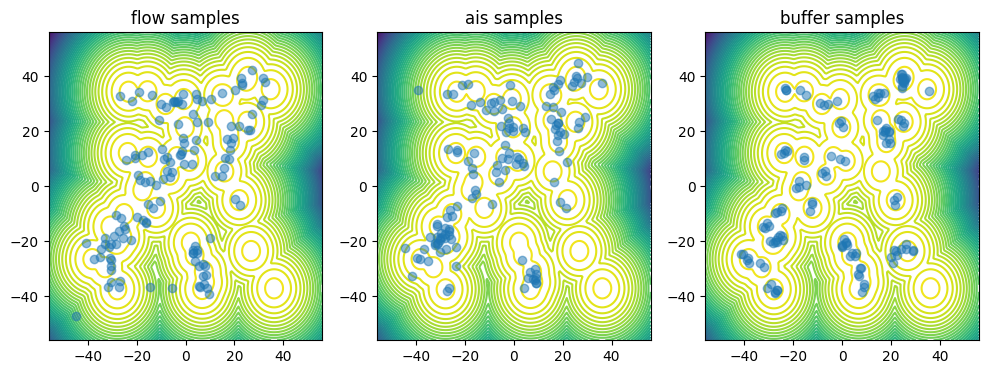

loss: 7.612280690951563, ess base: 0.39342292159225306,ess ais: 0.0078125:  78%|███████████████████████████████████████████████████████████████████████████████████▎                       | 3114/4000 [09:39<04:07,  3.58it/s]

nan loss in replay step
nan loss in replay step


loss: 7.500199237748965, ess base: 0.4165590630020565,ess ais: 0.20585165753081222:  78%|████████████████████████████████████████████████████████████████████████████▎                     | 3116/4000 [09:39<03:03,  4.83it/s]

nan loss in replay step
nan loss in replay step


loss: 7.851334347484414, ess base: 0.3751527962317291,ess ais: 0.2034120685816477:  78%|█████████████████████████████████████████████████████████████████████████████▏                     | 3118/4000 [09:40<02:48,  5.24it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 18.961233288601857, ess base: 0.4211089915434476,ess ais: 0.21738284137044542:  78%|███████████████████████████████████████████████████████████████████████████▋                     | 3121/4000 [09:40<02:25,  6.05it/s]

nan loss in replay step
nan loss in replay step


loss: 7.182507363793757, ess base: 0.3558896004817834,ess ais: 0.2158839178285808:  78%|█████████████████████████████████████████████████████████████████████████████▎                     | 3123/4000 [09:40<02:22,  6.17it/s]

nan loss in replay step
nan loss in replay step


loss: 7.624614822256779, ess base: 0.4214451815039262,ess ais: 0.2705863535089726:  78%|█████████████████████████████████████████████████████████████████████████████▎                     | 3126/4000 [09:41<02:05,  6.94it/s]

nan loss in replay step
nan loss in replay step


loss: 90.0408844344058, ess base: 0.3740285472922659,ess ais: 0.15433835389936293:  78%|█████████████████████████████████████████████████████████████████████████████▍                     | 3128/4000 [09:41<02:06,  6.87it/s]

nan loss in replay step
nan loss in replay step


loss: 7.385640979804519, ess base: 0.43171826909439326,ess ais: 0.25786618823664703:  78%|███████████████████████████████████████████████████████████████████████████▉                     | 3130/4000 [09:41<02:10,  6.69it/s]

nan loss in replay step
nan loss in replay step


loss: 7.477086094230631, ess base: 0.38938696168086545,ess ais: 0.20750921325307364:  78%|███████████████████████████████████████████████████████████████████████████▉                     | 3133/4000 [09:42<01:42,  8.46it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step


loss: 7.770244389320022, ess base: 0.3622475352748208,ess ais: 0.23705970169621177:  78%|████████████████████████████████████████████████████████████████████████████▊                     | 3135/4000 [09:42<01:58,  7.31it/s]

nan loss in replay step
nan loss in replay step


loss: 7.84124993904752, ess base: 0.40314422235621433,ess ais: 0.007812500035063032:  78%|████████████████████████████████████████████████████████████████████████████                     | 3137/4000 [09:42<02:08,  6.72it/s]

nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan grad norm in replay step


loss: 12.465789605043673, ess base: 0.3887315130439467,ess ais: 0.007812500003390434:  78%|███████████████████████████████████████████████████████████████████████████▎                    | 3140/4000 [09:43<01:44,  8.27it/s]

nan loss in replay step
nan loss in replay step


loss: 7.329744513672974, ess base: 0.3588093093248094,ess ais: 0.22042423637513545:  79%|████████████████████████████████████████████████████████████████████████████▉                     | 3142/4000 [09:43<02:07,  6.74it/s]

nan loss in replay step
nan loss in replay step


loss: 8.35467382742732, ess base: 0.4089139108619548,ess ais: 0.1860125013363713:  79%|██████████████████████████████████████████████████████████████████████████████▋                     | 3145/4000 [09:44<02:17,  6.20it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.196923340394045, ess base: 0.38763148973708295,ess ais: 0.23231753832845636:  79%|████████████████████████████████████████████████████████████████████████████▎                    | 3147/4000 [09:44<02:23,  5.92it/s]

nan loss in replay step


loss: 10.472991558074638, ess base: 0.33792783959901024,ess ais: 0.13344158661216174:  79%|███████████████████████████████████████████████████████████████████████████▌                    | 3149/4000 [09:44<02:10,  6.54it/s]

nan loss in replay step


loss: 8.30684867788639, ess base: 0.3689257834176248,ess ais: 0.15667357631701723:  79%|█████████████████████████████████████████████████████████████████████████████▉                     | 3151/4000 [09:45<02:12,  6.41it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.83828866369877, ess base: 0.33164870742139024,ess ais: 0.0078125:  79%|█████████████████████████████████████████████████████████████████████████████████████                       | 3152/4000 [09:45<02:01,  6.96it/s]

nan loss in replay step


loss: 7.721873483805162, ess base: 0.35397774384152064,ess ais: 0.15771649196619056:  79%|████████████████████████████████████████████████████████████████████████████▍                    | 3154/4000 [09:45<02:12,  6.39it/s]

nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 8.086927213266252, ess base: 0.39804520118826614,ess ais: 0.21252056415957055:  79%|████████████████████████████████████████████████████████████████████████████▌                    | 3158/4000 [09:46<02:25,  5.78it/s]

nan loss in replay step


loss: 7.518930473544339, ess base: 0.39504445476250044,ess ais: 0.22242350268442107:  79%|████████████████████████████████████████████████████████████████████████████▋                    | 3160/4000 [09:46<02:08,  6.56it/s]

nan loss in replay step
nan loss in replay step


loss: 7.9145100537527036, ess base: 0.34663689947605963,ess ais: 0.17092864309323283:  79%|███████████████████████████████████████████████████████████████████████████▉                    | 3162/4000 [09:46<02:13,  6.26it/s]

nan loss in replay step


loss: 7.274170264646694, ess base: 0.2809931506668643,ess ais: 0.048634600501322865:  79%|█████████████████████████████████████████████████████████████████████████████                    | 3176/4000 [09:49<02:39,  5.17it/s]

nan loss in replay step


loss: 7.542424020769005, ess base: 0.37365772775410494,ess ais: 0.2058907704230591:  79%|█████████████████████████████████████████████████████████████████████████████▊                    | 3178/4000 [09:49<02:25,  5.64it/s]

nan loss in replay step
nan loss in replay step


loss: 7.318385547125104, ess base: 0.3826252912550599,ess ais: 0.18845231478185825:  80%|█████████████████████████████████████████████████████████████████████████████▉                    | 3181/4000 [09:50<02:27,  5.54it/s]

nan loss in replay step


loss: 7.631433221866503, ess base: 0.413850464593731,ess ais: 0.2506072313835971:  80%|███████████████████████████████████████████████████████████████████████████████▌                    | 3183/4000 [09:50<02:10,  6.28it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 8.574669699995555, ess base: 0.3558651426361391,ess ais: 0.1963969982173405:  80%|██████████████████████████████████████████████████████████████████████████████▊                    | 3186/4000 [09:50<02:05,  6.48it/s]

nan grad norm in replay step
nan loss in replay step


loss: 20.824562466739515, ess base: 0.40655097718702954,ess ais: 0.007874015748031496:  80%|███████████████████████████████████████████████████████████████████████████▋                   | 3188/4000 [09:51<02:14,  6.05it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.748436363776717, ess base: 0.41466178914981133,ess ais: 0.1466599097901867:  80%|██████████████████████████████████████████████████████████████████████████████▏                   | 3189/4000 [09:51<02:14,  6.05it/s]

nan loss in replay step


loss: 7.683445712025751, ess base: 0.34901809047362725,ess ais: 0.1640545115802397:  80%|██████████████████████████████████████████████████████████████████████████████▎                   | 3194/4000 [09:52<02:15,  5.94it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 9.180303268106854, ess base: 0.4599047404504116,ess ais: 0.26957100488213526:  80%|██████████████████████████████████████████████████████████████████████████████▋                   | 3214/4000 [09:55<01:59,  6.59it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 1.4805060007698428e+192, ess base: 0.3529929823381629,ess ais: 0.008559029294002372:  80%|█████████████████████████████████████████████████████████████████████████▏                 | 3215/4000 [09:55<02:12,  5.93it/s]

nan loss in replay step
nan grad norm in replay step
nan loss in replay step


loss: 8.245653243647247, ess base: 0.41405271168028945,ess ais: 0.19494915306168498:  81%|██████████████████████████████████████████████████████████████████████████████▏                  | 3222/4000 [09:56<01:57,  6.64it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.64924818699008, ess base: 0.42620630600160053,ess ais: 0.24727289270701952:  81%|███████████████████████████████████████████████████████████████████████████████                   | 3229/4000 [09:58<02:00,  6.42it/s]

nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.713991307281544, ess base: 0.3972368893855169,ess ais: 0.2371449022795402:  81%|████████████████████████████████████████████████████████████████████████████████                   | 3236/4000 [09:59<01:56,  6.57it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.648505996229131, ess base: 0.37489515664821643,ess ais: 0.16840266024127218:  81%|███████████████████████████████████████████████████████████████████████████████                  | 3259/4000 [10:02<01:37,  7.60it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.08813801129149, ess base: 0.35294819590428517,ess ais: 0.15178400762054228:  82%|███████████████████████████████████████████████████████████████████████████████▊                  | 3260/4000 [10:03<01:41,  7.28it/s]

nan loss in replay step


loss: 35114958.5046071, ess base: 0.40142253926235416,ess ais: 0.228495722053428:  82%|█████████████████████████████████████████████████████████████████████████████████▌                  | 3263/4000 [10:03<01:46,  6.93it/s]

nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 9.175967801913108, ess base: 0.4223213182190939,ess ais: 0.24015922555460179:  82%|███████████████████████████████████████████████████████████████████████████████▉                  | 3265/4000 [10:03<01:52,  6.53it/s]

nan loss in replay step


loss: 7.338018902205386, ess base: 0.4089571793550886,ess ais: 0.0078125:  82%|████████████████████████████████████████████████████████████████████████████████████████▏                   | 3268/4000 [10:04<02:07,  5.75it/s]

nan loss in replay step
nan loss in replay step


loss: 8.77763762257191, ess base: 0.4103309958008285,ess ais: 0.1761256863411433:  82%|█████████████████████████████████████████████████████████████████████████████████▊                  | 3270/4000 [10:04<02:13,  5.47it/s]

nan loss in replay step
nan loss in replay step


loss: 7.138267089180104, ess base: 0.4034521121791695,ess ais: 0.22103660872866518:  82%|████████████████████████████████████████████████████████████████████████████████▏                 | 3273/4000 [10:05<01:36,  7.52it/s]

nan loss in replay step
nan loss in replay step
nan loss in replay step


loss: 7.334269663745772, ess base: 0.4197274316089349,ess ais: 0.09651136064875954:  82%|████████████████████████████████████████████████████████████████████████████████▏                 | 3275/4000 [10:05<01:42,  7.07it/s]

nan loss in replay step
nan loss in replay step


loss: 7.687592293523485, ess base: 0.36483571487943145,ess ais: 0.15268514271178313:  82%|███████████████████████████████████████████████████████████████████████████████▍                 | 3277/4000 [10:05<01:50,  6.52it/s]

nan loss in replay step
nan loss in replay step


loss: 8.588564469602376, ess base: 0.42448153814942796,ess ais: 0.010252851625121191:  82%|██████████████████████████████████████████████████████████████████████████████▋                 | 3280/4000 [10:06<01:38,  7.34it/s]

nan loss in replay step


loss: 1876.8937186565836, ess base: 0.3207087387113207,ess ais: 0.11571049799030879:  82%|███████████████████████████████████████████████████████████████████████████████▌                 | 3282/4000 [10:06<01:39,  7.25it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 8.450233947462433, ess base: 0.407922912978276,ess ais: 0.007874015748031496:  82%|████████████████████████████████████████████████████████████████████████████████▍                 | 3284/4000 [10:06<01:29,  8.03it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.96477259698232, ess base: 0.31439487955706574,ess ais: 0.0943434215765196:  82%|█████████████████████████████████████████████████████████████████████████████████▎                 | 3287/4000 [10:07<01:45,  6.78it/s]

nan loss in replay step


loss: 7.528287103337817, ess base: 0.4098225208343337,ess ais: 0.007812542048753004:  82%|███████████████████████████████████████████████████████████████████████████████▊                 | 3290/4000 [10:07<01:32,  7.71it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step


loss: 10.05137646236864, ess base: 0.394853808928007,ess ais: 0.16275715150097428:  82%|█████████████████████████████████████████████████████████████████████████████████▌                 | 3293/4000 [10:07<01:19,  8.94it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.348572928194342, ess base: 0.3682421192529294,ess ais: 0.1703092669237542:  82%|█████████████████████████████████████████████████████████████████████████████████▌                 | 3294/4000 [10:07<01:28,  8.00it/s]

nan grad norm in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.454350029943116, ess base: 0.3493947126746138,ess ais: 0.007874015748031496:  82%|███████████████████████████████████████████████████████████████████████████████▉                 | 3297/4000 [10:08<01:46,  6.62it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.44341410698727, ess base: 0.36688874960029483,ess ais: 0.011600429482121057:  82%|███████████████████████████████████████████████████████████████████████████████▉                 | 3298/4000 [10:08<01:40,  6.97it/s]

nan loss in replay step
nan loss in replay step
nan loss in replay step
nan loss in replay step


loss: 7.617420390333082, ess base: 0.3557073115947829,ess ais: 0.1504447126650539:  83%|█████████████████████████████████████████████████████████████████████████████████▉                 | 3309/4000 [10:09<01:25,  8.12it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.018661429904967, ess base: 0.29941627661743975,ess ais: 0.15258581901626492:  83%|████████████████████████████████████████████████████████████████████████████████▍                | 3315/4000 [10:10<01:16,  8.94it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.171088862818905, ess base: 0.21177873994909235,ess ais: 0.019771520753906476:  83%|███████████████████████████████████████████████████████████████████████████████▋                | 3322/4000 [10:11<01:16,  8.81it/s]

nan loss in replay step
nan loss in replay step


loss: 8.35336991625531, ess base: 0.38284782227276826,ess ais: 0.1638250913750318:  83%|██████████████████████████████████████████████████████████████████████████████████▎                | 3324/4000 [10:11<01:27,  7.76it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
2 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 8.848880591849174, ess base: 0.29600930223805877,ess ais: 0.031484940156215495:  83%|███████████████████████████████████████████████████████████████████████████████▊                | 3325/4000 [10:11<01:25,  7.88it/s]

nan loss in replay step
nan loss in replay step


loss: 8.964930376206546, ess base: 0.2466102487405273,ess ais: 0.03892560749063262:  83%|█████████████████████████████████████████████████████████████████████████████████▌                | 3328/4000 [10:12<01:36,  6.99it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 9.74242617212898, ess base: 0.3815421306299655,ess ais: 0.19053026565058467:  83%|██████████████████████████████████████████████████████████████████████████████████▍                | 3329/4000 [10:12<01:38,  6.80it/s]

nan loss in replay step


loss: 7.970681326495193, ess base: 0.3939713549551497,ess ais: 0.23604303914002175:  83%|█████████████████████████████████████████████████████████████████████████████████▋                | 3332/4000 [10:12<01:48,  6.16it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.802283383162127, ess base: 0.37151482415499054,ess ais: 0.23219894310146078:  83%|████████████████████████████████████████████████████████████████████████████████▊                | 3333/4000 [10:13<01:48,  6.15it/s]

nan loss in replay step


loss: 25.195381817509524, ess base: 0.4437093975204381,ess ais: 0.2476026865374807:  83%|█████████████████████████████████████████████████████████████████████████████████▋                | 3336/4000 [10:13<01:47,  6.18it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step


loss: 8.097230882727946, ess base: 0.0089644725534651,ess ais: 0.007875415179769257:  84%|████████████████████████████████████████████████████████████████████████████████▉                | 3340/4000 [10:14<01:44,  6.30it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 7.50582667835597, ess base: 0.38549899653920056,ess ais: 0.1887245172393886:  84%|██████████████████████████████████████████████████████████████████████████████████▋                | 3342/4000 [10:14<01:43,  6.34it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.502331585258411, ess base: 0.4040314465425426,ess ais: 0.21571935917249335:  84%|██████████████████████████████████████████████████████████████████████████████████                | 3352/4000 [10:15<01:20,  8.04it/s]

nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan grad norm in replay step


loss: 7.375837316862847, ess base: 0.43338657881005715,ess ais: 0.14601294040573:  84%|███████████████████████████████████████████████████████████████████████████████████▉                | 3355/4000 [10:16<01:12,  8.86it/s]

nan loss in replay step


loss: 8.211153171374201, ess base: 0.39407306459233626,ess ais: 0.15829764156502352:  84%|█████████████████████████████████████████████████████████████████████████████████▍               | 3356/4000 [10:16<01:20,  8.02it/s]

nan grad norm in replay step
nan loss in replay step


loss: 7.765134483853645, ess base: 0.348114881200638,ess ais: 0.14311088549061157:  84%|███████████████████████████████████████████████████████████████████████████████████                | 3358/4000 [10:16<01:21,  7.90it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 1025.95794462663, ess base: 0.4405770631931722,ess ais: 0.2345882142299241:  84%|████████████████████████████████████████████████████████████████████████████████████                | 3361/4000 [10:16<01:16,  8.37it/s]

nan loss in replay step
nan loss in replay step


loss: 9.169818569921873, ess base: 0.3574616300976741,ess ais: 0.19257836251085786:  84%|██████████████████████████████████████████████████████████████████████████████████▍               | 3363/4000 [10:17<01:21,  7.86it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step


loss: 7.699923781490414, ess base: 0.2892731809299901,ess ais: 0.04422490485269414:  84%|██████████████████████████████████████████████████████████████████████████████████▍               | 3365/4000 [10:17<01:27,  7.22it/s]

nan loss in replay step
nan loss in replay step


loss: 7.380775387874296, ess base: 0.4294618397052616,ess ais: 0.25108434727950657:  84%|██████████████████████████████████████████████████████████████████████████████████▍               | 3367/4000 [10:17<01:29,  7.10it/s]

nan loss in replay step
2 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 8.120545042106638, ess base: 0.4013191494548179,ess ais: 0.007812500000049568:  84%|█████████████████████████████████████████████████████████████████████████████████▋               | 3369/4000 [10:18<01:23,  7.57it/s]

nan loss in replay step
nan loss in replay step
nan grad norm in replay step


loss: 7.52492207892001, ess base: 0.32760750082336504,ess ais: 0.08535714577804057:  84%|██████████████████████████████████████████████████████████████████████████████████▋               | 3373/4000 [10:18<01:05,  9.57it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 7.174003517883344, ess base: 0.3234353261053272,ess ais: 0.08682041791788632:  84%|██████████████████████████████████████████████████████████████████████████████████▋               | 3375/4000 [10:18<01:13,  8.52it/s]

nan loss in replay step
nan loss in replay step


loss: 8.784468427973414, ess base: 0.3437511931543613,ess ais: 0.10423796003684924:  84%|██████████████████████████████████████████████████████████████████████████████████▊               | 3378/4000 [10:18<01:05,  9.44it/s]

nan loss in replay step
nan loss in replay step
nan loss in replay step


loss: 8.80920562904966, ess base: 0.38205763648259977,ess ais: 0.22469941885308933:  84%|██████████████████████████████████████████████████████████████████████████████████▊               | 3380/4000 [10:19<01:01, 10.04it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step
nan loss in replay step


loss: 8.051030510265424, ess base: 0.37972491980604023,ess ais: 0.19660232953113338:  85%|██████████████████████████████████████████████████████████████████████████████████               | 3382/4000 [10:19<00:57, 10.82it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 9.803218617088824, ess base: 0.3998514809309441,ess ais: 0.12239055287081528:  85%|██████████████████████████████████████████████████████████████████████████████████▉               | 3384/4000 [10:19<01:00, 10.22it/s]

nan loss in replay step
nan loss in replay step


loss: 7.866017331210198, ess base: 0.4505283323830026,ess ais: 0.2443976579153667:  85%|███████████████████████████████████████████████████████████████████████████████████▊               | 3387/4000 [10:20<01:12,  8.51it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 7.699055158250743, ess base: 0.3465597807356581,ess ais: 0.18977815812457366:  85%|███████████████████████████████████████████████████████████████████████████████████               | 3389/4000 [10:20<01:12,  8.40it/s]

nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 8.270875456753915, ess base: 0.3871422846860957,ess ais: 0.1611973254080926:  85%|███████████████████████████████████████████████████████████████████████████████████▉               | 3392/4000 [10:20<01:05,  9.28it/s]

nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 1581.410541373954, ess base: 0.42211219828071267,ess ais: 0.21962553795061554:  85%|██████████████████████████████████████████████████████████████████████████████████▎              | 3394/4000 [10:20<01:10,  8.54it/s]

nan loss in replay step
nan loss in replay step


loss: 7.732631535312217, ess base: 0.03500639613250043,ess ais: 0.008305204155391394:  85%|█████████████████████████████████████████████████████████████████████████████████▌              | 3396/4000 [10:21<01:09,  8.67it/s]

nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 7.770367025393132, ess base: 0.42587500900889175,ess ais: 0.22794174478035223:  85%|██████████████████████████████████████████████████████████████████████████████████▍              | 3398/4000 [10:21<01:12,  8.35it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 9.652479338858104, ess base: 0.4714268642920605,ess ais: 0.23471404017055306:  85%|███████████████████████████████████████████████████████████████████████████████████▎              | 3400/4000 [10:21<01:17,  7.79it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step


loss: 10.950306981371549, ess base: 0.3914513959174213,ess ais: 0.19288969395954514:  85%|██████████████████████████████████████████████████████████████████████████████████▍              | 3402/4000 [10:21<01:20,  7.39it/s]

nan loss in replay step
nan loss in replay step


loss: 10.641196104345877, ess base: 0.3639859963967655,ess ais: 0.15495389162466394:  85%|██████████████████████████████████████████████████████████████████████████████████▌              | 3404/4000 [10:22<01:22,  7.21it/s]

nan loss in replay step
nan loss in replay step
nan loss in replay step


loss: 13.128260372422826, ess base: 0.38452178145571236,ess ais: 0.24969656408946073:  85%|█████████████████████████████████████████████████████████████████████████████████▊              | 3407/4000 [10:22<01:04,  9.15it/s]

nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 11.559041270066029, ess base: 0.30835292874074544,ess ais: 0.1547115037105999:  85%|██████████████████████████████████████████████████████████████████████████████████▋              | 3410/4000 [10:22<01:06,  8.90it/s]

nan loss in replay step
nan loss in replay step


loss: 10.238330452054303, ess base: 0.3042467579040821,ess ais: 0.16560367242693275:  85%|██████████████████████████████████████████████████████████████████████████████████▋              | 3412/4000 [10:22<01:15,  7.83it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 9.738062881024561, ess base: 0.40950534727943216,ess ais: 0.2093604810339799:  85%|███████████████████████████████████████████████████████████████████████████████████▋              | 3414/4000 [10:23<01:14,  7.85it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.084019026743016, ess base: 0.44408683816781436,ess ais: 0.007874015748031496:  85%|██████████████████████████████████████████████████████████████████████████████████              | 3418/4000 [10:23<01:19,  7.34it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 8.911553693722858, ess base: 0.32280352861345396,ess ais: 0.17437510099137724:  86%|██████████████████████████████████████████████████████████████████████████████████▉              | 3420/4000 [10:24<01:23,  6.92it/s]

nan loss in replay step
nan loss in replay step


loss: 7.372544657302393, ess base: 0.3610341226726395,ess ais: 0.1694402682090066:  86%|████████████████████████████████████████████████████████████████████████████████████▋              | 3422/4000 [10:24<01:18,  7.38it/s]

nan loss in replay step
nan grad norm in replay step
nan loss in replay step


loss: 1954.1190926183526, ess base: 0.43329608728452285,ess ais: 0.21579434893061195:  86%|██████████████████████████████████████████████████████████████████████████████████▏             | 3424/4000 [10:24<01:21,  7.09it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step


loss: 7.957837758410929, ess base: 0.3509237312915443,ess ais: 0.1678169290628618:  86%|████████████████████████████████████████████████████████████████████████████████████▊              | 3426/4000 [10:24<01:24,  6.77it/s]

nan loss in replay step
nan loss in replay step


loss: 8.004669024386393, ess base: 0.3957409260038246,ess ais: 0.19468445136027032:  86%|████████████████████████████████████████████████████████████████████████████████████              | 3429/4000 [10:25<01:31,  6.25it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 122.80340286045055, ess base: 0.30865739202169323,ess ais: 0.12026712737476368:  86%|██████████████████████████████████████████████████████████████████████████████████▎             | 3431/4000 [10:25<01:37,  5.82it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.357835396748545, ess base: 0.35986442948433933,ess ais: 0.16401292217894678:  86%|███████████████████████████████████████████████████████████████████████████████████▎             | 3435/4000 [10:26<01:31,  6.15it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 1133.796899860518, ess base: 0.36516828558047715,ess ais: 0.2211011543721235:  86%|████████████████████████████████████████████████████████████████████████████████████▍             | 3444/4000 [10:28<01:42,  5.41it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 4602615249964.279, ess base: 0.3856505950146888,ess ais: 0.17905353574294341:  86%|████████████████████████████████████████████████████████████████████████████████████▍             | 3447/4000 [10:28<01:38,  5.61it/s]

nan loss in replay step
nan loss in replay step


loss: 8.680199041812035, ess base: 0.32030553954558966,ess ais: 0.10832575779737039:  86%|███████████████████████████████████████████████████████████████████████████████████▋             | 3449/4000 [10:28<01:34,  5.83it/s]

nan loss in replay step


loss: 7.267829427357466, ess base: 0.3671417935670236,ess ais: 0.14291967115451987:  86%|████████████████████████████████████████████████████████████████████████████████████▋             | 3455/4000 [10:30<01:42,  5.31it/s]

nan loss in replay step
nan loss in replay step


loss: 7.385094397497097, ess base: 0.31496946199862064,ess ais: 0.15321842725861853:  86%|███████████████████████████████████████████████████████████████████████████████████▊             | 3458/4000 [10:30<01:14,  7.23it/s]

nan loss in replay step
nan loss in replay step


loss: 9.559100373716317, ess base: 0.38262487958162983,ess ais: 0.24050507661590956:  86%|███████████████████████████████████████████████████████████████████████████████████▉             | 3460/4000 [10:30<01:24,  6.41it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 7.686685112757526, ess base: 0.4428893653601702,ess ais: 0.2184264134263799:  87%|█████████████████████████████████████████████████████████████████████████████████████▋             | 3461/4000 [10:31<01:25,  6.30it/s]

nan loss in replay step


loss: 8.063509883675612, ess base: 0.29684932016176285,ess ais: 0.0078125:  87%|████████████████████████████████████████████████████████████████████████████████████████████▋              | 3463/4000 [10:31<01:23,  6.46it/s]

nan loss in replay step
nan loss in replay step


loss: 7.498090365877946, ess base: 0.28694686215157894,ess ais: 0.1597586541858401:  87%|████████████████████████████████████████████████████████████████████████████████████▉             | 3465/4000 [10:31<01:18,  6.85it/s]

nan loss in replay step
nan loss in replay step


loss: 6.933260059136831, ess base: 0.3823312534466001,ess ais: 0.0078125:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▌              | 3467/4000 [10:31<01:22,  6.45it/s]

nan loss in replay step
nan loss in replay step


loss: 8.352492642936191, ess base: 0.3707327194941272,ess ais: 0.008663787562205427:  87%|████████████████████████████████████████████████████████████████████████████████████             | 3469/4000 [10:32<01:27,  6.05it/s]

nan loss in replay step
nan loss in replay step


loss: 10.929105307628467, ess base: 0.3985578180611203,ess ais: 0.237865504684954:  87%|█████████████████████████████████████████████████████████████████████████████████████▉             | 3471/4000 [10:32<01:31,  5.76it/s]

nan loss in replay step
nan loss in replay step


loss: 7.830837974848748, ess base: 0.3376794074331079,ess ais: 0.1530032576737409:  87%|█████████████████████████████████████████████████████████████████████████████████████▉             | 3473/4000 [10:33<01:32,  5.69it/s]

nan loss in replay step
nan loss in replay step


loss: 7.872322294876069, ess base: 0.35584949114414793,ess ais: 0.009251364050128753:  87%|███████████████████████████████████████████████████████████████████████████████████▍            | 3474/4000 [10:33<01:37,  5.41it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step


loss: 7.825061944722482, ess base: 0.4129253122576137,ess ais: 0.21344555536302962:  87%|█████████████████████████████████████████████████████████████████████████████████████▏            | 3477/4000 [10:33<01:23,  6.27it/s]

nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 7.794276324919395, ess base: 0.4182634393721261,ess ais: 0.21016663407999941:  87%|█████████████████████████████████████████████████████████████████████████████████████▏            | 3479/4000 [10:34<01:28,  5.86it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 7.3206143556828565, ess base: 0.4122683312209614,ess ais: 0.2367936478976357:  87%|█████████████████████████████████████████████████████████████████████████████████████▎            | 3482/4000 [10:34<01:07,  7.63it/s]

nan loss in replay step
nan loss in replay step


loss: 16633236069.502077, ess base: 0.3750688511743258,ess ais: 0.14464988253112243:  87%|████████████████████████████████████████████████████████████████████████████████████▍            | 3484/4000 [10:34<01:06,  7.80it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 7.955348286812552, ess base: 0.4020932821219812,ess ais: 0.19729629455788947:  87%|█████████████████████████████████████████████████████████████████████████████████████▍            | 3487/4000 [10:35<01:08,  7.48it/s]

nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.5234750313613485, ess base: 0.45325851401553496,ess ais: 0.29146975797371827:  87%|███████████████████████████████████████████████████████████████████████████████████▊            | 3490/4000 [10:35<01:22,  6.18it/s]

nan loss in replay step
nan loss in replay step


loss: 511.737978344816, ess base: 0.4172797163839869,ess ais: 0.21500848720438973:  87%|██████████████████████████████████████████████████████████████████████████████████████▍            | 3492/4000 [10:35<01:19,  6.40it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step


loss: 8.39231341628582, ess base: 0.37809946368069514,ess ais: 0.0078125:  87%|██████████████████████████████████████████████████████████████████████████████████████████████▎             | 3494/4000 [10:36<01:21,  6.17it/s]

nan loss in replay step
nan loss in replay step


loss: 9.235661444157525, ess base: 0.37839347371513077,ess ais: 0.06204082104443112:  87%|████████████████████████████████████████████████████████████████████████████████████▊            | 3496/4000 [10:36<01:23,  6.03it/s]

nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 8.069281935297596, ess base: 0.4232781318137193,ess ais: 0.21791556531448694:  87%|█████████████████████████████████████████████████████████████████████████████████████▋            | 3498/4000 [10:36<01:19,  6.31it/s]

nan loss in replay step
nan loss in replay step


loss: 7.735863287274024, ess base: 0.3729506277320114,ess ais: 0.19021771660464296:  88%|█████████████████████████████████████████████████████████████████████████████████████▊            | 3501/4000 [10:37<01:18,  6.36it/s]

nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 7.965827496035752, ess base: 0.4269078020880771,ess ais: 0.007874015748031496:  88%|████████████████████████████████████████████████████████████████████████████████████▉            | 3503/4000 [10:37<01:17,  6.42it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 9.214774006051247, ess base: 0.3428932551610005,ess ais: 0.1256452183976303:  88%|██████████████████████████████████████████████████████████████████████████████████████▊            | 3509/4000 [10:38<01:30,  5.42it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.516550454258358, ess base: 0.3849819343243666,ess ais: 0.19800569176807747:  88%|██████████████████████████████████████████████████████████████████████████████████████            | 3512/4000 [10:39<01:19,  6.11it/s]

nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 7.8749081668372884, ess base: 0.4207979318352818,ess ais: 0.20314461061516484:  88%|█████████████████████████████████████████████████████████████████████████████████████▏           | 3514/4000 [10:39<01:15,  6.43it/s]

nan loss in replay step
nan loss in replay step
nan loss in replay step


loss: 7.848711216992982, ess base: 0.44782212863662163,ess ais: 0.2000238792423119:  88%|██████████████████████████████████████████████████████████████████████████████████████▏           | 3516/4000 [10:39<01:15,  6.42it/s]

nan loss in replay step
nan loss in replay step


loss: 7.716325483634883, ess base: 0.36481767106960467,ess ais: 0.10310384245866727:  88%|█████████████████████████████████████████████████████████████████████████████████████▎           | 3519/4000 [10:40<01:23,  5.73it/s]

nan loss in replay step
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.1440948017617645, ess base: 0.49433580858013254,ess ais: 0.2958593033961688:  88%|█████████████████████████████████████████████████████████████████████████████████████▍           | 3522/4000 [10:40<01:06,  7.22it/s]

nan loss in replay step


loss: 7.4333621559667105, ess base: 0.43529482740050174,ess ais: 0.0939246083919149:  88%|█████████████████████████████████████████████████████████████████████████████████████▍           | 3523/4000 [10:40<01:09,  6.82it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 8.620605661251055, ess base: 0.36573863835811643,ess ais: 0.1799846593184042:  88%|██████████████████████████████████████████████████████████████████████████████████████▍           | 3526/4000 [10:41<01:18,  6.04it/s]

nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.172713239716327, ess base: 0.3757196789803676,ess ais: 0.18259840506863873:  88%|██████████████████████████████████████████████████████████████████████████████████████▍           | 3528/4000 [10:41<01:09,  6.82it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 7.948604514334447, ess base: 0.4206420665076351,ess ais: 0.0078125:  88%|███████████████████████████████████████████████████████████████████████████████████████████████▎            | 3531/4000 [10:42<01:18,  5.97it/s]

nan loss in replay step
nan loss in replay step


loss: 7.1521533470302945, ess base: 0.47128490835473597,ess ais: 0.2766181780931094:  88%|█████████████████████████████████████████████████████████████████████████████████████▋           | 3533/4000 [10:42<01:21,  5.73it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.591281929033937, ess base: 0.4120672567472126,ess ais: 0.007896205056368514:  88%|█████████████████████████████████████████████████████████████████████████████████████▋           | 3534/4000 [10:42<01:23,  5.56it/s]

nan loss in replay step
nan loss in replay step


loss: 7.675549125649577, ess base: 0.4438187595655362,ess ais: 0.2713046736729164:  88%|███████████████████████████████████████████████████████████████████████████████████████▌           | 3537/4000 [10:43<01:12,  6.40it/s]

nan loss in replay step
nan loss in replay step


loss: 8.221670537209407, ess base: 0.4546207065879579,ess ais: 0.24182480758195055:  89%|██████████████████████████████████████████████████████████████████████████████████████▊           | 3541/4000 [10:43<01:24,  5.46it/s]

nan loss in replay step
nan loss in replay step


loss: 8.001927636994289, ess base: 0.36953615849577426,ess ais: 0.1721444536084715:  89%|██████████████████████████████████████████████████████████████████████████████████████▊           | 3543/4000 [10:44<01:21,  5.58it/s]

nan grad norm in replay step


loss: 7.33322490943984, ess base: 0.4263971702209941,ess ais: 0.23478155679973978:  89%|███████████████████████████████████████████████████████████████████████████████████████▋           | 3545/4000 [10:44<01:22,  5.53it/s]

nan loss in replay step
nan loss in replay step


loss: 7.199298150990155, ess base: 0.47281647065372573,ess ais: 0.256862317557484:  89%|███████████████████████████████████████████████████████████████████████████████████████▊           | 3547/4000 [10:44<01:20,  5.62it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step


loss: 9.669997813878263, ess base: 0.3584290955283984,ess ais: 0.19956627444078273:  89%|██████████████████████████████████████████████████████████████████████████████████████▉           | 3548/4000 [10:45<01:16,  5.92it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
2 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 7.7356327801761875, ess base: 0.40939853268398063,ess ais: 0.2510734337449016:  89%|██████████████████████████████████████████████████████████████████████████████████████           | 3551/4000 [10:45<01:11,  6.30it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 82.40633415757107, ess base: 0.38210031742299233,ess ais: 0.23840816845413995:  89%|██████████████████████████████████████████████████████████████████████████████████████▏          | 3552/4000 [10:45<01:07,  6.62it/s]

nan loss in replay step


loss: 7.883309823662717, ess base: 0.38334937849529427,ess ais: 0.2529835704325809:  89%|███████████████████████████████████████████████████████████████████████████████████████           | 3554/4000 [10:46<01:13,  6.09it/s]

nan loss in replay step
nan loss in replay step


loss: 7.6347670129133265, ess base: 0.34366882645184255,ess ais: 0.1862463271379154:  89%|██████████████████████████████████████████████████████████████████████████████████████▏          | 3554/4000 [10:46<01:13,  6.09it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


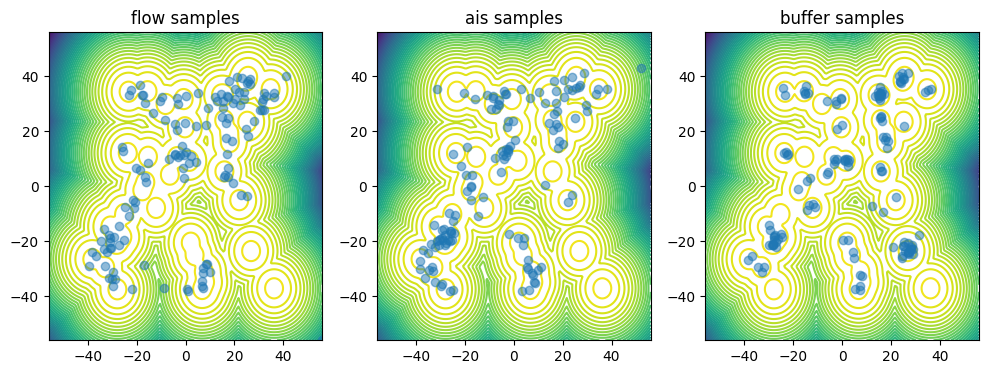

loss: 14.941627513542787, ess base: 0.395061208726582,ess ais: 0.24987397480548926:  89%|███████████████████████████████████████████████████████████████████████████████████████           | 3556/4000 [10:47<03:00,  2.46it/s]

nan loss in replay step
nan loss in replay step


loss: 7.220035837847171, ess base: 0.3727748846576455,ess ais: 0.19166897461508645:  89%|███████████████████████████████████████████████████████████████████████████████████████▏          | 3558/4000 [10:47<02:09,  3.40it/s]

nan grad norm in replay step


loss: 8.6673774297771, ess base: 0.44850453368381615,ess ais: 0.15312982410338502:  89%|████████████████████████████████████████████████████████████████████████████████████████           | 3560/4000 [10:48<01:51,  3.95it/s]

nan loss in replay step


loss: 7.814191300075997, ess base: 0.49839715325441414,ess ais: 0.3059290744217201:  89%|███████████████████████████████████████████████████████████████████████████████████████▎          | 3562/4000 [10:48<01:43,  4.22it/s]

nan loss in replay step
nan loss in replay step


loss: 13.580599087504885, ess base: 0.40262034199027025,ess ais: 0.19416996405265508:  89%|█████████████████████████████████████████████████████████████████████████████████████▌          | 3564/4000 [10:49<01:34,  4.63it/s]

nan loss in replay step
nan loss in replay step


loss: 8.447339466198265, ess base: 0.41088447638928494,ess ais: 0.20182831807357504:  89%|██████████████████████████████████████████████████████████████████████████████████████▍          | 3566/4000 [10:49<01:27,  4.96it/s]

nan loss in replay step
nan loss in replay step


loss: 7.960324264282723, ess base: 0.3514066696265385,ess ais: 0.13840925409151575:  89%|███████████████████████████████████████████████████████████████████████████████████████▍          | 3568/4000 [10:49<01:26,  5.02it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 12.144492802297576, ess base: 0.31710525341424534,ess ais: 0.06494314016055201:  89%|█████████████████████████████████████████████████████████████████████████████████████▋          | 3569/4000 [10:50<01:24,  5.11it/s]

nan loss in replay step
nan loss in replay step


loss: 8.801561612963738, ess base: 0.44992231150896805,ess ais: 0.20530667366390587:  89%|██████████████████████████████████████████████████████████████████████████████████████▌          | 3570/4000 [10:50<01:23,  5.17it/s]

nan loss in replay step


loss: 8.164601280211485, ess base: 0.05947454502684848,ess ais: 0.009104280769898892:  89%|█████████████████████████████████████████████████████████████████████████████████████▋          | 3572/4000 [10:50<01:18,  5.47it/s]

nan loss in replay step
nan loss in replay step


loss: 8.621636751303589, ess base: 0.34787830428974015,ess ais: 0.17985759406791302:  89%|██████████████████████████████████████████████████████████████████████████████████████▋          | 3574/4000 [10:50<01:12,  5.90it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 8.06631889121817, ess base: 0.35849785521048266,ess ais: 0.11172423431194353:  89%|███████████████████████████████████████████████████████████████████████████████████████▌          | 3576/4000 [10:51<01:15,  5.62it/s]

nan grad norm in replay step
nan loss in replay step


loss: 11.832703696218774, ess base: 0.3646655742784324,ess ais: 0.19414069550919047:  89%|██████████████████████████████████████████████████████████████████████████████████████▊          | 3578/4000 [10:51<01:17,  5.47it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.642786517332435, ess base: 0.253460896690135,ess ais: 0.03778791641306344:  89%|████████████████████████████████████████████████████████████████████████████████████████▌          | 3579/4000 [10:51<01:09,  6.02it/s]

nan loss in replay step


loss: 63.519206261832856, ess base: 0.4400209350501923,ess ais: 0.22239359050614485:  90%|██████████████████████████████████████████████████████████████████████████████████████▉          | 3584/4000 [10:52<01:15,  5.52it/s]

nan grad norm in replay step


loss: 9.939236860961943, ess base: 0.35203609294526667,ess ais: 0.17576248607490877:  90%|██████████████████████████████████████████████████████████████████████████████████████▉          | 3586/4000 [10:53<01:15,  5.50it/s]

nan loss in replay step
nan loss in replay step


loss: 8.293270935830517, ess base: 0.3650476057341386,ess ais: 0.1879392074980084:  90%|████████████████████████████████████████████████████████████████████████████████████████▊          | 3588/4000 [10:53<01:18,  5.25it/s]

nan loss in replay step


loss: 8.10195036392746, ess base: 0.41501939428808987,ess ais: 0.2262712600978662:  90%|████████████████████████████████████████████████████████████████████████████████████████▊          | 3589/4000 [10:53<01:16,  5.39it/s]

nan loss in replay step
nan loss in replay step


loss: 8.149491036937933, ess base: 0.43226860622744384,ess ais: 0.21117787979290323:  90%|███████████████████████████████████████████████████████████████████████████████████████          | 3591/4000 [10:54<01:14,  5.52it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step


loss: 7.316246150555262, ess base: 0.47798758123835294,ess ais: 0.30153739533887364:  90%|███████████████████████████████████████████████████████████████████████████████████████▏         | 3594/4000 [10:54<01:11,  5.72it/s]

nan loss in replay step
nan loss in replay step
nan loss in replay step


loss: 7.585675227126264, ess base: 0.36302469438660406,ess ais: 0.15497213903277268:  90%|███████████████████████████████████████████████████████████████████████████████████████▏         | 3597/4000 [10:55<01:06,  6.06it/s]

nan loss in replay step
nan loss in replay step


loss: 7.831103524656848, ess base: 0.42055116446538243,ess ais: 0.23019635695603743:  90%|███████████████████████████████████████████████████████████████████████████████████████▎         | 3598/4000 [10:55<01:02,  6.42it/s]

nan loss in replay step
nan loss in replay step


loss: 8.406225015579107, ess base: 0.39414469576637395,ess ais: 0.28250057432546155:  90%|███████████████████████████████████████████████████████████████████████████████████████▎         | 3600/4000 [10:55<01:12,  5.52it/s]

nan loss in replay step


loss: 7.574000003780394, ess base: 0.38308879526541323,ess ais: 0.2312585424119948:  90%|████████████████████████████████████████████████████████████████████████████████████████▏         | 3601/4000 [10:55<01:15,  5.27it/s]

nan loss in replay step
nan loss in replay step


loss: 7.9007208011285925, ess base: 0.4053045179570903,ess ais: 0.1078085365155738:  90%|████████████████████████████████████████████████████████████████████████████████████████▎         | 3603/4000 [10:56<01:11,  5.56it/s]

nan grad norm in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 7.396545799233856, ess base: 0.3921033220484098,ess ais: 0.23821169159924335:  90%|████████████████████████████████████████████████████████████████████████████████████████▎         | 3605/4000 [10:56<01:10,  5.59it/s]

nan loss in replay step
nan loss in replay step


loss: 9.210001387988086, ess base: 0.3891326918000951,ess ais: 0.16472262948694844:  90%|████████████████████████████████████████████████████████████████████████████████████████▎         | 3607/4000 [10:56<01:05,  6.00it/s]

nan loss in replay step
nan loss in replay step


loss: 10.507372444734985, ess base: 0.3688607759637843,ess ais: 0.1294239596974586:  90%|████████████████████████████████████████████████████████████████████████████████████████▍         | 3609/4000 [10:57<00:58,  6.67it/s]

nan loss in replay step
nan loss in replay step


loss: 7.697597530509049, ess base: 0.37816636126425673,ess ais: 0.007874015748031496:  90%|██████████████████████████████████████████████████████████████████████████████████████▋         | 3611/4000 [10:57<01:02,  6.24it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 8.20150163419905, ess base: 0.345816628750931,ess ais: 0.044123433831667336:  90%|█████████████████████████████████████████████████████████████████████████████████████████▍         | 3612/4000 [10:57<01:04,  6.06it/s]

nan loss in replay step


loss: 8.47632533055295, ess base: 0.3385089176864887,ess ais: 0.10173274592826811:  90%|█████████████████████████████████████████████████████████████████████████████████████████▍         | 3614/4000 [10:58<01:06,  5.84it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step


loss: 7.481467418355491, ess base: 0.3876002440948668,ess ais: 0.2565360370693427:  90%|█████████████████████████████████████████████████████████████████████████████████████████▍         | 3616/4000 [10:58<01:06,  5.75it/s]

nan loss in replay step
nan loss in replay step


loss: 9.91442875284497, ess base: 0.2817824120697183,ess ais: 0.04040997882820755:  90%|█████████████████████████████████████████████████████████████████████████████████████████▌         | 3618/4000 [10:58<01:13,  5.23it/s]

nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 10.008236508725206, ess base: 0.392718504094054,ess ais: 0.146244564087896:  90%|██████████████████████████████████████████████████████████████████████████████████████████▌         | 3620/4000 [10:59<01:06,  5.75it/s]

nan loss in replay step
nan loss in replay step


loss: 8.285160265405267, ess base: 0.4098627483235603,ess ais: 0.17698075327645324:  91%|████████████████████████████████████████████████████████████████████████████████████████▋         | 3622/4000 [10:59<01:03,  5.91it/s]

nan loss in replay step
nan loss in replay step


loss: 8.352153009238176, ess base: 0.5188359849045933,ess ais: 0.321800070390166:  91%|██████████████████████████████████████████████████████████████████████████████████████████▌         | 3624/4000 [10:59<00:58,  6.41it/s]

nan loss in replay step
nan loss in replay step


loss: 24.016321379257, ess base: 0.38718401022223925,ess ais: 0.1680724922368836:  91%|██████████████████████████████████████████████████████████████████████████████████████████▋         | 3626/4000 [11:00<00:54,  6.81it/s]

nan loss in replay step
nan loss in replay step


loss: 8.304107367395098, ess base: 0.43435634112595256,ess ais: 0.24599885627452814:  91%|███████████████████████████████████████████████████████████████████████████████████████▉         | 3628/4000 [11:00<00:51,  7.23it/s]

nan loss in replay step
nan loss in replay step


loss: 9.884398161238934, ess base: 0.3931939599938465,ess ais: 0.21610290981661515:  91%|████████████████████████████████████████████████████████████████████████████████████████▉         | 3630/4000 [11:00<00:54,  6.78it/s]

nan loss in replay step
nan loss in replay step


loss: 8.493446924404264, ess base: 0.38819972496583993,ess ais: 0.21984693871565647:  91%|████████████████████████████████████████████████████████████████████████████████████████         | 3632/4000 [11:00<00:49,  7.37it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 8.037667275883162, ess base: 0.4061695944426666,ess ais: 0.22293899266614922:  91%|█████████████████████████████████████████████████████████████████████████████████████████         | 3634/4000 [11:01<00:55,  6.56it/s]

nan loss in replay step
nan loss in replay step


loss: 7.952772503965086, ess base: 0.3842658534355934,ess ais: 0.1910928607931761:  91%|██████████████████████████████████████████████████████████████████████████████████████████         | 3637/4000 [11:01<00:58,  6.22it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 7.808722987484412, ess base: 0.39249894977206,ess ais: 0.0078125:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████          | 3639/4000 [11:01<00:59,  6.07it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 8.32958439729038, ess base: 0.4084072908173215,ess ais: 0.2581416395182976:  91%|███████████████████████████████████████████████████████████████████████████████████████████         | 3641/4000 [11:02<01:26,  4.15it/s]

nan loss in replay step


loss: 9.7599563991993, ess base: 0.37036769910850686,ess ais: 0.1953370009965073:  91%|███████████████████████████████████████████████████████████████████████████████████████████         | 3643/4000 [11:03<01:27,  4.08it/s]

nan grad norm in replay step


loss: 7.611720967860352, ess base: 0.38683452292700593,ess ais: 0.0078125:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▍         | 3644/4000 [11:03<01:23,  4.24it/s]

nan loss in replay step
nan loss in replay step


loss: 8.399143511855016, ess base: 0.3236031615527177,ess ais: 0.1015308193084332:  91%|██████████████████████████████████████████████████████████████████████████████████████████▏        | 3646/4000 [11:03<01:13,  4.82it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 9.500593850868016, ess base: 0.34049570824614844,ess ais: 0.18230901444273023:  91%|████████████████████████████████████████████████████████████████████████████████████████▍        | 3647/4000 [11:03<01:03,  5.57it/s]

nan loss in replay step
nan loss in replay step


loss: 255.85009766545008, ess base: 0.34824026768687444,ess ais: 0.16357318974087906:  91%|███████████████████████████████████████████████████████████████████████████████████████▌        | 3649/4000 [11:04<00:56,  6.26it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan grad norm in replay step


loss: 8.164283360115386, ess base: 0.4248675641799773,ess ais: 0.23955583496060676:  91%|█████████████████████████████████████████████████████████████████████████████████████████▍        | 3651/4000 [11:04<00:50,  6.88it/s]

nan loss in replay step
nan loss in replay step


loss: 8.070847298940205, ess base: 0.3016857206404357,ess ais: 0.14964039451484418:  91%|█████████████████████████████████████████████████████████████████████████████████████████▍        | 3653/4000 [11:04<00:52,  6.58it/s]

nan loss in replay step
nan loss in replay step


loss: 7.354680966810717, ess base: 0.4272161807603337,ess ais: 0.24533657404410072:  91%|█████████████████████████████████████████████████████████████████████████████████████████▌        | 3655/4000 [11:05<00:59,  5.76it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.200453705441724, ess base: 0.47373427951182545,ess ais: 0.27173785287031205:  91%|████████████████████████████████████████████████████████████████████████████████████████▋        | 3656/4000 [11:05<00:57,  5.96it/s]

nan loss in replay step
nan loss in replay step


loss: 7.7357488600091076, ess base: 0.4086469588732105,ess ais: 0.2023113081412421:  91%|█████████████████████████████████████████████████████████████████████████████████████████▌        | 3657/4000 [11:05<00:59,  5.76it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step


loss: 7.990372434377072, ess base: 0.4050546854664056,ess ais: 0.22951386445606164:  92%|█████████████████████████████████████████████████████████████████████████████████████████▋        | 3660/4000 [11:05<00:53,  6.40it/s]

nan loss in replay step


loss: 13.454792515330855, ess base: 0.40738551333440026,ess ais: 0.15682395397775148:  92%|███████████████████████████████████████████████████████████████████████████████████████▉        | 3663/4000 [11:06<00:53,  6.26it/s]

nan loss in replay step
nan loss in replay step


loss: 10.037221212661315, ess base: 0.3924113540855573,ess ais: 0.24431024533277607:  92%|████████████████████████████████████████████████████████████████████████████████████████▉        | 3665/4000 [11:06<00:53,  6.32it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 8.921813577227235, ess base: 0.39915538828855623,ess ais: 0.23533011478709676:  92%|████████████████████████████████████████████████████████████████████████████████████████▉        | 3666/4000 [11:06<00:51,  6.44it/s]

nan loss in replay step
nan loss in replay step


loss: 7.645853959460784, ess base: 0.3855439362128608,ess ais: 0.13613528452297582:  92%|█████████████████████████████████████████████████████████████████████████████████████████▉        | 3669/4000 [11:07<00:49,  6.74it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step


loss: 8.780314802732399, ess base: 0.3918922695019999,ess ais: 0.19487441734244065:  92%|█████████████████████████████████████████████████████████████████████████████████████████▉        | 3670/4000 [11:07<00:46,  7.05it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 8.313050745897758, ess base: 0.36402708769335457,ess ais: 0.17588448804096113:  92%|█████████████████████████████████████████████████████████████████████████████████████████        | 3673/4000 [11:07<00:47,  6.86it/s]

nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.76905321598831, ess base: 0.3551167921873057,ess ais: 0.1681633695005854:  92%|███████████████████████████████████████████████████████████████████████████████████████████▊        | 3674/4000 [11:08<01:02,  5.22it/s]

nan loss in replay step


loss: 7.691157775467279, ess base: 0.40797912694056876,ess ais: 0.0078125:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▎        | 3675/4000 [11:08<01:15,  4.32it/s]

nan loss in replay step


loss: 8.689434830958657, ess base: 0.3885589990878828,ess ais: 0.18997393113844954:  92%|██████████████████████████████████████████████████████████████████████████████████████████        | 3677/4000 [11:08<00:55,  5.81it/s]

nan loss in replay step
nan loss in replay step


loss: 7.338378426210808, ess base: 0.3906750822303542,ess ais: 0.21878660685278187:  92%|██████████████████████████████████████████████████████████████████████████████████████████        | 3678/4000 [11:08<00:52,  6.10it/s]

nan loss in replay step
nan loss in replay step


loss: 7.0342963946735555, ess base: 0.32494003275429306,ess ais: 0.09596795206260907:  92%|████████████████████████████████████████████████████████████████████████████████████████▎       | 3680/4000 [11:09<00:50,  6.29it/s]

nan loss in replay step
nan loss in replay step


loss: 9.342898628347122, ess base: 0.3763417409101642,ess ais: 0.22216165803645388:  92%|██████████████████████████████████████████████████████████████████████████████████████████▏       | 3683/4000 [11:09<00:42,  7.44it/s]

nan loss in replay step
nan loss in replay step


loss: 7.533272739510364, ess base: 0.352815691216708,ess ais: 0.20260064271679157:  92%|███████████████████████████████████████████████████████████████████████████████████████████▏       | 3684/4000 [11:09<00:42,  7.51it/s]

nan loss in replay step
nan loss in replay step
nan loss in replay step


loss: 7.83227705166268, ess base: 0.43249805675121883,ess ais: 0.25613112024810575:  92%|██████████████████████████████████████████████████████████████████████████████████████████▎       | 3686/4000 [11:09<00:43,  7.24it/s]

nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 7.924582997786599, ess base: 0.40396652341336675,ess ais: 0.19575199464236923:  92%|█████████████████████████████████████████████████████████████████████████████████████████▍       | 3688/4000 [11:10<00:43,  7.11it/s]

nan loss in replay step
nan loss in replay step


loss: 7.702326737347971, ess base: 0.4229331709118564,ess ais: 0.15396037063575746:  92%|██████████████████████████████████████████████████████████████████████████████████████████▍       | 3690/4000 [11:10<00:44,  7.00it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step


loss: 7.660017230357172, ess base: 0.3912586254797442,ess ais: 0.008828397021081666:  92%|█████████████████████████████████████████████████████████████████████████████████████████▌       | 3692/4000 [11:10<00:42,  7.24it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step


loss: 7.283123375606127, ess base: 0.46179975395364076,ess ais: 0.26946695820908056:  92%|█████████████████████████████████████████████████████████████████████████████████████████▌       | 3694/4000 [11:11<00:43,  7.03it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 7.767444531806921, ess base: 0.3548905128422439,ess ais: 0.21698476360165328:  92%|██████████████████████████████████████████████████████████████████████████████████████████▌       | 3696/4000 [11:11<00:44,  6.79it/s]

nan loss in replay step
nan loss in replay step


loss: 7.520006135794184, ess base: 0.41251428500435233,ess ais: 0.19943603341339983:  92%|█████████████████████████████████████████████████████████████████████████████████████████▋       | 3698/4000 [11:11<00:39,  7.67it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step


loss: 8.17153910175076, ess base: 0.3955758624661637,ess ais: 0.1735487344664195:  92%|████████████████████████████████████████████████████████████████████████████████████████████▌       | 3700/4000 [11:11<00:42,  7.12it/s]

nan loss in replay step
nan loss in replay step


loss: 7.760363922543123, ess base: 0.3348215184424153,ess ais: 0.2171123366826274:  93%|███████████████████████████████████████████████████████████████████████████████████████████▌       | 3702/4000 [11:12<00:40,  7.41it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 7.283442744358178, ess base: 0.4286142280664665,ess ais: 0.2024955082012729:  93%|███████████████████████████████████████████████████████████████████████████████████████████▋       | 3704/4000 [11:12<00:42,  6.98it/s]

nan loss in replay step
nan loss in replay step


loss: 8.406492061304794, ess base: 0.41966813254996405,ess ais: 0.16288002327289866:  93%|█████████████████████████████████████████████████████████████████████████████████████████▊       | 3706/4000 [11:12<00:41,  7.07it/s]

nan loss in replay step
nan loss in replay step


loss: 27.301177943334057, ess base: 0.39454912188514624,ess ais: 0.22400701333786777:  93%|████████████████████████████████████████████████████████████████████████████████████████▉       | 3708/4000 [11:13<00:39,  7.40it/s]

nan loss in replay step
nan loss in replay step


loss: 27.994541485614164, ess base: 0.3809750311386195,ess ais: 0.0078125:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▏       | 3710/4000 [11:13<00:34,  8.44it/s]

nan loss in replay step
nan loss in replay step


loss: 20.944044156446395, ess base: 0.4066885832039409,ess ais: 0.22351681378601612:  93%|██████████████████████████████████████████████████████████████████████████████████████████       | 3712/4000 [11:13<00:37,  7.59it/s]

nan loss in replay step
nan loss in replay step


loss: 8.528363825776093, ess base: 0.38769999435478025,ess ais: 0.18318593860883042:  93%|██████████████████████████████████████████████████████████████████████████████████████████       | 3714/4000 [11:13<00:36,  7.93it/s]

nan loss in replay step
nan loss in replay step


loss: 12.80569747006448, ess base: 0.33758535519073757,ess ais: 0.1903864020658449:  93%|███████████████████████████████████████████████████████████████████████████████████████████       | 3716/4000 [11:13<00:34,  8.25it/s]

nan loss in replay step


loss: 21.020441378405486, ess base: 0.38605110092520145,ess ais: 0.2483364935390088:  93%|██████████████████████████████████████████████████████████████████████████████████████████▏      | 3718/4000 [11:14<00:42,  6.69it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan grad norm in replay step
nan loss in replay step


loss: 12.625958616008358, ess base: 0.29591234308934233,ess ais: 0.014784501301098657:  93%|████████████████████████████████████████████████████████████████████████████████████████▎      | 3720/4000 [11:14<00:34,  8.00it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 97.08926448787776, ess base: 0.4176799402600378,ess ais: 0.007874015748031496:  93%|██████████████████████████████████████████████████████████████████████████████████████████▎      | 3726/4000 [11:15<00:41,  6.53it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.499063992725404, ess base: 0.27745761013561204,ess ais: 0.09760056058867837:  93%|██████████████████████████████████████████████████████████████████████████████████████████▍      | 3730/4000 [11:16<00:42,  6.34it/s]

nan grad norm in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.8246688455021705, ess base: 0.3506279868992799,ess ais: 0.2681686698266576:  93%|███████████████████████████████████████████████████████████████████████████████████████████▍      | 3734/4000 [11:16<00:40,  6.49it/s]

nan grad norm in replay step
nan grad norm in replay step


loss: 8.117658235253929, ess base: 0.41902411287649166,ess ais: 0.20520633135063968:  93%|██████████████████████████████████████████████████████████████████████████████████████████▌      | 3736/4000 [11:16<00:41,  6.35it/s]

nan grad norm in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan grad norm in replay step


loss: 7.607668285808836, ess base: 0.4029155717172495,ess ais: 0.007874015748031496:  94%|██████████████████████████████████████████████████████████████████████████████████████████▋      | 3741/4000 [11:17<00:35,  7.34it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 8.02250644980328, ess base: 0.3678799189874149,ess ais: 0.1906622751048151:  94%|█████████████████████████████████████████████████████████████████████████████████████████████▌      | 3743/4000 [11:17<00:37,  6.94it/s]

nan loss in replay step


loss: 12.398199547703925, ess base: 0.3886398123190598,ess ais: 0.21029216124693453:  94%|██████████████████████████████████████████████████████████████████████████████████████████▊      | 3746/4000 [11:18<00:36,  6.97it/s]

nan loss in replay step
nan grad norm in replay step
nan loss in replay step


loss: 8.096834167988629, ess base: 0.3430667748362981,ess ais: 0.17913718414736826:  94%|███████████████████████████████████████████████████████████████████████████████████████████▊      | 3749/4000 [11:18<00:32,  7.76it/s]

nan loss in replay step
nan loss in replay step


loss: 8.182131445449722, ess base: 0.3778905211120708,ess ais: 0.1565430083195819:  94%|████████████████████████████████████████████████████████████████████████████████████████████▊      | 3751/4000 [11:19<00:34,  7.24it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 8.044661159130765, ess base: 0.329536641764088,ess ais: 0.1188591252910144:  94%|█████████████████████████████████████████████████████████████████████████████████████████████▊      | 3754/4000 [11:19<00:31,  7.73it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.585001561322982, ess base: 0.39546515926416576,ess ais: 0.1922398233212718:  94%|███████████████████████████████████████████████████████████████████████████████████████████▉      | 3755/4000 [11:19<00:32,  7.59it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 12.506178386938078, ess base: 0.01305403839694942,ess ais: 0.007904464602479103:  94%|█████████████████████████████████████████████████████████████████████████████████████████▏     | 3757/4000 [11:19<00:30,  8.01it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.892392639720196, ess base: 0.34515594960519475,ess ais: 0.20199913917692758:  94%|███████████████████████████████████████████████████████████████████████████████████████████▎     | 3763/4000 [11:20<00:34,  6.86it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.035572850654999, ess base: 0.3018508174197575,ess ais: 0.0078125:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 3767/4000 [11:21<00:30,  7.68it/s]

nan grad norm in replay step


loss: 10.677300670023788, ess base: 0.35879495522596777,ess ais: 0.10858248905010875:  94%|██████████████████████████████████████████████████████████████████████████████████████████▍     | 3770/4000 [11:21<00:26,  8.75it/s]

nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 7.992750115207354, ess base: 0.416282930002319,ess ais: 0.23511049000837458:  94%|█████████████████████████████████████████████████████████████████████████████████████████████▍     | 3776/4000 [11:22<00:31,  7.10it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan grad norm in replay step


loss: 11.057758227571147, ess base: 0.37290589061630425,ess ais: 0.23312691287113796:  94%|██████████████████████████████████████████████████████████████████████████████████████████▋     | 3780/4000 [11:22<00:25,  8.50it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step
nan loss in replay step


loss: 7.96184039441402, ess base: 0.3338428518490809,ess ais: 0.11374474218061786:  95%|█████████████████████████████████████████████████████████████████████████████████████████████▌     | 3781/4000 [11:22<00:26,  8.27it/s]

nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 8.433827052661476, ess base: 0.4558850309904183,ess ais: 0.15223746535601687:  95%|████████████████████████████████████████████████████████████████████████████████████████████▊     | 3786/4000 [11:23<00:28,  7.56it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.709242054758944, ess base: 0.38816317883427925,ess ais: 0.2585462375811721:  95%|████████████████████████████████████████████████████████████████████████████████████████████▉     | 3791/4000 [11:24<00:28,  7.33it/s]

nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 1.5905916649485683e+24, ess base: 0.35682577912573954,ess ais: 0.15289220847188287:  95%|███████████████████████████████████████████████████████████████████████████████████████▏    | 3792/4000 [11:24<00:29,  7.01it/s]

nan loss in replay step
nan grad norm in replay step


loss: 7.625255578427351, ess base: 0.44162560641367715,ess ais: 0.23657237469337636:  95%|████████████████████████████████████████████████████████████████████████████████████████████     | 3794/4000 [11:24<00:30,  6.77it/s]

nan loss in replay step


loss: 7.469341263556923, ess base: 0.37713106175608696,ess ais: 0.20724680259710546:  95%|████████████████████████████████████████████████████████████████████████████████████████████     | 3796/4000 [11:25<00:31,  6.39it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 8.602725764237585, ess base: 0.34906532851799926,ess ais: 0.17745555525962858:  95%|████████████████████████████████████████████████████████████████████████████████████████████     | 3798/4000 [11:25<00:30,  6.65it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step


loss: 8.539083881130018, ess base: 0.3512540215106608,ess ais: 0.16008837958557623:  95%|█████████████████████████████████████████████████████████████████████████████████████████████     | 3800/4000 [11:25<00:29,  6.84it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.98539228636246, ess base: 0.372599979277484,ess ais: 0.1977826176802318:  95%|████████████████████████████████████████████████████████████████████████████████████████████████     | 3802/4000 [11:26<00:30,  6.56it/s]

nan loss in replay step
nan loss in replay step


loss: 9.34219196885421, ess base: 0.3682761637347619,ess ais: 0.1724471750432203:  95%|███████████████████████████████████████████████████████████████████████████████████████████████     | 3804/4000 [11:26<00:29,  6.58it/s]

nan grad norm in replay step
nan grad norm in replay step


loss: 8.738845551812876, ess base: 0.4267476254077541,ess ais: 0.2184686343087584:  95%|██████████████████████████████████████████████████████████████████████████████████████████████▏    | 3806/4000 [11:26<00:29,  6.53it/s]

nan loss in replay step
nan loss in replay step


loss: 9.089304527350686, ess base: 0.4391962150054028,ess ais: 0.007874015748031496:  95%|████████████████████████████████████████████████████████████████████████████████████████████▎    | 3808/4000 [11:26<00:28,  6.81it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step


loss: 9.644397460570907, ess base: 0.3325073368830204,ess ais: 0.1457575898943906:  95%|██████████████████████████████████████████████████████████████████████████████████████████████▎    | 3812/4000 [11:27<00:29,  6.29it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.442751391807164, ess base: 0.36388435247182976,ess ais: 0.1781804174800225:  95%|█████████████████████████████████████████████████████████████████████████████████████████████▍    | 3815/4000 [11:27<00:27,  6.69it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.325752637460965, ess base: 0.3603428786417333,ess ais: 0.10269114290110697:  95%|█████████████████████████████████████████████████████████████████████████████████████████████▌    | 3817/4000 [11:28<00:29,  6.16it/s]

nan loss in replay step
nan loss in replay step


loss: 7.259210686963562, ess base: 0.4425428330512661,ess ais: 0.23312318685634945:  95%|█████████████████████████████████████████████████████████████████████████████████████████████▌    | 3819/4000 [11:28<00:27,  6.62it/s]

nan loss in replay step


loss: 7.621140482317811, ess base: 0.37472008444201244,ess ais: 0.23947674677975714:  96%|████████████████████████████████████████████████████████████████████████████████████████████▋    | 3822/4000 [11:29<00:30,  5.74it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 9.268735847025962, ess base: 0.4085708169423577,ess ais: 0.1793707176751282:  96%|██████████████████████████████████████████████████████████████████████████████████████████████▌    | 3823/4000 [11:29<00:29,  5.96it/s]

nan loss in replay step
nan loss in replay step


loss: 7.901559311870086, ess base: 0.4193484642568631,ess ais: 0.26717395849970166:  96%|█████████████████████████████████████████████████████████████████████████████████████████████▋    | 3825/4000 [11:29<00:26,  6.50it/s]

In [ ]:
# Now run!
trainer.run(n_iterations=n_iterations, batch_size=batch_size, n_plot=n_plots, \
            n_eval=n_eval, eval_batch_size=eval_batch_size, save=False)  # note that the progress bar during training prints ESS w.r.t p^2/q. 

In the below plot of samples from the flow vs the target contours, and with the test set log prob throughout training, we see that the flow covers the target distribution quite well. It may be trained further to obtain even better results. 

In [ ]:
# Test set probability using samples from the target distribution.
eval_iters = np.linspace(0, n_iterations, n_eval)
plt.plot(eval_iters, logger.history['flow_test_set_mean_log_prob_p_target'])
plt.ylabel("mean test set log prob")
plt.xlabel("eval iteration")
plt.yscale("symlog")

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
target.to("cpu")
plot_contours(target.log_prob, bounds=plotting_bounds, ax=axs, n_contour_levels=50, grid_width_n_points=200)
target.to("cuda")

n_samples = 1000
samples_flow = fab_model.flow.sample((n_samples,)).detach()
plot_marginal_pair(samples_flow, ax=axs, bounds=plotting_bounds)

# Training a flow by reverse KL divergence minimisation.

In [ ]:
loss_type = "flow_reverse_kl" # can set to "target_foward_kl" for training by maximum likelihood of samples from the GMM target.

In [ ]:
# Create flow using the same architecture.
flow = make_wrapped_normflow_realnvp(dim, n_flow_layers=n_flow_layers, 
                                 layer_nodes_per_dim=layer_nodes_per_dim,
                                act_norm = False)
optimizer = torch.optim.Adam(flow.parameters(), lr=lr)
logger = ListLogger(save=False) # save training history

In [ ]:
# use GPU if available
if torch.cuda.is_available():
  flow.cuda()
  transition_operator.cuda()
  target.to("cuda")
  print(f"Running with GPU")

In [ ]:
n_iterations = int(3*(n_iterations)) # Training the flow by KL minimisation is cheaper per iteration, so we run it for more iterations.

In [ ]:
reverse_kld_model = FABModel(flow=flow,
                     target_distribution=target,
                     n_intermediate_distributions=n_intermediate_distributions,
                     transition_operator=transition_operator,
                     loss_type=loss_type,
                     alpha=1.0)

In [ ]:
def plot_flow_reverse_kld(fab_model, n_samples = 300):
    fig, axs = plt.subplots(1,1, figsize=(4, 4))
    target.to("cpu")
    plot_contours(target.log_prob, bounds=plotting_bounds, ax=axs, n_contour_levels=50, grid_width_n_points=200)
    target.to("cuda")

    # plot flow samples
    samples_flow = fab_model.flow.sample((n_samples,))
    plot_marginal_pair(samples_flow, ax=axs, bounds=plotting_bounds)
    
    axs.set_title("flow samples")
    plt.show()
    return [fig]

In [ ]:
trainer = Trainer(model=reverse_kld_model, optimizer=optimizer, logger=logger, plot=plot_flow_reverse_kld, max_gradient_norm=max_gradient_norm)

In [ ]:
# Now run!
trainer.run(n_iterations=n_iterations, batch_size=batch_size, n_plot=n_plots, \
            n_eval=n_eval, eval_batch_size=eval_batch_size, save=False)

We evaluate the flow on samples from the target distribution, we see that because the flow trained by kl divergence minimisation is missing modes, the flow places NaN log prob on samples from the target. 

In [ ]:
logger.history["flow_test_set_mean_log_prob"]

In [ ]:
eval_iters = np.linspace(0, n_iterations, n_eval)
plt.plot(eval_iters, logger.history["flow_test_set_mean_log_prob"])
plt.ylabel("mean test set log prob")
plt.xlabel("eval iteration")
plt.yscale("symlog")